# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

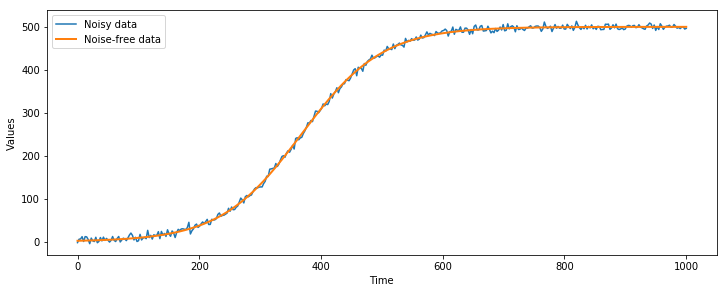

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

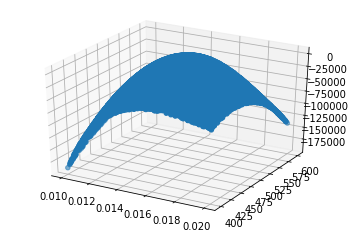

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(10000)
xs = [p[0] for p in input_parameters]
ys = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

#print(max(likelihoods))
#idx = list(likelihoods).index(max(likelihoods))
#print(input_parameters[idx])
#print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=3, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [15]:
emu([0.015, 500])

array([[-1386.9655]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1230.2906996338406

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


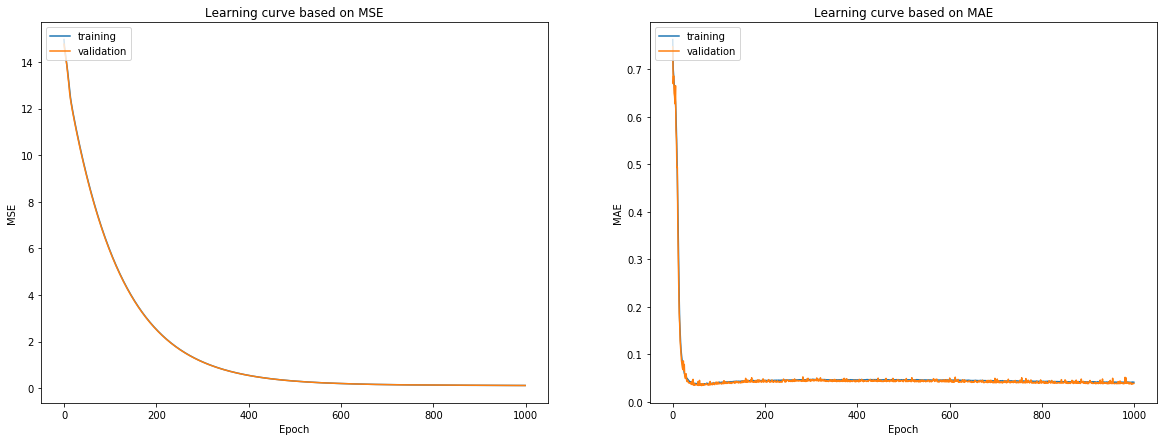

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))                 
ax1.title.set_text('Learning curve based on MSE')
ax2.title.set_text('Learning curve based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

plt.show()

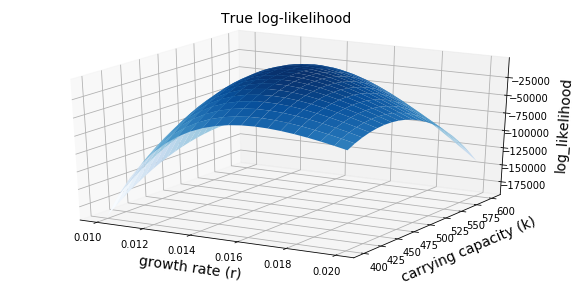

In [18]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

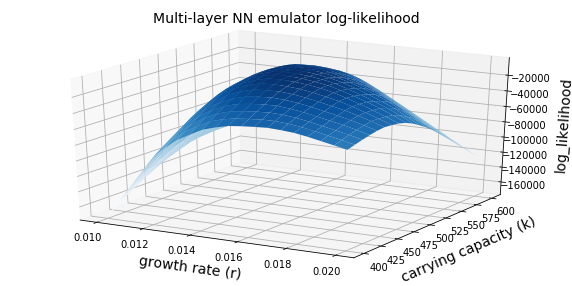

In [19]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [20]:
print(model_prediction.shape
     )
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.03933693360681304

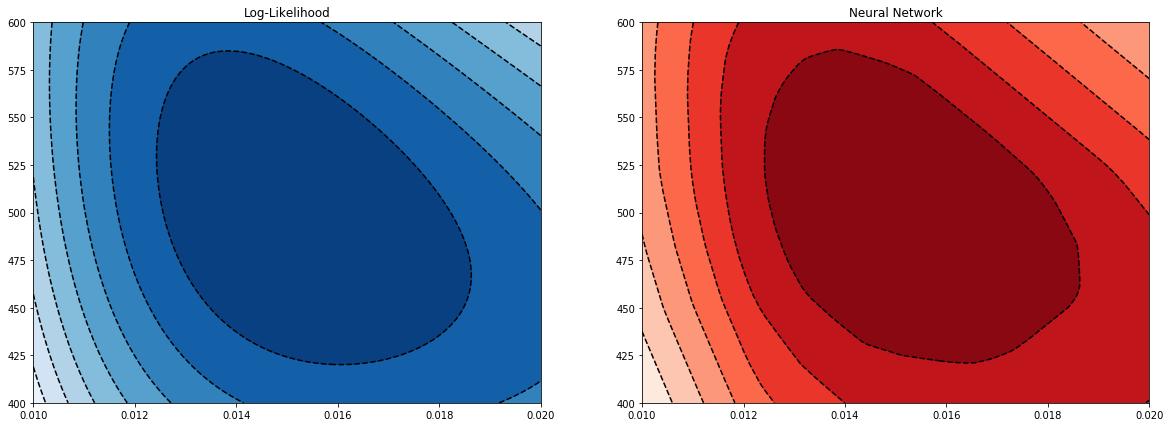

In [21]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

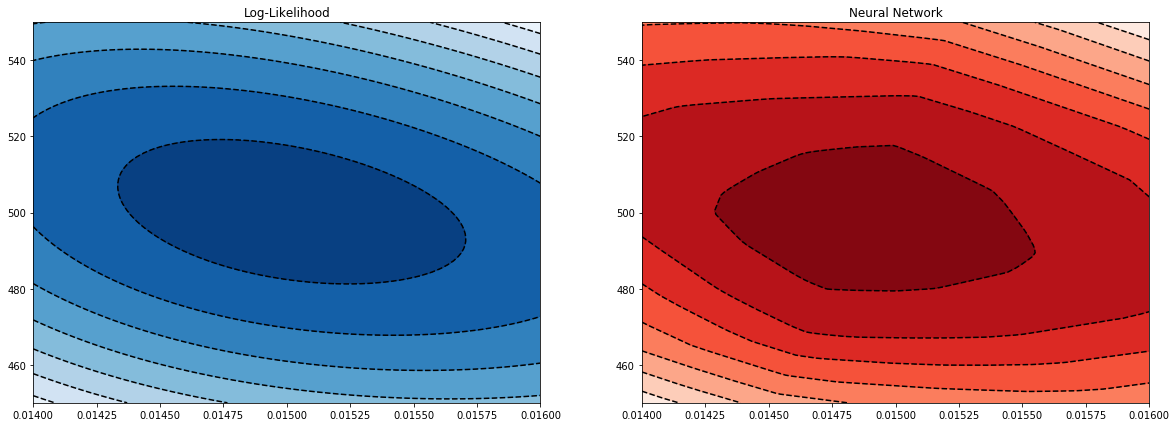

In [42]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.014, 450], [0.016, 550], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

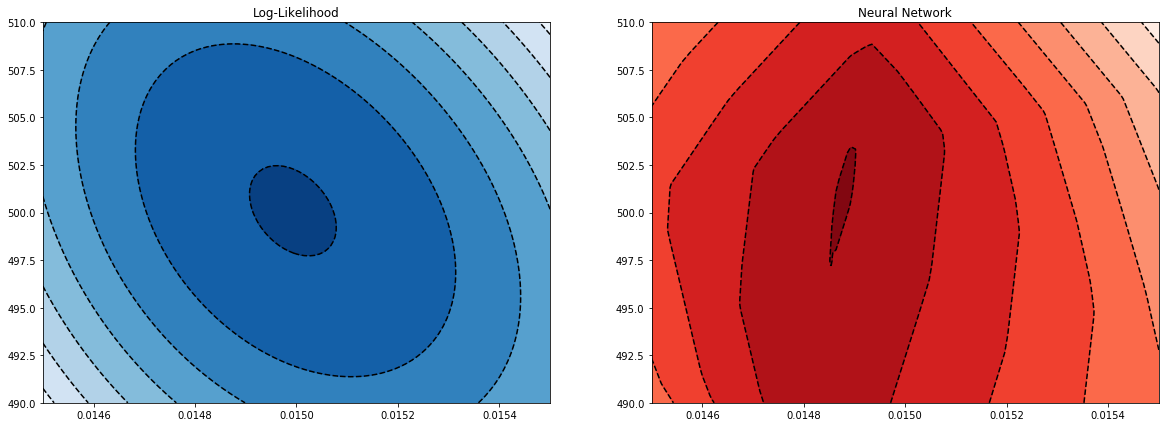

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

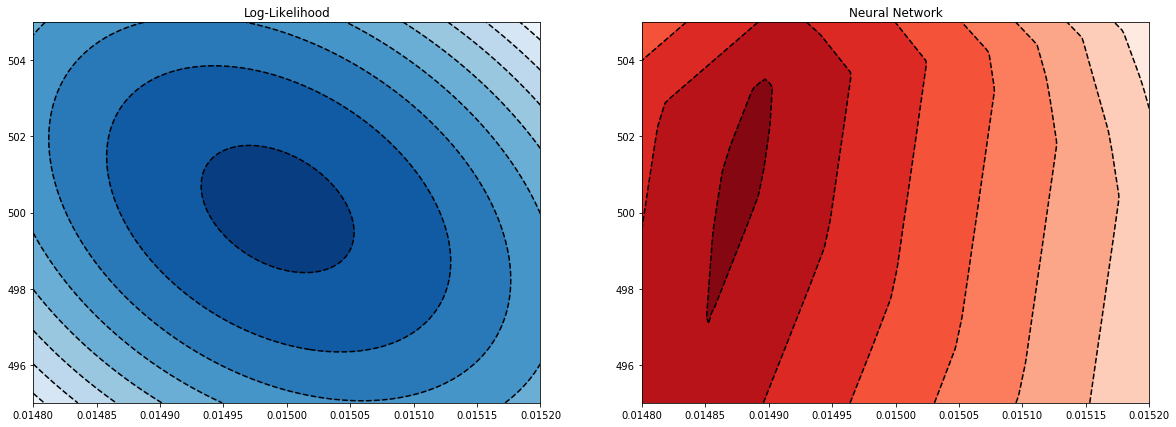

In [53]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0148, 495], [0.0152, 505], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [25]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

Running...
[2.56610836e-03 4.50783512e+02]
-inf


[1.95731239e-02 5.23232937e+02]
-55006.24815612234


[2.01554351e-02 5.71786512e+02]
-inf


[1.68311629e-02 4.49697332e+02]
-13463.628333690463
accepted


[3.10971372e-02 5.26529982e+02]
-inf


[7.62731045e-03 5.76277087e+02]
-inf


[1.45788006e-02 4.50617672e+02]
-13282.219491135096
accepted


[8.16223965e-03 5.22430702e+02]
-inf


[2.42826998e-02 5.78256056e+02]
-inf


[1.37941874e-03 4.50663540e+02]
-inf


[2.06067991e-02 5.23047242e+02]
-inf


[9.17835039e-03 5.77846788e+02]
-inf


[5.00212012e-03 4.52788454e+02]
-inf


[4.04995086e-02 5.27060945e+02]
-inf


[2.41609982e-02 5.74330931e+02]
-inf


[1.72352340e-02 4.49235446e+02]
-15769.719665416624


[-3.90924735e-03  5.27007677e+02]
-inf


[8.54057418e-03 5.75639442e+02]
-inf


[1.37664761e-02 4.50881804e+02]
-20619.46755442829


[-4.07742389e-05  5.21911075e+02]
-inf


[1.95263350e-02 5.71993767e+02]
-95880.38937663203


[1.55633679e-02 4.50079266e+02]
-10368.04781074457
accepted



[5.96447356e-03 5.73083612e+02]
-inf


[1.21032777e-02 4.53052050e+02]
-53847.87367895034


[1.87025214e-03 5.25297243e+02]
-inf


[2.82428295e-02 5.69525661e+02]
-inf


[2.62359802e-02 4.48897885e+02]
-inf


[1.82012280e-02 5.21120942e+02]
-32609.887175319906


[-5.29010027e-03  5.74856144e+02]
-inf


[1.35844908e-02 4.55741308e+02]
-20757.619599729405


[1.85701028e-02 5.24754782e+02]
-39915.596871039794


[-1.83348572e-02  5.71588086e+02]
-inf


[1.48493573e-02 4.53892555e+02]
-10527.647194260098


[2.02538461e-02 5.24205421e+02]
-inf


[1.70004307e-04 5.69689633e+02]
-inf


[2.64375901e-02 4.53049286e+02]
-inf


[2.08445538e-02 5.23815526e+02]
-inf


[3.43791852e-02 5.72443445e+02]
-inf


[2.73123723e-02 4.49631936e+02]
-inf


[2.45020659e-02 5.20920636e+02]
-inf


[2.70794299e-02 5.72575776e+02]
-inf


[1.22387387e-02 4.53856803e+02]
-49457.52897696372


[1.30037768e-02 5.20554544e+02]
-14655.87795180605


[1.07060631e-02 5.71383896e+02]
-81463.13181604908


[3.25205546e-02 4.5026


[2.42060800e-02 5.72398395e+02]
-inf


[2.48424934e-02 4.57153221e+02]
-inf


[3.63189101e-02 5.23406109e+02]
-inf


[1.32724422e-02 5.72582859e+02]
-21256.91310196555


[-6.84526935e-03  4.50895404e+02]
-inf


[-3.00866674e-03  5.25348212e+02]
-inf


[-1.22501437e-02  5.70315528e+02]
-inf


[2.23491916e-02 4.53844812e+02]
-inf


[2.03425272e-02 5.29502234e+02]
-inf


[2.23735677e-02 5.73482376e+02]
-inf


[6.12280524e-03 4.51919325e+02]
-inf


[3.14317166e-02 5.30014075e+02]
-inf


[1.08984323e-02 5.72966360e+02]
-73505.57062657156


[1.13884649e-02 4.54342653e+02]
-78297.99136721517


[-4.31725009e-03  5.27292439e+02]
-inf


[1.89572396e-02 5.70573323e+02]
-82483.03954779558


[3.32361888e-02 4.59304881e+02]
-inf


[1.15663227e-02 5.24939049e+02]
-48721.19032028818


[1.59140208e-02 5.71480148e+02]
-30812.467271083893


[2.18277385e-02 4.55966977e+02]
-inf


[2.72346589e-02 5.29460639e+02]
-inf


[7.27694085e-03 5.70379841e+02]
-inf


[1.74767566e-02 4.53302032e+02]
-16341.712985507

-16493.95371529648


[1.54803445e-02 4.58285325e+02]
-7579.449906710434
accepted


[1.48452265e-02 5.26624467e+02]
-3812.6642017311406


[1.41993069e-02 5.66761145e+02]
-16175.58039907921
accepted


[1.54509184e-02 4.58236337e+02]
-7606.872856407072


[1.44988550e-02 5.26562308e+02]
-3726.8395937394926


[1.46341527e-02 5.66665023e+02]
-17226.374798011613


[1.53218876e-02 4.57898605e+02]
-7823.9307150080585


[1.42123601e-02 5.26592565e+02]
-4331.865396106811


[1.43053584e-02 5.66955580e+02]
-16399.576275476116


[1.51373244e-02 4.58360473e+02]
-7986.425719082502


[1.44382011e-02 5.26596868e+02]
-3807.70291736174


[1.38497242e-02 5.66874677e+02]
-16432.77961134511


[1.51248363e-02 4.58193205e+02]
-8070.604127298204


[1.44673083e-02 5.26551531e+02]
-3760.799602944262


[1.40056138e-02 5.66670837e+02]
-16126.548511343197
accepted


[1.55774491e-02 4.58159062e+02]
-7610.07013401847


[1.47572946e-02 5.26590784e+02]
-3708.444453735092


[1.42367188e-02 5.66742351e+02]
-16204.44830418

[1.60565642e-02 4.66893189e+02]
-6184.55016443951
accepted


[1.45890776e-02 5.25281638e+02]
-3445.0445741319936


[1.42479167e-02 5.63288132e+02]
-14702.368344044951


[1.60052021e-02 4.66172242e+02]
-6181.7679702875
accepted


[1.45304954e-02 5.25057362e+02]
-3449.799415762969


[1.46024082e-02 5.58407851e+02]
-13304.845642615135
accepted


[1.58429396e-02 4.62465619e+02]
-6665.246902720794


[1.45123712e-02 5.24696096e+02]
-3411.3863706285374
accepted


[1.46892997e-02 5.57108580e+02]
-13029.13859725373
accepted


[1.60842486e-02 4.66345594e+02]
-6378.195036438134


[1.45393273e-02 5.24948872e+02]
-3424.580685863649


[1.46524125e-02 5.56608750e+02]
-12696.424928788445
accepted


[1.61888191e-02 4.67729068e+02]
-6469.377279835834


[1.45645549e-02 5.24712192e+02]
-3366.850082242344
accepted


[1.46533680e-02 5.56777439e+02]
-12770.198561311609


[1.61369989e-02 4.69143092e+02]
-6034.262870340846
accepted


[1.45009327e-02 5.24331815e+02]
-3368.9086487069217


[1.47770192e-02 5.54911

-8616.79387325471


[1.54045900e-02 4.88682119e+02]
-1890.7560485135398


[1.44921918e-02 5.13735229e+02]
-2231.267627439268


[1.65504962e-02 4.93234033e+02]
-7031.78699878765


[1.51782819e-02 4.98550136e+02]
-1322.8137402952611


[1.46979764e-02 5.00854210e+02]
-1494.4492867574281


[1.62373273e-02 5.01332268e+02]
-5652.376316055259
accepted


[1.5030490e-02 5.0489757e+02]
-1344.7525400205348


[1.50001999e-02 4.96702205e+02]
-1275.724026373532
accepted


[1.62978745e-02 4.92531757e+02]
-5323.45460089481
accepted


[1.48113254e-02 5.04564488e+02]
-1349.2538861409612


[1.51571153e-02 4.92284167e+02]
-1458.253222503307


[1.60124643e-02 5.12466749e+02]
-5895.698154537963


[1.50378530e-02 4.97558245e+02]
-1253.9368254723065


[1.48928514e-02 4.95125792e+02]
-1403.219256647997


[1.61847385e-02 5.02978878e+02]
-5508.900417146836


[1.51417106e-02 4.94433374e+02]
-1360.9050797535106


[1.50518037e-02 4.96714226e+02]
-1271.8102250680615
accepted


[1.64262242e-02 4.87610835e+02]
-5966.5

-3846.18213636146


[1.49769505e-02 4.99948582e+02]
-1231.8598988413858
accepted


[1.49168411e-02 4.98313222e+02]
-1272.8830307264632


[1.53059252e-02 5.09132495e+02]
-2103.809251788959


[1.49260216e-02 4.99706876e+02]
-1247.4898840984633


[1.48929142e-02 5.01495117e+02]
-1258.6235605469374


[1.50861207e-02 4.90955802e+02]
-1529.29456946705


[1.50677647e-02 4.97612001e+02]
-1258.0987777368885


[1.49562270e-02 4.98769885e+02]
-1246.0537699108559


[1.52432734e-02 5.06168904e+02]
-1702.3250151291986


[1.49971007e-02 4.98982268e+02]
-1235.4941805049416


[1.47876998e-02 5.01642006e+02]
-1348.3825924781975


[1.52262043e-02 5.11482290e+02]
-2154.4952720700167


[1.50353613e-02 5.00694944e+02]
-1240.184639807314


[1.49861509e-02 5.00768621e+02]
-1232.46827578387
accepted


[1.49763506e-02 4.94625471e+02]
-1360.7437093102153


[1.50271762e-02 4.99662531e+02]
-1234.0961352890602
accepted


[1.50324504e-02 5.00822312e+02]
-1240.404948784871


[1.48135654e-02 4.94903791e+02]
-1518.2688

[1.49835866e-02 5.00002301e+02]
-1231.1804375140962
accepted


[1.50232169e-02 4.99571063e+02]
-1233.5527205685291


[1.49686066e-02 4.99503334e+02]
-1235.2016181146726


[1.49933377e-02 5.00156399e+02]
-1230.8550685593045
accepted


[1.50243116e-02 4.99750409e+02]
-1233.5605653155963


[1.50412517e-02 5.01943997e+02]
-1259.7425654093252


[1.50075285e-02 5.00459046e+02]
-1232.5434440956367


[1.50090916e-02 4.99221902e+02]
-1233.580546486355


[1.50517044e-02 5.00838500e+02]
-1247.6832098901289


[1.50052184e-02 5.00257406e+02]
-1231.6221672310535
accepted


[1.50341061e-02 4.98680653e+02]
-1239.4875807252627


[1.49336432e-02 4.98902485e+02]
-1253.294045640938


[1.49986158e-02 5.00326715e+02]
-1231.2917949887676
accepted


[1.50286298e-02 4.99156749e+02]
-1235.6670173510563


[1.50128899e-02 5.01325414e+02]
-1240.4228092430353


[1.49982663e-02 4.99966547e+02]
-1230.9389541841908
accepted


[1.49977203e-02 4.99641555e+02]
-1231.5480072598148
accepted


[1.49792711e-02 5.00818655e+02

[1.50276725e-02 5.00188665e+02]
-1235.0075877144898


[1.50161829e-02 4.99797124e+02]
-1232.355900074751


[1.49866336e-02 5.00935711e+02]
-1233.4307186326605


[1.50357204e-02 4.98633075e+02]
-1240.1121869388191


[1.49835401e-02 5.00545253e+02]
-1231.5847707606895
accepted


[1.50146762e-02 5.00685597e+02]
-1234.8959652227727


[1.50223417e-02 4.98963482e+02]
-1236.0124823982908


[1.49797731e-02 5.00796087e+02]
-1232.6175992897201
accepted


[1.49818086e-02 5.01173703e+02]
-1234.9990593187395


[1.50229338e-02 4.98535967e+02]
-1239.6752215143676


[1.49534355e-02 5.00781482e+02]
-1235.3349083816563


[1.49687319e-02 5.00243057e+02]
-1232.4025516470247


[1.50016819e-02 5.00390856e+02]
-1231.6863436106692
accepted


[1.49990008e-02 5.00453113e+02]
-1231.6897932004697
accepted


[1.50106826e-02 5.01055751e+02]
-1237.106617643081


[1.49994970e-02 5.00330712e+02]
-1231.3550481750478
accepted


[1.49981186e-02 5.00501050e+02]
-1231.802903806734
accepted


[1.49929096e-02 4.99799555e+02]

[1.49835821e-02 5.00711634e+02]
-1232.1883119328156
accepted


[1.49486950e-02 5.00119197e+02]
-1236.774961563635


[1.50039991e-02 4.99900933e+02]
-1231.210198162026
accepted


[1.49364195e-02 5.01332463e+02]
-1241.2312076259313


[1.49712211e-02 5.00859678e+02]
-1233.300425022974


[1.50157276e-02 4.99272228e+02]
-1233.6764074911846


[1.49991744e-02 4.99377939e+02]
-1232.653323757074
accepted


[1.49391031e-02 5.01545963e+02]
-1241.9729640563728


[1.49963957e-02 4.99561415e+02]
-1231.85437358235
accepted


[1.50323038e-02 4.98516928e+02]
-1240.6985531670302


[1.49680639e-02 5.00465467e+02]
-1232.5200778338753
accepted


[1.49968432e-02 4.99269662e+02]
-1233.3502530553446
accepted


[1.49950988e-02 4.99240476e+02]
-1233.6241276075245


[1.50009840e-02 5.00564898e+02]
-1232.300903417169
accepted


[1.49522587e-02 4.99786558e+02]
-1237.3239553849253


[1.49814056e-02 4.98929945e+02]
-1237.7876288720738


[1.49924038e-02 5.01026467e+02]
-1234.383909873587


[1.50117217e-02 4.98982363e


[1.50113187e-02 5.00638681e+02]
-1234.0094997859994


[1.49730448e-02 5.00732984e+02]
-1232.6607827824619


[1.49872916e-02 5.00935328e+02]
-1233.4514750872843


[1.49800597e-02 5.00849638e+02]
-1232.875312095199


[1.49820648e-02 5.00908443e+02]
-1233.1836064374431


[1.49958180e-02 4.99672186e+02]
-1231.4681636028097


[1.50024019e-02 5.00192722e+02]
-1231.2612874685137
accepted


[1.49797743e-02 5.00015116e+02]
-1231.4457017039842
accepted


[1.49981860e-02 5.00517033e+02]
-1231.8694696696195
accepted


[1.49785283e-02 5.01366199e+02]
-1236.5820939345842


[1.49876609e-02 5.00261927e+02]
-1230.9550663088692
accepted


[1.49994110e-02 4.99868306e+02]
-1231.0557607487765
accepted


[1.49865743e-02 5.00613520e+02]
-1231.7946631385912


[1.49687159e-02 5.00032448e+02]
-1232.7412287131485


[1.49731011e-02 5.00849970e+02]
-1233.1351753616511


[1.49874902e-02 5.00810829e+02]
-1232.7182093740828


[1.50091267e-02 4.99881455e+02]
-1231.5839674060946
accepted


[1.49917086e-02 5.00492064e+

[1.49951170e-02 5.00332593e+02]
-1231.1411017405226
accepted


[1.49880551e-02 4.99582351e+02]
-1232.1396819806737


[1.50281193e-02 5.00469688e+02]
-1236.485034698538


[1.50256770e-02 5.00034644e+02]
-1234.1180016685444


[1.49674468e-02 5.01192021e+02]
-1235.4460717537631


[1.49553668e-02 5.01266376e+02]
-1237.1658701577094


[1.50052119e-02 4.99328434e+02]
-1232.9077462871887


[1.49558073e-02 5.00136029e+02]
-1234.9404709212126


[1.49906802e-02 4.99905368e+02]
-1231.012008422881
accepted


[1.49609058e-02 5.01518662e+02]
-1238.5165745191487


[1.49684903e-02 5.00207607e+02]
-1232.467850507059


[1.49780059e-02 5.01787435e+02]
-1241.1608940563538


[1.49785902e-02 4.99541242e+02]
-1233.3096766443894


[1.49539148e-02 5.01070808e+02]
-1236.283267547011


[1.49803670e-02 4.99873893e+02]
-1231.7072369059063


[1.50006289e-02 5.01858905e+02]
-1244.9582704320353


[1.49852565e-02 4.99523175e+02]
-1232.656103329271


[1.50602466e-02 4.98669707e+02]
-1245.3697047310386


[1.49774285e-02

[1.49622033e-02 5.00593277e+02]
-1233.4818564259601


[1.50271078e-02 5.01351356e+02]
-1244.6584799067039


[1.49815090e-02 4.98818279e+02]
-1238.9803808310273


[1.49410787e-02 5.01076455e+02]
-1238.9051044008293


[1.49989379e-02 4.99996652e+02]
-1230.9465362047758
accepted


[1.49850558e-02 4.99982930e+02]
-1231.1216408856649
accepted


[1.49984753e-02 4.99669277e+02]
-1231.4612548512093
accepted


[1.49026310e-02 5.00622482e+02]
-1253.5534598389675


[1.50072957e-02 5.00543507e+02]
-1232.9004446561667


[1.50067301e-02 4.99172430e+02]
-1233.82633699847


[1.50051484e-02 5.00527490e+02]
-1232.5612369098544


[1.49776084e-02 4.99961599e+02]
-1231.7585964559844
accepted


[1.50175957e-02 4.98120877e+02]
-1244.5515297388602


[1.50249012e-02 4.99685957e+02]
-1233.6851612341545


[1.49657984e-02 5.00174708e+02]
-1232.917609250835


[1.49913655e-02 4.99283882e+02]
-1233.5727592974545


[1.49952926e-02 5.00416104e+02]
-1231.3592312700366
accepted


[1.49815142e-02 4.99831126e+02]
-1231.72

[1.50609526e-02 4.99486641e+02]
-1243.4511057299796


[1.49508052e-02 5.00092603e+02]
-1236.2997658662139


[1.49782105e-02 4.99005212e+02]
-1237.570538429828


[1.50302690e-02 5.00479488e+02]
-1237.1048678024206
accepted


[1.49655261e-02 5.00755914e+02]
-1233.4290131814537
accepted


[1.49649842e-02 4.99625737e+02]
-1235.1591168591538


[1.50778985e-02 4.99019414e+02]
-1250.5607093638373


[1.49634552e-02 5.01835876e+02]
-1241.6607380725177


[1.49845079e-02 4.99953384e+02]
-1231.202526038343
accepted


[1.49791463e-02 5.01019634e+02]
-1233.8705087336673
accepted


[1.49426391e-02 4.99593776e+02]
-1241.725999086512


[1.49728791e-02 4.99373724e+02]
-1235.3095711802953


[1.50228126e-02 5.01096648e+02]
-1240.3446497366472


[1.49291621e-02 5.00669049e+02]
-1241.8052147807018


[1.49453374e-02 5.00192239e+02]
-1237.4831757179252


[1.49607411e-02 5.01445923e+02]
-1237.8985155741202


[1.49565190e-02 5.01644359e+02]
-1240.0778622574817


[1.49813408e-02 5.00640802e+02]
-1231.94271242461

[1.50177447e-02 5.00330942e+02]
-1233.5527111350343


[1.50303796e-02 4.99955904e+02]
-1234.950263697658


[1.49904203e-02 4.98830320e+02]
-1237.550086522356


[1.49686347e-02 5.02144081e+02]
-1245.7016548846077


[1.49946234e-02 4.99527788e+02]
-1232.0431956757434
accepted


[1.49659918e-02 4.99590338e+02]
-1235.1662212715742


[1.49747834e-02 5.01145236e+02]
-1234.7887691123478


[1.50380089e-02 4.98297390e+02]
-1243.66283926901


[1.49666649e-02 4.99691440e+02]
-1234.4398105090713


[1.50248963e-02 5.00012863e+02]
-1233.9158898509854


[1.50132889e-02 4.99676316e+02]
-1232.167223634762
accepted


[1.49760910e-02 4.99891873e+02]
-1232.1128300592761
accepted


[1.49462029e-02 5.00799314e+02]
-1236.9005161959453


[1.50557897e-02 4.97392438e+02]
-1258.912970638186


[1.49794431e-02 4.99080943e+02]
-1236.624863874842


[1.49543273e-02 5.01368468e+02]
-1238.005747879585


[1.50419436e-02 4.98836827e+02]
-1239.7286961658526


[1.49976481e-02 5.00282685e+02]
-1231.1437411142351
accepted




accepted


[1.49672376e-02 5.01450438e+02]
-1237.5045226202737


[1.50114757e-02 4.99894792e+02]
-1231.8026406256504


[1.50132416e-02 4.99381775e+02]
-1233.0089586012489


[1.49430284e-02 5.01540629e+02]
-1241.1314778344306


[1.5020579e-02 4.9952384e+02]
-1233.2834092581386


[1.50094844e-02 5.00861637e+02]
-1235.232865309333


[1.49415781e-02 5.01237609e+02]
-1239.4999302822316


[1.50335682e-02 5.00188659e+02]
-1236.4534654934296


[1.50148834e-02 4.99702943e+02]
-1232.2889400449174
accepted


[1.50037036e-02 5.01434715e+02]
-1239.8238103107058


[1.49803490e-02 4.99967858e+02]
-1231.483380902667
accepted


[1.50428255e-02 4.98368238e+02]
-1243.65914086546


[1.5002468e-02 4.9940638e+02]
-1232.490808428145
accepted


[1.49927809e-02 5.00450951e+02]
-1231.3656395121707
accepted


[1.49973894e-02 4.99453012e+02]
-1232.3108052940395
accepted


[1.49768907e-02 5.00489996e+02]
-1231.727773326169
accepted


[1.50420352e-02 5.00279102e+02]
-1239.382895112554


[1.50349893e-02 4.98639827e+

[1.5022102e-02 4.9976136e+02]
-1233.197393494338


[1.49518447e-02 5.01417203e+02]
-1238.7105433279114


[1.50369759e-02 4.99640238e+02]
-1236.157786275885


[1.49734282e-02 5.00641860e+02]
-1232.3369257589068
accepted


[1.49748577e-02 5.01222014e+02]
-1235.3572471996156


[1.50089230e-02 5.00284875e+02]
-1232.0874876689654
accepted


[1.50150136e-02 5.00792661e+02]
-1235.725163148216


[1.49695822e-02 4.99802461e+02]
-1233.3731983816601


[1.50540764e-02 5.00332706e+02]
-1244.090635527896


[1.49587864e-02 5.00794358e+02]
-1234.451318561425


[1.49750939e-02 5.00765520e+02]
-1232.6596564350245


[1.49950119e-02 5.00344428e+02]
-1231.1635929040008
accepted


[1.49825957e-02 5.00414984e+02]
-1231.3001311670691
accepted


[1.49920499e-02 4.98155026e+02]
-1246.19834478845


[1.49397724e-02 5.01335454e+02]
-1240.4415977743952


[1.49559801e-02 5.01832471e+02]
-1242.0811642803155


[1.49373049e-02 5.01325953e+02]
-1240.9755312555287


[1.50090897e-02 5.00754071e+02]
-1234.3899077949939


[

[1.50844734e-02 4.98927720e+02]
-1253.7168382531088


[1.49898921e-02 4.99932957e+02]
-1230.9904112602742
accepted


[1.49924921e-02 5.00986685e+02]
-1234.0941701541065


[1.49952442e-02 5.00353009e+02]
-1231.1921790121935
accepted


[1.50146930e-02 5.00100301e+02]
-1232.3832311542242
accepted


[1.49853798e-02 5.01191941e+02]
-1235.2717278626446


[1.49675147e-02 5.01505847e+02]
-1238.0024244773092


[1.50394645e-02 4.99647117e+02]
-1236.7733753538512


[1.49731499e-02 4.99554637e+02]
-1234.0453228438282


[1.50385607e-02 4.99793207e+02]
-1236.6602211310114


[1.50165084e-02 5.00434365e+02]
-1233.7898631815908


[1.49981581e-02 5.00499867e+02]
-1231.8011385618431
accepted


[1.49840145e-02 5.00149677e+02]
-1231.0311191496787
accepted


[1.49986975e-02 4.99345532e+02]
-1232.8386898052202
accepted


[1.49762158e-02 5.00749196e+02]
-1232.5371907144652


[1.49530480e-02 5.00446485e+02]
-1235.0810481517892


[1.49775039e-02 4.98327121e+02]
-1246.4185986573339


[1.50238407e-02 5.00189108e+

[1.49625733e-02 5.02281158e+02]
-1247.716275302026


[1.49968910e-02 4.98394409e+02]
-1242.0229501324125


[1.49783478e-02 4.99877584e+02]
-1231.8996051299612
accepted


[1.49480042e-02 5.01550174e+02]
-1240.3330843131087


[1.50170354e-02 5.01077675e+02]
-1238.681404883205


[1.49856792e-02 4.98805402e+02]
-1238.4499091820333


[1.49296364e-02 5.02177014e+02]
-1250.0907352663064


[1.50105466e-02 4.99240951e+02]
-1233.527696891695
accepted


[1.49164724e-02 5.01250909e+02]
-1247.2333592126777


[1.49352332e-02 5.02173595e+02]
-1248.8948875093479


[1.50095404e-02 4.98467881e+02]
-1240.203359799721


[1.50582544e-02 4.98668953e+02]
-1244.7849795632108


[1.50023015e-02 5.00636657e+02]
-1232.7840092861818
accepted


[1.49906626e-02 4.99322365e+02]
-1233.373056023129
accepted


[1.49627758e-02 4.99784070e+02]
-1234.7533165309283


[1.50129061e-02 5.00375718e+02]
-1232.9393823799307
accepted


[1.50327849e-02 4.98486923e+02]
-1241.0452866965652


[1.50067782e-02 4.99982278e+02]
-1231.3863

[1.49778714e-02 5.00456439e+02]
-1231.603449849541
accepted


[1.50285449e-02 5.00317034e+02]
-1235.760760367881


[1.50118680e-02 5.00383671e+02]
-1232.8176093102495


[1.49475214e-02 5.00334340e+02]
-1236.5352017017851


[1.50037348e-02 5.00738959e+02]
-1233.5355237623794
accepted


[1.50585099e-02 5.00359890e+02]
-1246.1385697880987


[1.4967410e-02 5.0061205e+02]
-1232.8300803178365
accepted


[1.49973378e-02 5.01026277e+02]
-1234.8384112044005


[1.50094163e-02 5.00126866e+02]
-1231.777973880122


[1.50122306e-02 5.00995728e+02]
-1236.8581956413382


[1.50393813e-02 5.01314486e+02]
-1248.540244854759


[1.49696548e-02 5.00679488e+02]
-1232.764959471286


[1.49975036e-02 5.00172137e+02]
-1230.9688298908443
accepted


[1.50321164e-02 4.99838878e+02]
-1235.1505254040114


[1.49830947e-02 4.99722700e+02]
-1231.9529714600658


[1.49934137e-02 5.00501411e+02]
-1231.5486957846842
accepted


[1.49879261e-02 5.00866638e+02]
-1233.0495869347067
accepted


[1.50091192e-02 4.99033227e+02]
-12

[1.50045986e-02 5.01005140e+02]
-1235.6057822703247


[1.49690366e-02 5.00166843e+02]
-1232.4391629062404
accepted


[1.49581085e-02 5.01356710e+02]
-1237.4545292774199


[1.50225755e-02 4.99819730e+02]
-1233.274484284656


[1.49839391e-02 4.99426620e+02]
-1233.3375282680797
accepted


[1.50370187e-02 4.99609005e+02]
-1236.171874168745


[1.50092232e-02 4.99799052e+02]
-1231.6471909565162
accepted


[1.50153817e-02 4.99585581e+02]
-1232.549194214605
accepted


[1.49568623e-02 5.01155905e+02]
-1236.2894303498952


[1.49910471e-02 5.00206078e+02]
-1230.877705739304
accepted


[1.49939081e-02 5.00648276e+02]
-1232.1644156117686
accepted


[1.49637508e-02 5.00214351e+02]
-1233.1994548356693


[1.50144675e-02 4.99319456e+02]
-1233.363594819649


[1.49886897e-02 5.01000607e+02]
-1233.9551990369023


[1.49909104e-02 4.99785275e+02]
-1231.2631495766357
accepted


[1.50231429e-02 4.99996296e+02]
-1233.552852419319


[1.49891859e-02 5.01050282e+02]
-1234.3458089135481
accepted


[1.49302336e-02 

[1.50683467e-02 4.99700874e+02]
-1246.8589865933257


[1.50439449e-02 5.00573561e+02]
-1242.0742488933008


[1.50792917e-02 4.99042303e+02]
-1251.1440010882675


[1.50100343e-02 5.00292245e+02]
-1232.245559106416


[1.49750391e-02 5.00399297e+02]
-1231.7297429248372
accepted


[1.50389409e-02 5.01424883e+02]
-1249.9458254606172


[1.50593082e-02 5.00498998e+02]
-1247.6409627769553


[1.50060345e-02 4.99352957e+02]
-1232.8003385311054
accepted


[1.50194448e-02 4.99406706e+02]
-1233.4797672346226


[1.50292148e-02 4.98369216e+02]
-1241.9055030500563


[1.50058619e-02 4.98951259e+02]
-1235.4313769384428


[1.49980218e-02 5.00813916e+02]
-1233.3823827375836


[1.50029002e-02 5.00469510e+02]
-1232.0759061319425
accepted


[1.50091305e-02 4.98703476e+02]
-1237.6441020320883


[1.49975021e-02 4.99602175e+02]
-1231.6837960147197
accepted


[1.49924641e-02 5.00184545e+02]
-1230.8662576162303
accepted


[1.50354244e-02 5.00131118e+02]
-1236.7162368800105


[1.50298539e-02 5.00738012e+02]
-1238.



[1.49791296e-02 5.00269399e+02]
-1231.3251827712595
accepted


[1.50185200e-02 5.00583776e+02]
-1234.9921647659964


[1.50113882e-02 5.00049086e+02]
-1231.8845032353652
accepted


[1.49769819e-02 5.00231326e+02]
-1231.488338264948


[1.49786417e-02 4.97570817e+02]
-1260.2258926081734


[1.49466592e-02 5.00397111e+02]
-1236.6662558278308


[1.49923568e-02 5.00095275e+02]
-1230.831604165732
accepted


[1.49685113e-02 5.00908318e+02]
-1233.7303134771303


[1.50443637e-02 5.00105311e+02]
-1239.2615803096503


[1.49988437e-02 4.99358521e+02]
-1232.7638331473431


[1.50294939e-02 5.02002107e+02]
-1255.8606696778772


[1.50047676e-02 4.99742245e+02]
-1231.4434345745947
accepted


[1.49951402e-02 5.00182431e+02]
-1230.9062762971505
accepted


[1.50542594e-02 4.97225290e+02]
-1261.610467119926


[1.50248581e-02 5.01624194e+02]
-1247.7954038190653


[1.50856874e-02 4.99061553e+02]
-1254.1262738105522


[1.49922958e-02 5.00035059e+02]
-1230.8457864675156
accepted


[1.49924784e-02 5.00134054e+0

[1.50046184e-02 4.99436035e+02]
-1232.3844771345155


[1.49005931e-02 5.02191647e+02]
-1259.438459630815


[1.49897033e-02 5.00327391e+02]
-1231.0277922612
accepted


[1.50246908e-02 4.99052832e+02]
-1235.6946268452737


[1.50087155e-02 4.99837644e+02]
-1231.5731339529946
accepted


[1.49773999e-02 4.99147877e+02]
-1236.359525533851


[1.49729326e-02 4.99521587e+02]
-1234.2842125364602


[1.50376773e-02 5.00245543e+02]
-1237.859937775512


[1.49719752e-02 5.00550426e+02]
-1232.231609282995
accepted


[1.50100405e-02 4.99722610e+02]
-1231.8099591156933


[1.50362406e-02 4.99435855e+02]
-1236.1666868497741


[1.49430680e-02 5.01517516e+02]
-1240.9485468539906


[1.49675744e-02 5.02354066e+02]
-1248.9353033763932


[1.49516644e-02 5.00883930e+02]
-1235.9501828994187


[1.49308361e-02 5.01782192e+02]
-1245.7898592076244


[1.50347571e-02 4.99182069e+02]
-1236.5843092376183


[1.49821326e-02 4.99916874e+02]
-1231.4448040868342
accepted


[1.49662243e-02 5.00979523e+02]
-1234.2755786348373




[1.49898703e-02 5.00418051e+02]
-1231.215954955487
accepted


[1.50040322e-02 4.99661375e+02]
-1231.5901086833987
accepted


[1.50047924e-02 4.99542373e+02]
-1231.9738640366008


[1.50060461e-02 5.01380539e+02]
-1239.624384840933


[1.50085771e-02 5.00545509e+02]
-1233.081993949055


[1.49954551e-02 4.99663235e+02]
-1231.502462696623
accepted


[1.50060816e-02 4.98857611e+02]
-1236.2310028013692


[1.50139656e-02 4.97336751e+02]
-1258.348876585915


[1.50479075e-02 4.99365940e+02]
-1239.1982734225494


[1.50340036e-02 5.01411561e+02]
-1247.8569383802633


[1.50161774e-02 4.99207468e+02]
-1234.0348760888412


[1.49684955e-02 5.00958095e+02]
-1233.9734809542435


[1.49981142e-02 5.00623671e+02]
-1232.3300980587105


[1.49907577e-02 4.99789722e+02]
-1231.2569668324911
accepted


[1.50032292e-02 4.99434070e+02]
-1232.3696828536588


[1.50091746e-02 5.00504109e+02]
-1232.962066830513
accepted


[1.50317533e-02 4.98915369e+02]
-1237.4536863604208


[1.50151824e-02 4.98799335e+02]
-1236.8225

[1.49877587e-02 4.99779466e+02]
-1231.423024222698
accepted


[1.48928955e-02 5.00212379e+02]
-1261.2832148190046


[1.49145111e-02 5.01946185e+02]
-1252.0133969249937


[1.49991367e-02 4.98910701e+02]
-1236.0079118785152


[1.49752455e-02 4.98591423e+02]
-1243.0827796191847


[1.50037079e-02 5.00678265e+02]
-1233.1704794881643
accepted


[1.49957159e-02 5.00031492e+02]
-1230.8622507317978
accepted


[1.50440147e-02 4.99123209e+02]
-1238.7839954562417


[1.49522224e-02 5.01900590e+02]
-1243.2019600743338


[1.49829093e-02 5.01419060e+02]
-1237.240166157872


[1.49755314e-02 4.99118212e+02]
-1236.967023463953


[1.50527005e-02 5.00584259e+02]
-1245.5551643553472


[1.50368234e-02 4.99585602e+02]
-1236.1342419969092


[1.49320658e-02 5.00053952e+02]
-1242.538930970426


[1.49684265e-02 5.00393908e+02]
-1232.4219774232608
accepted


[1.50066540e-02 4.98772727e+02]
-1237.006791233819


[1.50176893e-02 4.99633839e+02]
-1232.709003199591


[1.49574928e-02 5.00852393e+02]
-1234.8328710120672


[1.49741111e-02 4.98670245e+02]
-1242.2920628925954


[1.50502029e-02 4.99724614e+02]
-1239.9807782161415


[1.50144960e-02 4.99136994e+02]
-1234.3190632686355


[1.50268669e-02 4.99303597e+02]
-1234.8019208581804


[1.49915219e-02 4.99504146e+02]
-1232.290232016823


[1.49449604e-02 5.00446613e+02]
-1237.0615403336321


[1.49796680e-02 5.00875267e+02]
-1233.0153574977026
accepted


[1.49379285e-02 5.00479141e+02]
-1239.0723293376855


[1.49588001e-02 4.99644435e+02]
-1236.4672844858994


[1.49867037e-02 5.02302284e+02]
-1249.777952354494


[1.50473624e-02 4.98640969e+02]
-1242.1955455730993


[1.49266402e-02 5.00807958e+02]
-1242.6870334822004


[1.49882211e-02 5.01257697e+02]
-1236.0134976865074


[1.50444671e-02 4.99560208e+02]
-1238.0980192935601


[1.49472078e-02 5.00738605e+02]
-1236.5627591639109


[1.49828627e-02 5.00625976e+02]
-1231.8590678616538
accepted


[1.50539158e-02 4.97991713e+02]
-1249.8935046417128


[1.49389262e-02 5.01310537e+02]
-1240.4995276900054


[1.50081815e

[1.49792452e-02 4.99676209e+02]
-1232.544394258676
accepted


[1.50088327e-02 4.99934317e+02]
-1231.5511343883788
accepted


[1.50277194e-02 5.00813978e+02]
-1238.9369968331512


[1.49675767e-02 4.98881172e+02]
-1241.252227573051


[1.50157033e-02 4.99154544e+02]
-1234.2919766894302


[1.49759374e-02 5.00996983e+02]
-1233.7868649410257


[1.49405947e-02 4.98759554e+02]
-1252.2603836870264


[1.49806466e-02 5.01773060e+02]
-1241.1315711755894


[1.49883961e-02 5.00685079e+02]
-1232.1168078597316


[1.49964056e-02 4.99450072e+02]
-1232.3502924721104
accepted


[1.50125654e-02 5.00819443e+02]
-1235.4581203905805


[1.50093990e-02 5.00736586e+02]
-1234.3215200485035


[1.49553725e-02 5.00344642e+02]
-1234.6502128974075


[1.50154469e-02 4.99532762e+02]
-1232.6848983546058


[1.49951224e-02 5.01100529e+02]
-1235.2190253357262


[1.50219900e-02 5.00154915e+02]
-1233.7131501404717


[1.50504911e-02 5.00318845e+02]
-1242.595849812292


[1.50157401e-02 4.99854770e+02]
-1232.2879858560227
accept

[1.49316666e-02 5.01644387e+02]
-1244.4644139556422


[1.49521901e-02 5.00184494e+02]
-1235.669908277056


[1.50200415e-02 5.00781971e+02]
-1236.7174788124676


[1.50083896e-02 5.00855549e+02]
-1235.004414859957


[1.49311348e-02 4.98882671e+02]
-1254.7868024974991


[1.50051662e-02 4.99119193e+02]
-1234.1691155523406


[1.50643262e-02 4.99972014e+02]
-1246.2025678578166


[1.49821138e-02 5.00205958e+02]
-1231.1256559413487
accepted


[1.49558565e-02 5.00482073e+02]
-1234.490021604878


[1.49178872e-02 5.01169437e+02]
-1246.4580331404259


[1.49947711e-02 5.00515254e+02]
-1231.657821354371
accepted


[1.50314619e-02 5.00015294e+02]
-1235.3372764657115


[1.49813090e-02 5.00036276e+02]
-1231.289588854591
accepted


[1.49905583e-02 5.00785989e+02]
-1232.6952357991688


[1.50024224e-02 4.99828552e+02]
-1231.20430531432


[1.50432407e-02 5.01262877e+02]
-1249.3819323959078


[1.49799740e-02 5.00729817e+02]
-1232.3199837703162


[1.50020669e-02 5.01478985e+02]
-1240.0625995084092


[1.49131

[1.50461758e-02 5.01805866e+02]
-1259.4421008476381


[1.49830488e-02 5.00315183e+02]
-1231.1407717176562
accepted


[1.50279064e-02 4.99928377e+02]
-1234.3669183210793


[1.50634881e-02 5.00578593e+02]
-1250.3272158034345


[1.49754575e-02 5.01186852e+02]
-1235.0793442865245


[1.50461214e-02 4.98078460e+02]
-1247.3915005924964


[1.50260799e-02 4.98810589e+02]
-1237.4802755244434


[1.50212407e-02 5.00408919e+02]
-1234.5732138358105


[1.50098233e-02 5.00562455e+02]
-1233.347047153136


[1.50571258e-02 5.01566199e+02]
-1260.6170882693903


[1.49830654e-02 4.99876183e+02]
-1231.46984021604
accepted


[1.50198601e-02 5.00643184e+02]
-1235.6577176043768


[1.49667217e-02 5.01261618e+02]
-1235.9898858493418


[1.50445972e-02 5.00446637e+02]
-1241.3272607280974


[1.50142511e-02 5.01013208e+02]
-1237.433205064281


[1.51115971e-02 4.99865039e+02]
-1272.6626679650733


[1.50171871e-02 4.99422472e+02]
-1233.189800052133


[1.50050807e-02 5.00160867e+02]
-1231.4163106218368
accepted


[1.501

[1.49319333e-02 4.99442089e+02]
-1247.368348715998


[1.49922002e-02 4.98794672e+02]
-1237.7238091954746


[1.49832316e-02 5.01391612e+02]
-1236.9840721463188


[1.49038863e-02 5.00726705e+02]
-1252.6257399600843


[1.49877623e-02 4.97527341e+02]
-1258.7185692046205


[1.49400506e-02 5.00960094e+02]
-1238.7876920859278


[1.49740156e-02 4.98839591e+02]
-1240.2106251617474


[1.49500891e-02 5.00425740e+02]
-1235.772328406946


[1.49207705e-02 5.00142396e+02]
-1246.7757267658574


[1.49330231e-02 5.00433581e+02]
-1240.7718120274988


[1.49786562e-02 4.99352596e+02]
-1234.508595707047


[1.49280081e-02 4.99324799e+02]
-1250.4321586508831


[1.49227056e-02 5.00199724e+02]
-1245.6225228519313


[1.50030575e-02 4.98507572e+02]
-1240.0301847800224


[1.49540542e-02 5.00571621e+02]
-1234.8896666591265
accepted


[1.49475606e-02 4.99984755e+02]
-1237.6339298670114


[1.49885163e-02 4.99197049e+02]
-1234.4405667349545


[1.49769095e-02 5.00718161e+02]
-1232.383456287037
accepted


[1.49770327e-0


[1.49555796e-02 5.00661509e+02]
-1234.6968276291136


[1.50301446e-02 4.99606373e+02]
-1234.692913275611
accepted


[1.50205262e-02 4.98901436e+02]
-1236.2979629368187


[1.49838120e-02 4.98564777e+02]
-1241.6715747784906


[1.50639206e-02 4.97733240e+02]
-1255.4587036002392


[1.49813793e-02 4.99176963e+02]
-1235.474087671504


[1.49431735e-02 5.00945208e+02]
-1237.966079692851


[1.50136638e-02 5.00576152e+02]
-1234.035622921556
accepted


[1.50142110e-02 4.99177485e+02]
-1234.0667712146649
accepted


[1.49840697e-02 5.00512467e+02]
-1231.4819453803614
accepted


[1.50174697e-02 5.00993642e+02]
-1237.962650202078


[1.51185245e-02 4.97878599e+02]
-1276.8315045135853


[1.50382580e-02 4.98554149e+02]
-1241.174597975622


[1.50366573e-02 5.00066364e+02]
-1236.8130527748328


[1.50601640e-02 4.98128657e+02]
-1249.8003987785526


[1.49761644e-02 4.99427634e+02]
-1234.3666852715974


[1.50303873e-02 5.00737695e+02]
-1239.0382682005836


[1.50013544e-02 5.00011464e+02]
-1231.0429941943758

[1.49094123e-02 4.99542616e+02]
-1257.6382394768214


[1.49958585e-02 4.99599070e+02]
-1231.7192404463174
accepted


[1.49725045e-02 5.00126567e+02]
-1232.0356381808201
accepted


[1.50014546e-02 4.99126528e+02]
-1234.1649356486778


[1.50061372e-02 4.99015954e+02]
-1234.916724540474


[1.50135996e-02 4.99473453e+02]
-1232.6980194590658
accepted


[1.50237302e-02 4.99522233e+02]
-1233.720447343211


[1.49744572e-02 5.00074454e+02]
-1231.882071351104
accepted


[1.50615495e-02 4.99555382e+02]
-1243.7484218644179


[1.50265820e-02 4.99132209e+02]
-1235.4986288881248


[1.49876577e-02 5.00161700e+02]
-1230.897386914541
accepted


[1.50127396e-02 4.97279816e+02]
-1259.6662038076604


[1.50170560e-02 4.99341898e+02]
-1233.4796256121333
accepted


[1.49888635e-02 5.01158497e+02]
-1235.1873989865073


[1.50052536e-02 5.00080519e+02]
-1231.327073799473
accepted


[1.50564485e-02 4.99245735e+02]
-1241.9804882175802


[1.49597556e-02 4.99234191e+02]
-1239.5238249377908


[1.49725036e-02 5.004459

[1.49830406e-02 4.97118845e+02]
-1269.4667573535091


[1.49662163e-02 4.99741792e+02]
-1234.264726503014


[1.49957774e-02 5.00269776e+02]
-1231.0421209655754
accepted


[1.49755450e-02 4.98795758e+02]
-1240.3987335370036


[1.49812588e-02 5.00389167e+02]
-1231.3119266205858
accepted


[1.49911747e-02 4.99518074e+02]
-1232.242193632934


[1.50216182e-02 4.98561570e+02]
-1239.3396194413533


[1.49757589e-02 4.99334090e+02]
-1235.1026872224468


[1.50239158e-02 5.01856651e+02]
-1251.2222609627127


[1.49531515e-02 5.02117616e+02]
-1245.784360459682


[1.49684148e-02 5.02650181e+02]
-1254.1807549663022


[1.49935233e-02 5.01191594e+02]
-1235.8570342665705


[1.50214617e-02 5.00251935e+02]
-1233.9357344825546


[1.50009605e-02 4.99179895e+02]
-1233.8063803059247


[1.49588665e-02 5.01342410e+02]
-1237.265375276604


[1.50662542e-02 4.98755581e+02]
-1246.85060255869


[1.49888414e-02 5.00078671e+02]
-1230.8785986555858
accepted


[1.49682207e-02 4.99635394e+02]
-1234.4513351280716


[1.4978

[1.49274760e-02 5.01285528e+02]
-1243.5225952598328


[1.50463001e-02 5.00304513e+02]
-1240.972921581218


[1.50371219e-02 5.00542249e+02]
-1239.529063526433


[1.49992210e-02 5.00457868e+02]
-1231.7222227776024
accepted


[1.50045717e-02 4.99101576e+02]
-1234.2945160054246


[1.49674671e-02 5.02031205e+02]
-1244.0826307965517


[1.49255480e-02 5.02367517e+02]
-1253.3763001840139


[1.50137213e-02 4.98671175e+02]
-1237.9725318331411


[1.49356844e-02 5.01484694e+02]
-1242.329801362666


[1.50069327e-02 4.99848426e+02]
-1231.431280229071
accepted


[1.50044459e-02 5.00960831e+02]
-1235.2167870849355


[1.50086889e-02 5.01147062e+02]
-1237.6075837454969


[1.49980457e-02 4.99984371e+02]
-1230.9247465570074
accepted


[1.49948283e-02 4.99819618e+02]
-1231.097788914831
accepted


[1.49876895e-02 4.99880924e+02]
-1231.1700517958047
accepted


[1.50042725e-02 5.00333574e+02]
-1231.737774907603


[1.49983778e-02 4.99891040e+02]
-1231.005447451263
accepted


[1.50106874e-02 5.00457584e+02]
-12

[1.49856885e-02 4.99562887e+02]
-1232.4166349306474


[1.50114052e-02 4.99910790e+02]
-1231.7958681066052


[1.49469625e-02 5.01787867e+02]
-1242.653284194393


[1.50164129e-02 4.99916537e+02]
-1232.3922178278033


[1.49934779e-02 5.00960794e+02]
-1233.9821698226378
accepted


[1.49829321e-02 5.00653612e+02]
-1231.9593965693894
accepted


[1.49807602e-02 4.99463819e+02]
-1233.4830486499598


[1.49733926e-02 5.00856624e+02]
-1233.1489571841782
accepted


[1.49882543e-02 5.00721580e+02]
-1232.282573617958


[1.49936656e-02 4.99141256e+02]
-1234.427713574227


[1.49803337e-02 5.00613247e+02]
-1231.878299640981
accepted


[1.49750950e-02 5.00493168e+02]
-1231.8605025422478
accepted


[1.49206441e-02 4.99438576e+02]
-1252.7420618266551


[1.49653463e-02 5.01492196e+02]
-1237.9775285901403


[1.49505922e-02 4.99689392e+02]
-1238.414562135382


[1.49966977e-02 5.00731378e+02]
-1232.7759945296737


[1.49480780e-02 5.00697374e+02]
-1236.3050637183278


[1.50262275e-02 5.00203554e+02]
-1234.7403

-1232.9883231599133


[1.50247792e-02 4.98990133e+02]
-1236.0850009020357


[1.49887058e-02 4.97662609e+02]
-1255.6973714841304


[1.50494942e-02 4.99686693e+02]
-1239.6904835113978


[1.50026241e-02 4.99999561e+02]
-1231.1080970007124
accepted


[1.49794489e-02 4.97712540e+02]
-1257.006755274402


[1.50067408e-02 5.00614335e+02]
-1233.1944291912432


[1.50506368e-02 5.00547987e+02]
-1244.3972348564073


[1.49316868e-02 4.97827984e+02]
-1274.7152427011072


[1.50190279e-02 4.99125292e+02]
-1234.7122201447894


[1.49971406e-02 5.00212702e+02]
-1231.00437357208
accepted


[1.49538467e-02 4.98931884e+02]
-1244.720619618572


[1.50232279e-02 4.99127585e+02]
-1235.1129251983455


[1.49970643e-02 5.00921414e+02]
-1234.01544742606


[1.49357106e-02 4.98602679e+02]
-1257.00982322135


[1.49463106e-02 5.01121593e+02]
-1237.9180122374873


[1.50253974e-02 5.00431202e+02]
-1235.6012260726964


[1.49358237e-02 4.99551267e+02]
-1244.6778356273805


[1.50221793e-02 4.99474969e+02]
-1233.612066033121



[1.49473614e-02 5.00989461e+02]
-1237.1640286091213


[1.49658237e-02 5.00856783e+02]
-1233.7587350215088


[1.50098131e-02 5.00418371e+02]
-1232.6700822672694
accepted


[1.49581812e-02 5.00584416e+02]
-1234.1221532597947
accepted


[1.50002051e-02 5.00609094e+02]
-1232.4376570265406
accepted


[1.50320519e-02 5.00186621e+02]
-1236.0527746059197


[1.49555055e-02 5.00792758e+02]
-1234.9864929756259
accepted


[1.50070690e-02 5.00098529e+02]
-1231.5015378459002
accepted


[1.49962666e-02 5.00317253e+02]
-1231.152954560835
accepted


[1.48954268e-02 5.02183782e+02]
-1261.568361452645


[1.50699300e-02 4.99521591e+02]
-1247.1107782893346


[1.50322686e-02 4.98839698e+02]
-1238.0312848494573


[1.49673244e-02 5.00594136e+02]
-1232.802754657396
accepted


[1.50725935e-02 4.98847614e+02]
-1248.8055891215536


[1.49853910e-02 5.01290427e+02]
-1236.1363645371218


[1.49511684e-02 4.98772843e+02]
-1247.800365610901


[1.50040636e-02 5.01784100e+02]
-1244.5484097581593


[1.49435024e-02 5.008

accepted


[1.49073116e-02 5.00129652e+02]
-1253.497395221075


[1.49393633e-02 5.01807929e+02]
-1244.1378726540634


[1.50145560e-02 5.00244301e+02]
-1232.722270273342


[1.49829153e-02 5.00251926e+02]
-1231.0977567747289
accepted


[1.50366958e-02 5.00209596e+02]
-1237.402965366714


[1.49964637e-02 4.99780258e+02]
-1231.1736468680035
accepted


[1.49318987e-02 5.00455877e+02]
-1241.1187245864653


[1.50282561e-02 5.00288399e+02]
-1235.5565483192563


[1.49509990e-02 4.99671708e+02]
-1238.4140442474368


[1.49886743e-02 4.98571916e+02]
-1240.7763586191256


[1.50582706e-02 5.00033071e+02]
-1243.9707001973761


[1.49506275e-02 5.01347335e+02]
-1238.402461133837


[1.50019151e-02 4.99112627e+02]
-1234.2539479100828


[1.49801164e-02 4.99456709e+02]
-1233.6091757738288


[1.50254036e-02 4.99113545e+02]
-1235.4433234841958


[1.50191261e-02 4.99143748e+02]
-1234.617127063487


[1.50289577e-02 4.99535946e+02]
-1234.5535050715966


[1.49807975e-02 4.98190430e+02]
-1247.8375556518447


[1.5

[1.4944648e-02 4.9914275e+02]
-1245.4655936422332


[1.50343704e-02 4.99536311e+02]
-1235.6224321564082


[1.50418758e-02 4.99006880e+02]
-1238.7852465568856


[1.49854112e-02 4.99288142e+02]
-1234.0944135603115


[1.50241996e-02 4.98517050e+02]
-1239.949423067824


[1.49837505e-02 5.00180521e+02]
-1231.0401807218686
accepted


[1.50276079e-02 4.99989227e+02]
-1234.4166146430491


[1.49788382e-02 5.01352193e+02]
-1236.4593417773808


[1.50009980e-02 4.99833148e+02]
-1231.146993359656
accepted


[1.49692286e-02 4.99385662e+02]
-1235.9263369932971


[1.50242017e-02 4.98944426e+02]
-1236.322223208381


[1.50182177e-02 5.01415824e+02]
-1242.872448702579


[1.49780308e-02 4.99456999e+02]
-1233.8928810998389


[1.49825365e-02 4.98683388e+02]
-1240.390275418542


[1.50010615e-02 5.01129734e+02]
-1236.1887405351895


[1.49746701e-02 4.99730800e+02]
-1232.895307184774
accepted


[1.50096739e-02 4.99747949e+02]
-1231.7438531522082
accepted


[1.50584690e-02 4.97500723e+02]
-1257.6377801898816




[1.49667622e-02 4.99617766e+02]
-1234.8402245432035


[1.49788268e-02 5.00660219e+02]
-1232.0906377313643


[1.49225739e-02 5.00594912e+02]
-1244.3718168834382


[1.49458206e-02 5.00229139e+02]
-1237.2371086150279


[1.49923774e-02 4.98547393e+02]
-1240.5719769223012


[1.49018767e-02 5.01625043e+02]
-1254.8229031393248


[1.50180411e-02 5.01117012e+02]
-1239.3270578020656


[1.50542275e-02 4.98419231e+02]
-1245.550743654752


[1.49225451e-02 4.99687787e+02]
-1249.272885879275


[1.49915499e-02 4.99961567e+02]
-1230.9139227271899
accepted


[1.49711937e-02 4.99655851e+02]
-1233.802453154347


[1.49506256e-02 4.99324750e+02]
-1241.404128689195


[1.50075606e-02 4.99484907e+02]
-1232.2834106813702


[1.50046513e-02 5.00572683e+02]
-1232.71925099019
accepted


[1.50080174e-02 5.00071971e+02]
-1231.5583301327479
accepted


[1.50258871e-02 4.99627326e+02]
-1233.8998778644152


[1.50212070e-02 5.00577934e+02]
-1235.5230060441513


[1.50511134e-02 4.99294354e+02]
-1240.2370707954299


[1.4962

-1235.319810888037


[1.49854058e-02 5.00836829e+02]
-1232.8128053829255
accepted


[1.49721535e-02 5.01013465e+02]
-1234.0360983365374


[1.49443273e-02 5.00763642e+02]
-1237.291834691657


[1.49424444e-02 5.01035526e+02]
-1238.4282245705583


[1.49881052e-02 4.98868408e+02]
-1237.4389771325225


[1.50186163e-02 5.00080624e+02]
-1232.9343316639222


[1.49806425e-02 5.00345758e+02]
-1231.2866657377715
accepted


[1.50371938e-02 4.99505453e+02]
-1236.281705032749


[1.49896077e-02 4.98335683e+02]
-1243.8511342838347


[1.49958432e-02 4.99383423e+02]
-1232.715931835862
accepted


[1.50184956e-02 4.99445217e+02]
-1233.250758659372


[1.49813288e-02 4.99586075e+02]
-1232.734624193012
accepted


[1.49836119e-02 5.00342208e+02]
-1231.150988934159
accepted


[1.49820037e-02 4.99771917e+02]
-1231.8735368890268
accepted


[1.50137818e-02 4.97515927e+02]
-1254.7824974085818


[1.49452494e-02 4.99200400e+02]
-1244.5809601869753


[1.49476105e-02 4.99109394e+02]
-1244.7529795819173


[1.49833593e-

-1236.0798009304397


[1.50454787e-02 5.00221836e+02]
-1240.2066485259475


[1.50213912e-02 4.98302153e+02]
-1242.222636040747


[1.49951584e-02 4.99248293e+02]
-1233.5686016100947
accepted


[1.50841155e-02 5.01112526e+02]
-1268.8951160815561


[1.50077317e-02 4.99659968e+02]
-1231.7702050075025
accepted


[1.49679492e-02 4.99240275e+02]
-1237.4112842456757


[1.50518044e-02 4.99381200e+02]
-1240.3360741841625


[1.49735681e-02 5.00221137e+02]
-1231.8232973883223
accepted


[1.50703311e-02 4.98364637e+02]
-1250.6877253706296


[1.50228830e-02 4.99147861e+02]
-1234.967948084125


[1.50192558e-02 4.99804952e+02]
-1232.7626044893448
accepted


[1.50350156e-02 4.98596027e+02]
-1240.3259923591997


[1.49746236e-02 5.00801711e+02]
-1232.835730802878
accepted


[1.50390198e-02 5.00026960e+02]
-1237.3362997049398


[1.49705590e-02 4.99504466e+02]
-1234.8177287274566


[1.49351255e-02 5.03132773e+02]
-1264.3109239901403


[1.50596868e-02 5.00351174e+02]
-1246.5831475657635


[1.50389874e-02 4.

[1.50405183e-02 4.97875240e+02]
-1249.2597757842723


[1.49914634e-02 4.99250776e+02]
-1233.7909332071752


[1.49846581e-02 4.99275978e+02]
-1234.268004402236


[1.50855283e-02 5.01932148e+02]
-1285.7604945771398


[1.49826859e-02 4.98622371e+02]
-1241.128849987407


[1.49812291e-02 5.00225478e+02]
-1231.1789363474031
accepted


[1.50017559e-02 4.97466129e+02]
-1257.208290151022


[1.49741002e-02 5.00421507e+02]
-1231.8353635011456
accepted


[1.50051584e-02 4.99691905e+02]
-1231.5635677886617


[1.50024011e-02 5.00696754e+02]
-1233.1257228725838
accepted


[1.49301527e-02 5.01880453e+02]
-1246.8425471017854


[1.50158279e-02 5.01092983e+02]
-1238.5559140722096


[1.49986120e-02 4.99370344e+02]
-1232.7047498687634
accepted


[1.49596274e-02 5.00379368e+02]
-1233.7830923882616


[1.49878429e-02 5.00536394e+02]
-1231.533540309068
accepted


[1.50034778e-02 5.00204283e+02]
-1231.36096684946
accepted


[1.50209404e-02 4.99392076e+02]
-1233.7011214805261


[1.50534352e-02 4.99960246e+02]
-1

[1.49539190e-02 5.00955186e+02]
-1235.785999259239


[1.50562116e-02 4.98774767e+02]
-1243.5796912284725


[1.50129519e-02 5.00580578e+02]
-1233.9396638810456


[1.49995796e-02 5.00401676e+02]
-1231.5607307162259


[1.49670747e-02 4.99297278e+02]
-1237.1081648102356


[1.49574341e-02 4.99009772e+02]
-1242.607299448759


[1.50028087e-02 4.99246126e+02]
-1233.3569026778023


[1.49511393e-02 5.01083172e+02]
-1236.8136902194422


[1.50494388e-02 5.00137665e+02]
-1241.142115790208


[1.49651475e-02 5.01725194e+02]
-1240.3361190046514


[1.49802344e-02 4.98169148e+02]
-1248.3214901148067


[1.50518725e-02 4.98442740e+02]
-1244.7887477019956


[1.49988823e-02 5.00004338e+02]
-1230.9430940120574
accepted


[1.49740213e-02 5.03229918e+02]
-1267.1782225809136


[1.49814524e-02 4.99643715e+02]
-1232.4440350136347
accepted


[1.50657559e-02 4.98152102e+02]
-1251.1004176367403


[1.49856924e-02 5.03563308e+02]
-1278.0964437125392


[1.49146722e-02 5.00263746e+02]
-1248.9665531145768


[1.50154842e-

[1.49934018e-02 5.00503540e+02]
-1231.5555086743016
accepted


[1.50394498e-02 4.96117079e+02]
-1286.7991345421042


[1.50364006e-02 4.99176200e+02]
-1236.9230330980733


[1.50323094e-02 4.99777052e+02]
-1235.1332948380996


[1.49724142e-02 4.98744820e+02]
-1241.7313418897759


[1.50302949e-02 5.00465668e+02]
-1237.0254608492148


[1.50318009e-02 5.00653372e+02]
-1238.7628383811923


[1.49450254e-02 4.98789520e+02]
-1249.9454054424918


[1.49989401e-02 5.01231865e+02]
-1236.8676080508092


[1.50031021e-02 5.00353207e+02]
-1231.6901302499775


[1.50414503e-02 4.99379988e+02]
-1237.4692297388638


[1.50196403e-02 5.00478837e+02]
-1234.610796515209


[1.49576892e-02 5.01690720e+02]
-1240.4284632674196


[1.50125174e-02 4.98701515e+02]
-1237.6614203651463


[1.49822570e-02 4.98244271e+02]
-1246.639813064755


[1.50004109e-02 5.00460313e+02]
-1231.8216191377624
accepted


[1.49736027e-02 4.98654258e+02]
-1242.6225217837743


[1.50078967e-02 5.00711204e+02]
-1233.9263680675933


[1.49993964e

[1.49706257e-02 5.01908296e+02]
-1242.4711193161083


[1.49961991e-02 5.00128099e+02]
-1230.8903551705532
accepted


[1.49981513e-02 5.00269683e+02]
-1231.1430143629939
accepted


[1.49823827e-02 5.00132504e+02]
-1231.1261942825342
accepted


[1.50467384e-02 5.01575942e+02]
-1255.6705567457234


[1.49478657e-02 5.01913727e+02]
-1243.8580006170203


[1.49843752e-02 5.00115356e+02]
-1231.02577674655
accepted


[1.49789062e-02 5.00567461e+02]
-1231.797756780429


[1.49986079e-02 4.99074909e+02]
-1234.6496888187135


[1.49854055e-02 4.99448448e+02]
-1233.0554297499866


[1.50156742e-02 5.00980712e+02]
-1237.4391239495571


[1.49651062e-02 4.99855001e+02]
-1233.9568702118888


[1.50026894e-02 4.98561724e+02]
-1239.4122713228785


[1.49888237e-02 4.99507788e+02]
-1232.4426671628937


[1.49809707e-02 5.00156555e+02]
-1231.2047862472386
accepted


[1.49999670e-02 5.00122853e+02]
-1231.0281438730653
accepted


[1.49553097e-02 5.00209836e+02]
-1234.8756949463


[1.49175479e-02 5.00185843e+02]
-1

-1232.7780274369547


[1.49994060e-02 4.99424444e+02]
-1232.4141075819966


[1.50620159e-02 5.00804062e+02]
-1252.0345464388354


[1.50133794e-02 5.00236669e+02]
-1232.527389833105
accepted


[1.50227985e-02 5.00897431e+02]
-1238.3677571146661


[1.49828566e-02 5.01200170e+02]
-1235.2412978357513


[1.50078608e-02 5.00517969e+02]
-1232.8508324997983


[1.49787077e-02 5.00898780e+02]
-1233.1585874559985


[1.50360058e-02 4.98815692e+02]
-1238.7729892620475


[1.50279625e-02 5.01800262e+02]
-1251.695217651434


[1.49725751e-02 5.00794578e+02]
-1232.9291611977264


[1.50199689e-02 5.00766355e+02]
-1236.5783007330704


[1.49888275e-02 5.00848853e+02]
-1232.9786308641194
accepted


[1.50411526e-02 4.99363510e+02]
-1237.427001969253


[1.50645192e-02 5.00549455e+02]
-1250.538726384668


[1.49835594e-02 5.00798204e+02]
-1232.591876097006
accepted


[1.50526438e-02 4.99841034e+02]
-1241.0857922443624


[1.49744372e-02 5.00088988e+02]
-1231.8614136059866


[1.49956069e-02 5.00619244e+02]
-1232.

[1.50041239e-02 5.00495852e+02]
-1232.307744545679
accepted


[1.50527878e-02 5.00069857e+02]
-1242.0267512135154


[1.50339626e-02 5.00348297e+02]
-1237.3376312938437


[1.49890946e-02 5.02299213e+02]
-1250.0951318002406


[1.50029091e-02 4.99045512e+02]
-1234.731492519972


[1.49904240e-02 5.00698729e+02]
-1232.2416102489176


[1.50336366e-02 5.00402116e+02]
-1237.5552760152702


[1.50343324e-02 4.99576565e+02]
-1235.5779383429044


[1.49777796e-02 5.01204785e+02]
-1235.1982516124726


[1.50001176e-02 4.99085672e+02]
-1234.505305985178


[1.50117260e-02 4.99205946e+02]
-1233.7739784375658
accepted


[1.50244093e-02 5.00019760e+02]
-1233.8355684785404


[1.50276542e-02 5.01912487e+02]
-1253.5277522361228


[1.49816663e-02 4.98964996e+02]
-1237.3862880562472


[1.49868986e-02 5.00671871e+02]
-1232.0317578867837
accepted


[1.50004931e-02 4.99888067e+02]
-1231.0646705547808
accepted


[1.49542304e-02 4.99668514e+02]
-1237.5105528264678


[1.49862846e-02 5.01661973e+02]
-1240.18685032525

[1.50009936e-02 5.00750902e+02]
-1233.2914010210866
accepted


[1.49905217e-02 4.99839996e+02]
-1231.1438861496897
accepted


[1.49996812e-02 5.00606594e+02]
-1232.3788107818002
accepted


[1.49863833e-02 5.02079502e+02]
-1246.0346900392938


[1.50234230e-02 4.99026602e+02]
-1235.7126380399757


[1.49719802e-02 5.01562623e+02]
-1238.4586406842618


[1.50370068e-02 4.99115610e+02]
-1237.2882525711138


[1.50006325e-02 5.00865553e+02]
-1233.9999712878757


[1.49970226e-02 5.00661437e+02]
-1232.4311243146064
accepted


[1.50133138e-02 5.00395904e+02]
-1233.0846864347432
accepted


[1.49759968e-02 4.98849639e+02]
-1239.6720716119823


[1.50291127e-02 4.99066991e+02]
-1236.1848255145123


[1.49376959e-02 5.01588878e+02]
-1242.6034914011277


[1.49933080e-02 4.99661953e+02]
-1231.5580707920838
accepted


[1.49724299e-02 5.01736773e+02]
-1240.375019483731


[1.50043128e-02 4.99312174e+02]
-1232.9821999249402
accepted


[1.50074245e-02 4.99913801e+02]
-1231.434915889222
accepted


[1.49622081e

[1.49204686e-02 5.00013992e+02]
-1247.6918198826108


[1.50316027e-02 4.99708527e+02]
-1234.9513215142265
accepted


[1.49989062e-02 4.99268353e+02]
-1233.2870846972396


[1.50055851e-02 5.00408203e+02]
-1232.1167884181107
accepted


[1.49921116e-02 4.99400279e+02]
-1232.8039494200866
accepted


[1.49339239e-02 4.99721004e+02]
-1244.002419609592


[1.50497236e-02 4.99970459e+02]
-1240.50132493126


[1.50097131e-02 4.99791837e+02]
-1231.6943037777282
accepted


[1.50177196e-02 4.99263110e+02]
-1233.8842440211076


[1.49701732e-02 5.00491151e+02]
-1232.3085305413376
accepted


[1.49963403e-02 4.99311339e+02]
-1233.1125675990427


[1.50024674e-02 4.99354183e+02]
-1232.7506483062946


[1.49496008e-02 5.01602134e+02]
-1240.5289567376276


[1.50900048e-02 4.98908922e+02]
-1256.4449787984775


[1.50266859e-02 4.98061078e+02]
-1245.558168641566


[1.49415950e-02 5.00636467e+02]
-1237.9014810993497


[1.50239460e-02 5.00132733e+02]
-1234.0273209831917


[1.50055082e-02 4.99638733e+02]
-1231.707

[1.50233652e-02 5.00124053e+02]
-1233.8878349977647


[1.49742503e-02 4.98458370e+02]
-1245.2167372970205


[1.50300028e-02 4.99146219e+02]
-1235.9233641430037


[1.49706928e-02 4.99690516e+02]
-1233.7075789049263


[1.50001055e-02 5.00253190e+02]
-1231.21943091135
accepted


[1.49830544e-02 4.99130223e+02]
-1235.6331275776686


[1.50285451e-02 4.98944750e+02]
-1236.8235642500943


[1.50719860e-02 4.99751862e+02]
-1248.6736182124569


[1.50082252e-02 5.02688166e+02]
-1262.4790925582827


[1.50150110e-02 5.01050199e+02]
-1237.9491437476293


[1.49909335e-02 5.01665386e+02]
-1240.7239886655975


[1.50874587e-02 4.99178122e+02]
-1254.9943954661599


[1.49688085e-02 4.99239588e+02]
-1237.2265668188766


[1.50218412e-02 4.99964153e+02]
-1233.271019697742
accepted


[1.50129212e-02 5.00380015e+02]
-1232.9589783408842
accepted


[1.50481523e-02 4.98251811e+02]
-1245.8111882594512


[1.49583091e-02 5.01554814e+02]
-1239.0688692687984


[1.50322984e-02 4.99568707e+02]
-1235.155882326494


[1.50


[1.49858930e-02 4.99990703e+02]
-1231.066198324104
accepted


[1.49964096e-02 4.99409270e+02]
-1232.5572786099515
accepted


[1.50303445e-02 4.98842785e+02]
-1237.7443025371524


[1.49606344e-02 5.00090413e+02]
-1234.0285692576645


[1.50012732e-02 5.00643242e+02]
-1232.712087227526
accepted


[1.49736451e-02 4.99973167e+02]
-1232.1918495170232


[1.49922589e-02 5.00236443e+02]
-1230.9140320354607
accepted


[1.50472356e-02 5.00010701e+02]
-1239.8115213118178


[1.49597516e-02 4.99025542e+02]
-1241.7247459644689


[1.49756530e-02 4.99711091e+02]
-1232.84588657318


[1.49581548e-02 4.99480277e+02]
-1237.8039401866563


[1.50056049e-02 4.99101095e+02]
-1234.2943743746453


[1.49869595e-02 4.99869449e+02]
-1231.2321102050387


[1.50289609e-02 5.01477033e+02]
-1247.0003139547823


[1.49820833e-02 5.00901469e+02]
-1233.1434831882057


[1.49821136e-02 5.00407026e+02]
-1231.3041006703627
accepted


[1.50231742e-02 4.99218898e+02]
-1234.6542851245727


[1.50447071e-02 4.98948895e+02]
-1239.70

-1242.0781301715613


[1.50316940e-02 4.97896275e+02]
-1248.171830177619


[1.49961273e-02 5.00363746e+02]
-1231.2553771277069
accepted


[1.50715003e-02 4.98922377e+02]
-1248.1322340752943


[1.49587146e-02 4.99845747e+02]
-1235.3569933721753


[1.49988083e-02 5.01303894e+02]
-1237.5781602238987


[1.50133436e-02 5.00273734e+02]
-1232.6358131807945
accepted


[1.49863657e-02 4.99361071e+02]
-1233.4981247075827
accepted


[1.50181039e-02 5.00142044e+02]
-1232.9924557993502


[1.50316272e-02 5.01649529e+02]
-1250.568430945226


[1.50511086e-02 4.96905878e+02]
-1267.5349526958


[1.49934796e-02 4.99593308e+02]
-1231.8071412686961


[1.50474119e-02 4.99766335e+02]
-1239.1625400822486


[1.49841655e-02 4.99609373e+02]
-1232.3321121039075
accepted


[1.50207097e-02 4.98809752e+02]
-1237.0230693523165


[1.49854470e-02 4.99706761e+02]
-1231.8177152989092
accepted


[1.49112338e-02 4.98585561e+02]
-1271.0283849807304


[1.50020918e-02 4.98674107e+02]
-1238.1888979348391


[1.49876554e-02 4.99

[1.49177545e-02 5.01155115e+02]
-1246.473135622176


[1.49579325e-02 5.00781083e+02]
-1234.5480096630324


[1.50013309e-02 5.00726428e+02]
-1233.1810921411397


[1.50044960e-02 5.00462786e+02]
-1232.2102483964597
accepted


[1.50212664e-02 4.99059139e+02]
-1235.3008252331654


[1.49778666e-02 5.00816608e+02]
-1232.7645179339079


[1.49223921e-02 5.00584716e+02]
-1244.4627700096496


[1.49377475e-02 4.99736175e+02]
-1242.402890248286


[1.49809038e-02 5.03228833e+02]
-1268.3062626119795


[1.49798559e-02 5.01491728e+02]
-1237.8471386926049


[1.50224939e-02 4.99819601e+02]
-1233.2610207540836


[1.50045630e-02 5.00079541e+02]
-1231.2733688738222
accepted


[1.49385990e-02 4.98985819e+02]
-1249.8934937206677


[1.49232161e-02 5.00173235e+02]
-1245.5339957247772


[1.49777287e-02 5.00751963e+02]
-1232.4835695719585


[1.50084656e-02 4.99367129e+02]
-1232.809450478737
accepted


[1.49644126e-02 4.99184060e+02]
-1238.7791701687288


[1.50003327e-02 5.00513485e+02]
-1232.0212156404618
accept

[1.50019538e-02 4.99083110e+02]
-1234.469295648044


[1.50043487e-02 5.00562949e+02]
-1232.6371473579325


[1.49628075e-02 5.00460933e+02]
-1233.2498054212012


[1.49965980e-02 4.99215028e+02]
-1233.720425619553


[1.49391448e-02 5.02112184e+02]
-1247.4537939060913


[1.49795162e-02 5.00609375e+02]
-1231.895302441961
accepted


[1.49977863e-02 5.00148794e+02]
-1230.9564882022246
accepted


[1.49578661e-02 5.01861192e+02]
-1242.2591554320636


[1.49891829e-02 5.01244714e+02]
-1235.9646718557951


[1.49398718e-02 5.00693788e+02]
-1238.4040818036733


[1.49898193e-02 4.99812496e+02]
-1231.23452968897
accepted


[1.49331504e-02 5.02285509e+02]
-1250.6945970542636


[1.50575974e-02 4.98074665e+02]
-1249.7489190879508


[1.49239361e-02 5.00903586e+02]
-1243.7268657897803


[1.49808797e-02 5.00847458e+02]
-1232.8535995827046


[1.50072758e-02 5.00375119e+02]
-1232.1866961384062


[1.49514981e-02 4.99990085e+02]
-1236.5095771105234


[1.49499615e-02 5.00577979e+02]
-1235.7740562754477


[1.501

[1.50032070e-02 4.99606454e+02]
-1231.7186809715315
accepted


[1.50035026e-02 4.99546736e+02]
-1231.9233368431587
accepted


[1.49501277e-02 5.00420038e+02]
-1235.7677448112115
accepted


[1.50998890e-02 4.98172131e+02]
-1264.514961708415


[1.50332966e-02 4.99219343e+02]
-1236.1719685208561


[1.49367480e-02 5.02755764e+02]
-1257.1490864193559


[1.49564992e-02 5.00305956e+02]
-1234.4561970457587


[1.50430083e-02 5.00334388e+02]
-1240.0293606610333


[1.49587612e-02 4.99270374e+02]
-1239.454047190899


[1.49471557e-02 4.99844316e+02]
-1238.4828477720653


[1.49481275e-02 5.00063446e+02]
-1237.1366393498085


[1.49609717e-02 4.99013995e+02]
-1241.501388882896


[1.49853477e-02 5.00137916e+02]
-1230.9739960215898
accepted


[1.50302430e-02 5.00173962e+02]
-1235.5547311976786


[1.49776144e-02 5.00667196e+02]
-1232.1661157770395
accepted


[1.49944044e-02 5.00873310e+02]
-1233.455059619096


[1.49903893e-02 5.00235803e+02]
-1230.904966053032
accepted


[1.49467872e-02 5.02388735e+02]
-



[1.50245330e-02 4.97041949e+02]
-1263.91915797471


[1.4921469e-02 5.0143886e+02]
-1246.193253569988


[1.49757169e-02 4.99606367e+02]
-1233.3522807116053


[1.49464201e-02 5.01673538e+02]
-1241.646940064078


[1.50133287e-02 4.98707740e+02]
-1237.6117462687023


[1.49698631e-02 4.99827655e+02]
-1233.222182499468


[1.50332076e-02 4.99874664e+02]
-1235.4524130702891


[1.50292602e-02 5.00896935e+02]
-1240.1451925615481


[1.49220010e-02 4.99705876e+02]
-1249.3692988701769


[1.50377579e-02 5.01257175e+02]
-1247.1355164975303


[1.50000766e-02 5.00056337e+02]
-1230.9929999178835
accepted


[1.50025203e-02 5.00508097e+02]
-1232.1967722493328
accepted


[1.5052052e-02 4.9734088e+02]
-1259.216843927286


[1.49958064e-02 5.00876685e+02]
-1233.5912772567638


[1.50211453e-02 4.99265931e+02]
-1234.2116672234383


[1.50479778e-02 4.99633443e+02]
-1239.154989646366


[1.49317039e-02 5.00719285e+02]
-1240.922179696909


[1.49783831e-02 5.01832343e+02]
-1241.7559238416468


[1.49666231e-02 5.00

[1.50011164e-02 5.00271670e+02]
-1231.3230388806353
accepted


[1.49935700e-02 5.01867162e+02]
-1243.836384504255


[1.50316136e-02 5.00139740e+02]
-1235.7625630828916


[1.49814194e-02 5.01355539e+02]
-1236.560569345242


[1.49576047e-02 5.02567192e+02]
-1252.42233955203


[1.50247069e-02 5.00423833e+02]
-1235.4018877595006


[1.49881931e-02 4.98973828e+02]
-1236.383935978691


[1.50092860e-02 5.00173636e+02]
-1231.85130678571


[1.50590474e-02 5.00253033e+02]
-1245.593213899776


[1.50152136e-02 5.00402963e+02]
-1233.4215045117305


[1.50408819e-02 5.00632290e+02]
-1241.4828917505058


[1.50376625e-02 4.99627261e+02]
-1236.323297090578
accepted


[1.50638267e-02 5.00250033e+02]
-1247.6767527807065


[1.50596871e-02 4.99715740e+02]
-1243.3414025478817


[1.50207640e-02 4.99381236e+02]
-1233.717192226902
accepted


[1.49692443e-02 5.00132934e+02]
-1232.4592785685536


[1.50076323e-02 5.01176278e+02]
-1237.7031869819666


[1.50064307e-02 4.99179059e+02]
-1233.7809249327322
accepted


[1



[1.49682921e-02 4.99326923e+02]
-1236.590491279647


[1.49694210e-02 5.00489428e+02]
-1232.3887260518047


[1.50512771e-02 4.97248138e+02]
-1260.7785886101285


[1.50098003e-02 5.00217639e+02]
-1232.0098940410653
accepted


[1.49918655e-02 5.00354404e+02]
-1231.099961436502
accepted


[1.49182427e-02 5.01941527e+02]
-1250.7470858947977


[1.49997414e-02 5.01045426e+02]
-1235.274586990585


[1.50440857e-02 5.00936772e+02]
-1245.6497535029491


[1.50232623e-02 4.99445500e+02]
-1233.8373528553236


[1.49854777e-02 4.99109272e+02]
-1235.493266664103


[1.50722759e-02 4.99309662e+02]
-1247.9094712995627


[1.50060649e-02 5.00542133e+02]
-1232.7387544960368
accepted


[1.50166506e-02 5.00871049e+02]
-1236.6892011565944


[1.50081357e-02 5.00392471e+02]
-1232.3523450645662


[1.50126497e-02 5.00323637e+02]
-1232.7042870922592
accepted


[1.50055441e-02 4.99598672e+02]
-1231.8205185364386
accepted


[1.50250756e-02 4.99819121e+02]
-1233.705517167755


[1.49988286e-02 5.00453749e+02]
-1231.67


[1.50078042e-02 5.01312145e+02]
-1239.1846077528496


[1.49957096e-02 4.99691707e+02]
-1231.4096764217772
accepted


[1.50604702e-02 5.00162736e+02]
-1245.6098439864836


[1.49809702e-02 4.99683828e+02]
-1232.3178742183284


[1.50708471e-02 4.99072043e+02]
-1247.5101358256088


[1.50279270e-02 4.99245593e+02]
-1235.1796890998232


[1.49821875e-02 5.00758718e+02]
-1232.4072928953285


[1.50308955e-02 4.98708346e+02]
-1238.8356247552658


[1.50080644e-02 5.00095420e+02]
-1231.591518555685
accepted


[1.49969275e-02 5.00069372e+02]
-1230.8861249043002
accepted


[1.49653890e-02 4.98774589e+02]
-1243.1652698162477


[1.49913462e-02 5.00771976e+02]
-1232.6558000025457


[1.49828259e-02 5.00409998e+02]
-1231.2831156526424


[1.50075865e-02 4.99075508e+02]
-1234.4837149134203


[1.49817553e-02 5.00897928e+02]
-1233.1230804778097
accepted


[1.49849305e-02 5.00491399e+02]
-1231.4115455001443


[1.49754379e-02 5.00395382e+02]
-1231.6924415254334
accepted


[1.49463574e-02 5.00969081e+02]
-1237

[1.49895296e-02 5.00064347e+02]
-1230.8693761389484
accepted


[1.49841579e-02 4.99781221e+02]
-1231.658616660048


[1.50106937e-02 4.99087093e+02]
-1234.4668597571774


[1.49865803e-02 4.99045209e+02]
-1235.9200804556006


[1.50128321e-02 4.99676503e+02]
-1232.1240694185844
accepted


[1.49731665e-02 4.98750188e+02]
-1241.487102215546


[1.50388073e-02 4.99375545e+02]
-1236.8518489876244


[1.49930435e-02 4.98822906e+02]
-1237.3398313206894


[1.49724082e-02 4.98844912e+02]
-1240.5086935479596


[1.49899187e-02 5.00280089e+02]
-1230.956788305796
accepted


[1.50016889e-02 4.99788211e+02]
-1231.2391117732477
accepted


[1.49812694e-02 5.00573864e+02]
-1231.725730938541
accepted


[1.49804612e-02 4.99523362e+02]
-1233.171249391413


[1.49848513e-02 5.00229334e+02]
-1231.0055678750587
accepted


[1.49536544e-02 5.01369960e+02]
-1238.1083629805419


[1.50116024e-02 5.00298660e+02]
-1232.471648898676


[1.49611519e-02 5.01067449e+02]
-1235.2595846444722


[1.49597623e-02 5.02308098e+02]
-1

[1.49103899e-02 5.00567364e+02]
-1249.8105147953445


[1.50085182e-02 5.00351845e+02]
-1232.2527735744545
accepted


[1.49934334e-02 5.00738797e+02]
-1232.5900150006337
accepted


[1.49432867e-02 5.00970154e+02]
-1238.0127585266384


[1.50143148e-02 4.99289924e+02]
-1233.488831657099


[1.49651242e-02 5.00965429e+02]
-1234.3111445049042


[1.49117097e-02 5.01672019e+02]
-1251.0056752725282


[1.50188180e-02 4.98736701e+02]
-1237.5294322307313


[1.49764873e-02 5.01780201e+02]
-1241.0020435789406


[1.49356456e-02 5.00231361e+02]
-1240.4389111655685


[1.49823142e-02 5.01285322e+02]
-1235.9514571746224


[1.49702681e-02 5.00927022e+02]
-1233.6853378969656
accepted


[1.49423936e-02 4.99498292e+02]
-1242.6335854731851


[1.50092731e-02 5.01300974e+02]
-1239.354607872128


[1.49436124e-02 5.01309869e+02]
-1239.454169361407


[1.49288572e-02 5.01415363e+02]
-1243.740200725407


[1.49194691e-02 5.03028858e+02]
-1264.9072110726959


[1.49726333e-02 5.00951550e+02]
-1233.6651768860943
accepte

-1241.0309188904641


[1.49867977e-02 5.00700466e+02]
-1232.1554419953875
accepted


[1.49843716e-02 5.01813654e+02]
-1241.9544428081476


[1.49565224e-02 5.02739280e+02]
-1255.5118439134233


[1.49408079e-02 5.00917389e+02]
-1238.4821717451453


[1.49714543e-02 5.00411193e+02]
-1232.0818373987101


[1.49541798e-02 5.00734971e+02]
-1235.0915879204329


[1.49026399e-02 5.02745982e+02]
-1265.1744756013784


[1.50112214e-02 4.99620430e+02]
-1232.0991891289918
accepted


[1.49847195e-02 5.01988403e+02]
-1244.449410828477


[1.50321028e-02 5.00356814e+02]
-1236.8751766100759


[1.49977270e-02 4.98967066e+02]
-1235.5878331105646


[1.49590739e-02 5.01574168e+02]
-1239.1772831202088


[1.49865722e-02 5.01139465e+02]
-1234.8985706202354


[1.49928616e-02 5.00475697e+02]
-1231.443867781495
accepted


[1.49917373e-02 5.00151934e+02]
-1230.8443368274714
accepted


[1.49044562e-02 5.01993885e+02]
-1256.137956488064


[1.50255409e-02 4.99335925e+02]
-1234.4950386921719


[1.50106940e-02 5.00690291e

[1.50313584e-02 4.98991502e+02]
-1236.9335265244467


[1.50454329e-02 4.98873720e+02]
-1240.2644062522704


[1.49196870e-02 5.00633259e+02]
-1245.4874356224452


[1.50321845e-02 4.99773360e+02]
-1235.1030603235645


[1.49928405e-02 4.99797991e+02]
-1231.1755685755943
accepted


[1.49586598e-02 4.99942882e+02]
-1234.9412613015202


[1.49711124e-02 4.99613047e+02]
-1234.0515996334643


[1.50429200e-02 4.98211726e+02]
-1245.326288374813


[1.50009729e-02 4.99698662e+02]
-1231.4092388115328
accepted


[1.49971302e-02 4.99157793e+02]
-1234.0969452105794


[1.50617571e-02 4.99664689e+02]
-1244.0258398545395


[1.50179823e-02 4.99976346e+02]
-1232.6664442121485


[1.50240587e-02 5.01043216e+02]
-1240.1224117921913


[1.50224727e-02 4.98119256e+02]
-1244.6165226198266


[1.49126185e-02 5.00203471e+02]
-1250.2930120685207


[1.50096381e-02 4.98993570e+02]
-1235.107950974344


[1.49651907e-02 5.00127219e+02]
-1233.1013201163407


[1.49501352e-02 4.99825219e+02]
-1237.7048522402513


[1.49831217e

[1.49506497e-02 5.02810118e+02]
-1256.9548722854752


[1.49443938e-02 5.01411052e+02]
-1239.9341794763843


[1.49844621e-02 4.99650683e+02]
-1232.1219998355366
accepted


[1.50714620e-02 4.98649768e+02]
-1249.24424955653


[1.50084902e-02 5.00254630e+02]
-1231.9527726440058


[1.50073442e-02 4.98929730e+02]
-1235.5977275465716


[1.49976393e-02 5.01481569e+02]
-1239.3784677725296


[1.49653524e-02 4.99184350e+02]
-1238.5425772395167


[1.49830331e-02 4.99362158e+02]
-1233.8556879502362
accepted


[1.49732609e-02 5.01294004e+02]
-1235.9610216859794


[1.49317539e-02 5.00891355e+02]
-1241.037196132036


[1.49982397e-02 4.99219438e+02]
-1233.622275926419
accepted


[1.50613965e-02 4.99926976e+02]
-1244.7497086815133


[1.50315612e-02 4.98838457e+02]
-1237.9398305426307


[1.50159148e-02 4.97741906e+02]
-1250.52061659712


[1.49764178e-02 5.01571158e+02]
-1238.5822273169028


[1.49962739e-02 5.01677489e+02]
-1241.6196964715064


[1.50159126e-02 4.98968635e+02]
-1235.5087503091527


[1.4989

[1.49883641e-02 4.99951870e+02]
-1231.0134762846799
accepted


[1.48951516e-02 5.01852205e+02]
-1259.185247627251


[1.49671719e-02 5.01324656e+02]
-1236.445251418653


[1.49653504e-02 5.02238546e+02]
-1247.068307288147


[1.49053060e-02 5.01373415e+02]
-1252.2674546044684


[1.50366585e-02 5.00649982e+02]
-1240.2225944442328


[1.50058365e-02 4.98630365e+02]
-1238.4834788123103


[1.50762916e-02 4.98784614e+02]
-1250.51745875577


[1.50215521e-02 4.98981105e+02]
-1235.8227386928934


[1.49985555e-02 5.00272174e+02]
-1231.1686237423662


[1.49498643e-02 5.00450153e+02]
-1235.8088674033443


[1.50410092e-02 4.99416038e+02]
-1237.3024110984416


[1.49715550e-02 5.01041934e+02]
-1234.2354449249733


[1.50531574e-02 4.99470510e+02]
-1240.7229880233651


[1.49819371e-02 4.98845786e+02]
-1238.5998763294529


[1.50016442e-02 4.98906278e+02]
-1235.925791317325


[1.50000214e-02 4.99466438e+02]
-1232.2125773517346


[1.49530291e-02 5.01811748e+02]
-1242.136620568847


[1.50275619e-02 4.99199271



[1.50228557e-02 5.00204214e+02]
-1234.0385583603554


[1.49462066e-02 5.01578286e+02]
-1240.8585981246222


[1.49306962e-02 5.00608563e+02]
-1241.3124774965484


[1.49484622e-02 5.00809470e+02]
-1236.4112006906355


[1.50286317e-02 4.99273023e+02]
-1235.1829065403751


[1.49471530e-02 4.99289038e+02]
-1242.9412298336495


[1.50277579e-02 5.01106190e+02]
-1241.8746438418202


[1.50261943e-02 5.00842353e+02]
-1238.7681314559895


[1.49930233e-02 4.99750622e+02]
-1231.2921720987445
accepted


[1.49537050e-02 5.01172485e+02]
-1236.8421007543682


[1.49803938e-02 5.00097239e+02]
-1231.2871357546776
accepted


[1.50120016e-02 5.00256444e+02]
-1232.394294340233


[1.49258800e-02 5.00483159e+02]
-1243.2916903378436


[1.49782704e-02 4.99796418e+02]
-1232.172137472515
accepted


[1.49456684e-02 5.01048984e+02]
-1237.746863459706


[1.49916491e-02 5.00888996e+02]
-1233.3671795684274


[1.49504308e-02 5.00310810e+02]
-1235.8330021126674


[1.50757564e-02 4.99218582e+02]
-1249.4253376981128


[1

[1.49726364e-02 5.00677961e+02]
-1232.5052205120376
accepted


[1.50043719e-02 4.98883289e+02]
-1236.0391081117705


[1.49818981e-02 4.99174849e+02]
-1235.4170723518653


[1.49920479e-02 5.00159624e+02]
-1230.8483833426174
accepted


[1.50122567e-02 4.99498385e+02]
-1232.5133081322938


[1.50336441e-02 4.99287812e+02]
-1236.0002029958584


[1.50176385e-02 5.01491747e+02]
-1243.7189864458505


[1.49817303e-02 5.00333111e+02]
-1231.2180309814478
accepted


[1.49336195e-02 5.00139451e+02]
-1241.534669557623


[1.49881433e-02 5.01329441e+02]
-1236.6846230821227


[1.50232480e-02 4.99415555e+02]
-1233.9206988286478


[1.49653177e-02 4.99305064e+02]
-1237.4466450739365


[1.49871807e-02 4.99550028e+02]
-1232.356171702805


[1.49895474e-02 4.99622920e+02]
-1231.8702478168047
accepted


[1.49245438e-02 5.00523930e+02]
-1243.724231833396


[1.49764652e-02 4.99845837e+02]
-1232.2132948967637


[1.49973839e-02 4.99219998e+02]
-1233.651972732745


[1.49568245e-02 4.97083324e+02]
-1280.562828949078

[1.49762218e-02 5.00708906e+02]
-1232.382207488293
accepted


[1.49728949e-02 5.00201360e+02]
-1231.9105375214879
accepted


[1.50665438e-02 4.99203448e+02]
-1245.6268672534604


[1.49537277e-02 5.00516136e+02]
-1234.9303708799046


[1.49442466e-02 4.99591521e+02]
-1241.1803305363453


[1.49939545e-02 5.00551113e+02]
-1231.7530265017053
accepted


[1.49967563e-02 5.00365673e+02]
-1231.2899770415677
accepted


[1.48882902e-02 5.01879491e+02]
-1262.7372872219678


[1.49532293e-02 5.01449416e+02]
-1238.7608475454322


[1.50156370e-02 5.01070911e+02]
-1238.2916301645107


[1.49787972e-02 5.01754749e+02]
-1240.7926849155647


[1.50306876e-02 5.01549754e+02]
-1248.6755317352602


[1.49988240e-02 4.99877432e+02]
-1231.0308988327242
accepted


[1.49648778e-02 4.99829178e+02]
-1234.1125022077606
accepted


[1.49449376e-02 4.99786301e+02]
-1239.5373091465383


[1.49969076e-02 5.00726234e+02]
-1232.7641821141533
accepted


[1.49328154e-02 5.00376879e+02]
-1240.9800319084104


[1.50246386e-02 5.00

accepted


[1.50047510e-02 4.98793968e+02]
-1236.8523544982934


[1.49028455e-02 5.00572839e+02]
-1253.6053541546414


[1.50028051e-02 4.99799038e+02]
-1231.261819126654
accepted


[1.50210240e-02 4.98317055e+02]
-1242.029613727235


[1.49767785e-02 5.00976172e+02]
-1233.6402760722594


[1.49761480e-02 5.00822896e+02]
-1232.8571648985924
accepted


[1.50081820e-02 4.99996362e+02]
-1231.5113169123463
accepted


[1.50310796e-02 5.00637822e+02]
-1238.434257834069


[1.49409355e-02 5.00072599e+02]
-1239.2894723294194


[1.49360732e-02 5.00605010e+02]
-1239.5354733957563


[1.50617801e-02 4.99458203e+02]
-1243.74313135366


[1.49735448e-02 5.00648320e+02]
-1232.347259439486
accepted


[1.49840171e-02 4.99777033e+02]
-1231.6833014577815


[1.49435607e-02 5.00987511e+02]
-1238.002629721656


[1.49214965e-02 5.01693590e+02]
-1247.735124390216


[1.50075841e-02 4.99363089e+02]
-1232.7958793890361


[1.49953048e-02 4.98529504e+02]
-1240.4452903766512


[1.50159738e-02 4.99753209e+02]
-1232.35828

[1.49680066e-02 5.00738328e+02]
-1233.1060422728383


[1.50059740e-02 5.00363846e+02]
-1232.0032147578543
accepted


[1.50064630e-02 5.00057708e+02]
-1231.4045603923946


[1.49843142e-02 4.99292401e+02]
-1234.1892825275372


[1.49670743e-02 5.00385254e+02]
-1232.5958867346144
accepted


[1.49991805e-02 5.00476933e+02]
-1231.7882483573278
accepted


[1.49610237e-02 5.00196424e+02]
-1233.7188690399994
accepted


[1.49276359e-02 5.01186845e+02]
-1243.0857397308657


[1.49861234e-02 5.00031503e+02]
-1231.0064420873734
accepted


[1.49809470e-02 5.01014185e+02]
-1233.8325815073003
accepted


[1.50355960e-02 4.99628665e+02]
-1235.8356798217021


[1.49743979e-02 5.00391175e+02]
-1231.7771824780039
accepted


[1.49829381e-02 5.01445362e+02]
-1237.5079175540843


[1.49345338e-02 5.00103804e+02]
-1241.3632221127343


[1.50044509e-02 4.99078217e+02]
-1234.4631672302783


[1.49978848e-02 4.99823521e+02]
-1231.0953549996857
accepted


[1.49655703e-02 5.00407547e+02]
-1232.8125036841418
accepted


[

[1.49745662e-02 5.02138301e+02]
-1245.8485121068231


[1.49335609e-02 5.02070704e+02]
-1248.0248497499467


[1.49711046e-02 4.99627529e+02]
-1233.9716763451836
accepted


[1.49815944e-02 5.02095383e+02]
-1245.741265959843


[1.49132466e-02 5.02257151e+02]
-1255.479023229099


[1.49419858e-02 5.00355423e+02]
-1238.0468395702958


[1.49684999e-02 5.00659170e+02]
-1232.8236796237654


[1.49703913e-02 5.00786251e+02]
-1233.0582568781713
accepted


[1.49836971e-02 4.99920422e+02]
-1231.3202957374997
accepted


[1.50268239e-02 4.99563932e+02]
-1234.1376341491161


[1.50048335e-02 4.98993568e+02]
-1235.1027875921675


[1.49755944e-02 5.01070899e+02]
-1234.2605896851528


[1.50092722e-02 4.99144829e+02]
-1234.0505326604518


[1.49748006e-02 5.00292558e+02]
-1231.6857849876446
accepted


[1.50103433e-02 5.00152893e+02]
-1231.9298971998585


[1.49775984e-02 5.00874008e+02]
-1233.0545683288399
accepted


[1.49029555e-02 5.00991577e+02]
-1252.788521078969


[1.49962208e-02 5.01218062e+02]
-1236.39


[1.49565370e-02 4.98907918e+02]
-1244.1306841958753


[1.49580481e-02 5.01804395e+02]
-1241.6042370485177


[1.49920571e-02 5.00456041e+02]
-1231.359337181206
accepted


[1.50166193e-02 4.99937683e+02]
-1232.4339972550724


[1.49398649e-02 5.00104249e+02]
-1239.504461833302


[1.50091706e-02 5.00265009e+02]
-1232.0598672387569


[1.50204344e-02 5.00664640e+02]
-1235.9311667566235


[1.49447731e-02 5.00289554e+02]
-1237.380566044593


[1.49673825e-02 5.00753415e+02]
-1233.218851178263


[1.50238962e-02 4.98969052e+02]
-1236.1270548553082


[1.49264381e-02 5.01788238e+02]
-1246.998633195021


[1.50050374e-02 4.99892700e+02]
-1231.2761653848615
accepted


[1.50217181e-02 4.99194197e+02]
-1234.6066596356552


[1.50365560e-02 4.99180291e+02]
-1236.9381507940022


[1.49234307e-02 5.02234161e+02]
-1252.2581983781856


[1.49836952e-02 4.99245065e+02]
-1234.6153454874654


[1.49662133e-02 4.99491108e+02]
-1235.781641203089
accepted


[1.50297436e-02 5.01045570e+02]
-1241.8158537485672


[1.499

[1.50041797e-02 4.99058218e+02]
-1234.613565906974


[1.50200814e-02 5.00241316e+02]
-1233.636513216131


[1.50064517e-02 5.00444171e+02]
-1232.3523795686306
accepted


[1.50645031e-02 4.99502666e+02]
-1244.8346147951058


[1.49834221e-02 5.00805360e+02]
-1232.6275978077072


[1.49966231e-02 4.99278881e+02]
-1233.3011099108542


[1.49878993e-02 5.00875471e+02]
-1233.1013456706082


[1.49360665e-02 5.00106962e+02]
-1240.7964332645422


[1.49767927e-02 5.00827247e+02]
-1232.8516697738514
accepted


[1.49816392e-02 5.00367369e+02]
-1231.2636583406093
accepted


[1.49846164e-02 5.00421735e+02]
-1231.254912936611
accepted


[1.49120356e-02 5.01220516e+02]
-1248.9276081694738


[1.50087448e-02 5.00105136e+02]
-1231.6730022407164


[1.49935347e-02 5.00642670e+02]
-1232.1185696564396
accepted


[1.49489632e-02 5.01764823e+02]
-1242.1409833807004


[1.49916069e-02 5.00833539e+02]
-1233.020968077968


[1.50888863e-02 5.00531823e+02]
-1263.943376355468


[1.49360556e-02 5.01700638e+02]
-1243.8633


[1.50131692e-02 4.98059909e+02]
-1245.532103206901


[1.50185256e-02 5.01353077e+02]
-1242.1586218282973


[1.49874490e-02 4.99926891e+02]
-1231.092047661487
accepted


[1.49884728e-02 5.01922336e+02]
-1243.9222596516138


[1.49814664e-02 4.99872731e+02]
-1231.610504793194


[1.49558897e-02 5.00381091e+02]
-1234.5106994227797


[1.49868495e-02 4.99580675e+02]
-1232.2365809163557


[1.50283554e-02 5.00015923e+02]
-1234.6353143508175


[1.50658653e-02 4.98313018e+02]
-1249.6633871702122


[1.50076808e-02 4.99089307e+02]
-1234.3883926503204


[1.50162810e-02 5.00348831e+02]
-1233.3715070084238


[1.50226735e-02 4.99451819e+02]
-1233.739777144591


[1.49739281e-02 5.01946726e+02]
-1243.0658032422145


[1.49493930e-02 5.00350938e+02]
-1236.0275341017514


[1.50217143e-02 4.99819182e+02]
-1233.1347634349013


[1.49847719e-02 5.01085934e+02]
-1234.408154522719


[1.50266362e-02 5.00502300e+02]
-1236.313789469068


[1.50192085e-02 4.99969899e+02]
-1232.846075974108


[1.49800335e-02 4.9941232



[1.49712661e-02 5.00051476e+02]
-1232.3264872951765


[1.50084952e-02 4.98758746e+02]
-1237.1119088103185


[1.49555752e-02 4.99834617e+02]
-1236.1768603362145


[1.49532245e-02 4.99856278e+02]
-1236.6773078139372


[1.50170137e-02 4.99776037e+02]
-1232.4700650420184


[1.50277331e-02 4.99426078e+02]
-1234.5637032910422


[1.50066835e-02 5.00651973e+02]
-1233.397338787578


[1.49757240e-02 5.00666355e+02]
-1232.261146965775
accepted


[1.50676012e-02 4.99527385e+02]
-1246.131240428488


[1.49882799e-02 4.99480852e+02]
-1232.6231011899633
accepted


[1.50222405e-02 4.99782481e+02]
-1233.2161500205434


[1.50495240e-02 4.99185192e+02]
-1240.015903682528


[1.49861608e-02 4.99403557e+02]
-1233.2505248104087


[1.49956355e-02 5.01086535e+02]
-1235.153337367977


[1.50005130e-02 4.99960665e+02]
-1231.0144027004083
accepted


[1.50067423e-02 4.99154978e+02]
-1233.9380519469194


[1.50047933e-02 4.99982694e+02]
-1231.2398724166414
accepted


[1.50396105e-02 4.99885011e+02]
-1237.10749064035



[1.49727806e-02 5.00605543e+02]
-1232.2884317075554


[1.49725620e-02 4.99851117e+02]
-1232.7148969083894


[1.49619269e-02 4.99551921e+02]
-1236.325068466747


[1.49858322e-02 5.00637481e+02]
-1231.8828397440632
accepted


[1.50550506e-02 4.99401814e+02]
-1241.3603312818907


[1.50367647e-02 4.99912847e+02]
-1236.406568375268


[1.49198156e-02 5.01946023e+02]
-1250.2974120119222


[1.49945858e-02 4.99074096e+02]
-1234.8919918520608


[1.49523669e-02 4.99603348e+02]
-1238.494518882528


[1.49307609e-02 5.00879508e+02]
-1241.340050507801


[1.49890871e-02 5.00843912e+02]
-1232.9601820799905


[1.50248687e-02 5.01329353e+02]
-1243.6732250478742


[1.49564360e-02 5.01652631e+02]
-1240.1659893410108


[1.49646676e-02 4.99599116e+02]
-1235.3917448097923


[1.49776012e-02 5.00048012e+02]
-1231.5913425495723
accepted


[1.49634338e-02 5.00319934e+02]
-1233.1501840249362


[1.49201032e-02 4.99417039e+02]
-1253.2634956937038


[1.50277292e-02 5.00508218e+02]
-1236.6243561004164


[1.49453978e

[1.50114044e-02 4.99078196e+02]
-1234.5493170624707


[1.49983815e-02 5.00335699e+02]
-1231.3003772485074
accepted


[1.49826099e-02 4.99135997e+02]
-1235.6456164178585


[1.49741180e-02 5.01222356e+02]
-1235.3741402159947


[1.50627992e-02 4.98704345e+02]
-1245.9643091110327


[1.49883668e-02 4.99169202e+02]
-1234.6712650831803


[1.49498257e-02 5.01682268e+02]
-1241.2232597831953


[1.49812674e-02 5.00654732e+02]
-1231.9946402095297


[1.49664034e-02 4.99808691e+02]
-1233.911357879615


[1.49748292e-02 4.99799006e+02]
-1232.5912691508486
accepted


[1.50006988e-02 5.00727103e+02]
-1233.1181309791186


[1.50344061e-02 4.99148675e+02]
-1236.655600466477


[1.50331162e-02 4.99705816e+02]
-1235.2778574557715


[1.50135848e-02 4.99378112e+02]
-1233.0484116082237


[1.49833839e-02 5.00316489e+02]
-1231.1288254081535
accepted


[1.49719373e-02 4.99577575e+02]
-1234.1140301184037


[1.50167615e-02 5.00708760e+02]
-1235.461836279334


[1.49252405e-02 5.00653683e+02]
-1243.252107586378


[1.49

[1.49211348e-02 5.01072399e+02]
-1245.0097522361932


[1.49655446e-02 5.00226371e+02]
-1232.8889974759159
accepted


[1.50930713e-02 5.00864568e+02]
-1271.0738415541787


[1.50789698e-02 4.99029830e+02]
-1251.018008574634


[1.49296879e-02 5.01545924e+02]
-1244.292762575774


[1.49997176e-02 5.00744833e+02]
-1233.1228846543336
accepted


[1.49377762e-02 5.00298183e+02]
-1239.5037015168375


[1.49243466e-02 5.00699150e+02]
-1243.5527331601154


[1.50172134e-02 4.99425318e+02]
-1233.1827059760162
accepted


[1.50179425e-02 5.00158308e+02]
-1233.0081936652846


[1.49856995e-02 4.99952101e+02]
-1231.1356345891002
accepted


[1.50230983e-02 4.98720490e+02]
-1237.9478687805918


[1.49929053e-02 5.01753745e+02]
-1242.1428111339492


[1.49725431e-02 4.99347297e+02]
-1235.5724394611036


[1.50231110e-02 4.99202069e+02]
-1234.7251931396422


[1.49187178e-02 5.01399217e+02]
-1246.9623031273395


[1.49565407e-02 5.01008584e+02]
-1235.5856853235716


[1.50561115e-02 4.98797104e+02]
-1243.4304138780

[1.49564843e-02 5.01056940e+02]
-1235.8199675989674


[1.50150058e-02 4.99626894e+02]
-1232.4251540067742
accepted


[1.49684000e-02 4.98846074e+02]
-1241.4641445707732


[1.50140245e-02 4.99326420e+02]
-1233.3005921742895


[1.50097220e-02 5.00034822e+02]
-1231.688189782979
accepted


[1.50582105e-02 4.99033649e+02]
-1243.060032089129


[1.49075201e-02 5.00463112e+02]
-1251.5934523354963


[1.49935688e-02 5.00565041e+02]
-1231.7894812661243
accepted


[1.50032730e-02 4.99666037e+02]
-1231.5522361945218
accepted


[1.49820762e-02 4.99130352e+02]
-1235.7708305847602


[1.50048304e-02 5.01347846e+02]
-1239.0231123690257


[1.49741378e-02 4.99837044e+02]
-1232.543599644525
accepted


[1.49575565e-02 5.00523755e+02]
-1234.180418575571


[1.50244935e-02 4.99334157e+02]
-1234.3548021256568


[1.49684862e-02 4.99179514e+02]
-1237.8487665618943


[1.49709966e-02 5.01061317e+02]
-1234.3827890132297


[1.50051608e-02 5.01637321e+02]
-1242.6942150034217


[1.49528368e-02 4.99478778e+02]
-1239.324


[1.50490397e-02 4.99193213e+02]
-1239.860071439924


[1.49792482e-02 4.99937322e+02]
-1231.6507360138662
accepted


[1.49925365e-02 5.01286006e+02]
-1236.6464435965927


[1.50260242e-02 4.99805093e+02]
-1233.87229826818


[1.50032515e-02 4.99771159e+02]
-1231.325211433775
accepted


[1.50191670e-02 4.99715046e+02]
-1232.794605455691


[1.50130201e-02 5.00756535e+02]
-1235.0787434297758


[1.50146481e-02 5.00878630e+02]
-1236.332752541782


[1.50245586e-02 4.99047557e+02]
-1235.7104013457854


[1.49864966e-02 4.98803192e+02]
-1238.3543809416578


[1.49391075e-02 4.99459519e+02]
-1244.232897148779


[1.50380612e-02 4.99932354e+02]
-1236.796103034904


[1.49615058e-02 5.01671074e+02]
-1239.9417352559833


[1.50146075e-02 4.99714782e+02]
-1232.2442699221745


[1.50629578e-02 4.99536203e+02]
-1244.267675404523


[1.50373737e-02 4.99305442e+02]
-1236.7001298153227


[1.49974760e-02 4.99839288e+02]
-1231.0642663395258
accepted


[1.49918889e-02 5.01153061e+02]
-1235.368272853522


[1.4998074



[1.50131399e-02 5.00123199e+02]
-1232.2176517669438
accepted


[1.50089547e-02 4.99457784e+02]
-1232.4506874857852


[1.50063657e-02 4.99942623e+02]
-1231.3501151744051


[1.50201678e-02 5.01150371e+02]
-1240.2214587769347


[1.49573196e-02 5.00638842e+02]
-1234.3470045511237


[1.49588805e-02 4.98709032e+02]
-1246.019674689267


[1.50366736e-02 4.99337578e+02]
-1236.467499460847


[1.50000263e-02 4.99679150e+02]
-1231.444787048605
accepted


[1.5028872e-02 4.9959076e+02]
-1234.4668421011647


[1.49947880e-02 5.00144987e+02]
-1230.8692038687507
accepted


[1.49933634e-02 5.00194510e+02]
-1230.884037188064
accepted


[1.49649222e-02 4.97808393e+02]
-1259.6684529276433


[1.49865136e-02 5.00999303e+02]
-1233.8489088769957


[1.50442623e-02 5.00080489e+02]
-1239.1219711918523


[1.50153190e-02 4.98923867e+02]
-1235.8123268947802


[1.49817724e-02 5.00722339e+02]
-1232.2518736791624


[1.50120069e-02 4.99368457e+02]
-1232.9829820041289


[1.49307815e-02 4.98133795e+02]
-1268.424657778048

[1.50150659e-02 5.00654577e+02]
-1234.76510970167


[1.50237749e-02 4.98707230e+02]
-1238.1163212672543


[1.49901602e-02 4.99395308e+02]
-1232.9616435690132


[1.49339913e-02 5.00996857e+02]
-1240.5615452796649


[1.50152124e-02 5.01443996e+02]
-1242.4479799029255


[1.50329264e-02 4.99523202e+02]
-1235.3356282376606


[1.49618037e-02 5.00325506e+02]
-1233.422253511145


[1.49684339e-02 5.00975456e+02]
-1234.0673702442598


[1.49197423e-02 5.00637333e+02]
-1245.4578561543613


[1.50179751e-02 5.00764931e+02]
-1236.1266716413438


[1.50416712e-02 4.99410916e+02]
-1237.4736834984762


[1.50087597e-02 5.01961660e+02]
-1248.437363856557


[1.50130228e-02 5.00617068e+02]
-1234.1646916249208


[1.49519694e-02 5.01624561e+02]
-1240.405529977693


[1.50099423e-02 5.00441073e+02]
-1232.7830309249189


[1.49595057e-02 5.00885062e+02]
-1234.646047315886


[1.50072327e-02 5.00039783e+02]
-1231.4556868222603
accepted


[1.49812650e-02 5.00135451e+02]
-1231.1956679630382
accepted


[1.49462954e-02 

[1.49245694e-02 5.00465623e+02]
-1243.8512988059288


[1.49672479e-02 5.00734876e+02]
-1233.1731526583926


[1.50150785e-02 4.99721227e+02]
-1232.2875612966423
accepted


[1.49361498e-02 5.00441931e+02]
-1239.7005622155516


[1.49842432e-02 5.00111273e+02]
-1231.0343969802136
accepted


[1.49495348e-02 4.98935914e+02]
-1246.1901848952134


[1.50161157e-02 4.99013697e+02]
-1235.2029864083659


[1.49404681e-02 5.00888646e+02]
-1238.504549838571


[1.50237227e-02 4.99224207e+02]
-1234.6963713469002


[1.49596287e-02 4.99712662e+02]
-1235.8476411008362


[1.49914262e-02 5.00958231e+02]
-1233.8169577846386


[1.50106844e-02 4.99145121e+02]
-1234.0919919376363


[1.49702296e-02 4.98322377e+02]
-1248.4061991539827


[1.49878365e-02 4.99483200e+02]
-1232.6453342668306


[1.49836414e-02 5.00647823e+02]
-1231.9293042841653
accepted


[1.49678975e-02 4.99184217e+02]
-1237.938719499594


[1.49822619e-02 4.99448365e+02]
-1233.3944974261515


[1.49984116e-02 5.00210136e+02]
-1231.055162150889
accept


[1.49738603e-02 4.99071036e+02]
-1237.744580638274


[1.50062844e-02 5.00809526e+02]
-1234.345159086753


[1.49876874e-02 5.00647472e+02]
-1231.9407560692146
accepted


[1.50724065e-02 4.96606439e+02]
-1277.2719792011233


[1.49875076e-02 5.00758600e+02]
-1232.4454493492194
accepted


[1.49759829e-02 5.00956647e+02]
-1233.5501186976965


[1.49625212e-02 5.00625920e+02]
-1233.491201690142


[1.49607754e-02 5.00626519e+02]
-1233.7539576382455
accepted


[1.49898308e-02 4.99842519e+02]
-1231.1627315099088
accepted


[1.49830997e-02 4.99188220e+02]
-1235.1408481541782


[1.49799590e-02 5.00826435e+02]
-1232.7599823458106
accepted


[1.49691674e-02 4.99627655e+02]
-1234.3178017703012


[1.49236388e-02 5.01576664e+02]
-1246.2734311938561


[1.5009254e-02 5.0027416e+02]
-1232.095748916525
accepted


[1.49597148e-02 4.99552177e+02]
-1236.8631844096242


[1.49602051e-02 4.99665758e+02]
-1235.9905286503974


[1.50342180e-02 4.98825763e+02]
-1238.4183840290261


[1.49780846e-02 4.99716058e+02]
-

[1.49400905e-02 5.00545787e+02]
-1238.3498998747605


[1.49348900e-02 5.00138113e+02]
-1241.0779460195438


[1.48926448e-02 5.02329393e+02]
-1264.1774892364701


[1.49476543e-02 4.99266493e+02]
-1242.9984360062354


[1.4990706e-02 5.0067942e+02]
-1232.161262916201


[1.49741064e-02 5.02629399e+02]
-1254.2360851741462


[1.50167044e-02 5.01094313e+02]
-1238.772347172952


[1.50201677e-02 5.00228570e+02]
-1233.6082887653638


[1.50021789e-02 4.99752227e+02]
-1231.321143252628
accepted


[1.49539647e-02 5.01364275e+02]
-1238.0248550077627


[1.50287302e-02 5.01988915e+02]
-1255.3201464167842


[1.50181319e-02 4.98004185e+02]
-1246.2347729814708


[1.50053552e-02 4.98775007e+02]
-1237.0169042690993


[1.49450346e-02 5.00839258e+02]
-1237.2566772809687


[1.49772354e-02 4.99436806e+02]
-1234.1406074916292


[1.49588315e-02 5.01306753e+02]
-1237.0110731123093


[1.49815370e-02 4.98674519e+02]
-1240.682417441685


[1.49870246e-02 5.00080886e+02]
-1230.9315761238138
accepted


[1.49042357e-02 



[1.49578587e-02 4.98211170e+02]
-1254.3969533101654


[1.49810527e-02 5.01195516e+02]
-1235.1570987773266


[1.50241297e-02 4.99828682e+02]
-1233.5419903209654


[1.49465185e-02 4.99719691e+02]
-1239.4681610493801


[1.49191966e-02 5.00875677e+02]
-1245.5251300200266


[1.49720080e-02 5.00800784e+02]
-1232.9932551216775
accepted


[1.49948032e-02 5.00323408e+02]
-1231.11060218984
accepted


[1.49613143e-02 5.01749969e+02]
-1240.789081387507


[1.49581116e-02 5.00814998e+02]
-1234.6175618910027


[1.49795902e-02 5.00534587e+02]
-1231.6800267538774
accepted


[1.49201320e-02 5.01819778e+02]
-1249.1220538050304


[1.49767145e-02 4.99550427e+02]
-1233.5172676474222


[1.49849224e-02 4.99894756e+02]
-1231.2944885246443
accepted


[1.49815715e-02 5.01116118e+02]
-1234.5520897040187
accepted


[1.50183862e-02 4.99475802e+02]
-1233.1469657458517


[1.49575950e-02 5.02027231e+02]
-1244.2998478479574


[1.49523244e-02 5.02107612e+02]
-1245.7211122430733


[1.49714780e-02 4.99780023e+02]
-1233.

[1.50728210e-02 4.98295663e+02]
-1252.0845307463287


[1.50413343e-02 4.98900415e+02]
-1239.227841858765


[1.49961995e-02 4.99722171e+02]
-1231.3176949757128
accepted


[1.49986528e-02 5.00345068e+02]
-1231.339819671222
accepted


[1.50092759e-02 4.99486227e+02]
-1232.3628193515797
accepted


[1.49848792e-02 4.98946989e+02]
-1237.078895603989


[1.50541798e-02 5.00729424e+02]
-1247.5891954486535


[1.49653330e-02 4.99808693e+02]
-1234.1157654475144
accepted


[1.49994667e-02 5.00605547e+02]
-1232.355176405482


[1.49540508e-02 5.00748110e+02]
-1235.1434805908725


[1.49223141e-02 5.01211040e+02]
-1244.953220716012


[1.49621747e-02 4.99582772e+02]
-1236.0572658176868


[1.49547363e-02 5.01211209e+02]
-1236.9111442304295


[1.50175225e-02 4.99121007e+02]
-1234.615856211045


[1.49571769e-02 4.99625966e+02]
-1237.0028360483086


[1.50283581e-02 5.00276532e+02]
-1235.527145499193


[1.49473755e-02 4.99616424e+02]
-1239.93750265782


[1.49666601e-02 5.00851956e+02]
-1233.6540529626932
acc

accepted


[1.49720895e-02 5.01493944e+02]
-1237.7710649233093


[1.49746549e-02 5.00214806e+02]
-1231.7121836814163
accepted


[1.49844560e-02 4.98784529e+02]
-1238.8715889366706


[1.49723862e-02 4.99751320e+02]
-1233.1431117769828


[1.49391646e-02 5.01148202e+02]
-1239.6597768194788


[1.49857838e-02 5.00260628e+02]
-1230.9957175739692
accepted


[1.50097820e-02 4.99552354e+02]
-1232.1770081956925


[1.49673758e-02 5.00515420e+02]
-1232.6640745787045


[1.49955091e-02 5.01779175e+02]
-1242.8842361185693


[1.49912608e-02 5.01853436e+02]
-1243.299929356363


[1.50477215e-02 5.00381395e+02]
-1241.989425631621


[1.49742916e-02 4.97721032e+02]
-1258.346447073015


[1.49409657e-02 5.00439250e+02]
-1238.203457716597


[1.49718036e-02 5.00533044e+02]
-1232.2134696496018
accepted


[1.50031082e-02 5.00907344e+02]
-1234.6115397459093


[1.49701085e-02 5.00612108e+02]
-1232.5437468755827
accepted


[1.49443657e-02 5.01403768e+02]
-1239.8907894059666


[1.49782835e-02 5.01900959e+02]
-1242.6

[1.50202651e-02 5.00283677e+02]
-1233.8270751327325
accepted


[1.49742661e-02 5.00269301e+02]
-1231.7365895557816


[1.49919108e-02 5.00516461e+02]
-1231.5466832707484
accepted


[1.50050770e-02 4.99919035e+02]
-1231.266133102583
accepted


[1.49637238e-02 5.00061528e+02]
-1233.511201059341


[1.50077329e-02 4.99563744e+02]
-1232.025560681774
accepted


[1.50156752e-02 4.99113550e+02]
-1234.5318243785653


[1.4975970e-02 5.0023783e+02]
-1231.5771865693325
accepted


[1.50091394e-02 4.99914432e+02]
-1231.578400530977
accepted


[1.50044348e-02 4.99804956e+02]
-1231.3272092613456
accepted


[1.49298028e-02 5.02190039e+02]
-1250.2071505613228


[1.50401245e-02 5.00696824e+02]
-1241.7800845311701


[1.50061146e-02 5.00157735e+02]
-1231.5014737065355
accepted


[1.49572440e-02 4.99843365e+02]
-1235.7184008331594


[1.49987978e-02 5.01696575e+02]
-1242.2904510782341


[1.49940961e-02 4.99994866e+02]
-1230.8648108272655
accepted


[1.49808877e-02 4.98797964e+02]
-1239.3219270412546


[1.5018

[1.50248421e-02 5.00320188e+02]
-1234.917519518778


[1.50221081e-02 5.00034164e+02]
-1233.4362212416443


[1.49518833e-02 5.00702277e+02]
-1235.4837064427568
accepted


[1.50072084e-02 5.00425706e+02]
-1232.3679653775857


[1.50198512e-02 5.00734895e+02]
-1236.3110208714543


[1.50013090e-02 4.98735153e+02]
-1237.5894061559961
accepted


[1.50022732e-02 5.01211020e+02]
-1237.1434657906486


[1.50082322e-02 4.99362658e+02]
-1232.8210707437818


[1.50228050e-02 4.99259698e+02]
-1234.429388753763
accepted


[1.49813167e-02 4.99836819e+02]
-1231.7263386676457
accepted


[1.49836217e-02 4.99571850e+02]
-1232.5641269772477
accepted


[1.50642915e-02 4.98714931e+02]
-1246.3926743412812


[1.49502290e-02 5.00287191e+02]
-1235.9259261232803


[1.49548791e-02 5.00108524e+02]
-1235.2332913083899


[1.50460076e-02 4.98014793e+02]
-1248.1548067101705


[1.50086835e-02 4.99642090e+02]
-1231.8697163664792
accepted


[1.49698687e-02 4.99155439e+02]
-1237.7681358334685


[1.50461521e-02 4.99409617e+02

-1238.2233239126545


[1.50197884e-02 4.99367455e+02]
-1233.6553299014993


[1.50483134e-02 4.98883240e+02]
-1240.8956923048352


[1.50175313e-02 4.98946671e+02]
-1235.7604784910131


[1.50456375e-02 5.00680043e+02]
-1243.6271802436042


[1.49886875e-02 4.98885466e+02]
-1237.1907376591962


[1.49605843e-02 5.00344604e+02]
-1233.626255991959


[1.49808923e-02 5.00170732e+02]
-1231.2047168508138
accepted


[1.50260606e-02 4.99012508e+02]
-1236.0937722010208


[1.49582568e-02 5.01405951e+02]
-1237.8148335176788


[1.49964661e-02 5.01673719e+02]
-1241.5997992125092


[1.50104364e-02 5.00044854e+02]
-1231.7738237945825
accepted


[1.49816750e-02 5.02182739e+02]
-1247.1272154090789


[1.50341019e-02 4.99642390e+02]
-1235.4958161070629


[1.50492154e-02 5.00404160e+02]
-1242.7075789554865


[1.49817655e-02 5.00641092e+02]
-1231.9338935608444
accepted


[1.49577143e-02 5.00094353e+02]
-1234.6303670597752


[1.49623856e-02 5.00852409e+02]
-1234.1386027143892


[1.50175224e-02 4.99226763e+02]
-1

[1.50158482e-02 5.00269186e+02]
-1233.0032304263707
accepted


[1.49303684e-02 5.00286988e+02]
-1242.1516730539918


[1.50140612e-02 4.99649670e+02]
-1232.2882149958257
accepted


[1.49694247e-02 5.00878058e+02]
-1233.5175362285431
accepted


[1.49817541e-02 4.99463376e+02]
-1233.363851371251


[1.49443255e-02 5.00536438e+02]
-1237.1679866178717


[1.49424779e-02 5.01435044e+02]
-1240.4776602015547


[1.49732345e-02 5.01197609e+02]
-1235.2099147231522


[1.50237477e-02 4.99587724e+02]
-1233.60570232846


[1.49260252e-02 5.01874611e+02]
-1247.8580624354017


[1.50209597e-02 5.00264988e+02]
-1233.8878408689873


[1.50511278e-02 4.98988505e+02]
-1241.1302474042925


[1.49620795e-02 5.02202595e+02]
-1246.5439888593328


[1.49427441e-02 5.01107315e+02]
-1238.6329957552123


[1.50171965e-02 5.00078039e+02]
-1232.7057789629714
accepted


[1.50196952e-02 4.99723647e+02]
-1232.8599930318026
accepted


[1.49870833e-02 4.99109964e+02]
-1235.2941781456848


[1.49978852e-02 4.99367429e+02]
-1232.73

[1.50305737e-02 4.99271949e+02]
-1235.5033428810343


[1.50386257e-02 4.98716162e+02]
-1239.9238152087298


[1.50133308e-02 5.00540967e+02]
-1233.7837976826388
accepted


[1.49876632e-02 5.00836837e+02]
-1232.86787331501
accepted


[1.50388671e-02 4.99361012e+02]
-1236.895552469413


[1.49843257e-02 5.01258335e+02]
-1235.7939365416976


[1.49887667e-02 5.01235770e+02]
-1235.853086904449


[1.49856302e-02 5.01359337e+02]
-1236.8026612963029


[1.50069375e-02 4.98511493e+02]
-1239.7789783889334


[1.50035399e-02 4.99104062e+02]
-1234.2868790286789


[1.50250827e-02 4.99486020e+02]
-1234.0012463126768


[1.49968855e-02 4.98689015e+02]
-1238.405816283195


[1.49874137e-02 5.02025025e+02]
-1245.3220508020243


[1.49868018e-02 4.99236744e+02]
-1234.3178254974284


[1.50545017e-02 4.99633843e+02]
-1241.2848052028119


[1.49750811e-02 5.01206866e+02]
-1235.2370294926006


[1.50157793e-02 5.00232245e+02]
-1232.8729699856876


[1.50025664e-02 5.01182061e+02]
-1236.9038603417018


[1.49876763e-02

-1233.580177062667


[1.49562368e-02 5.01682823e+02]
-1240.481759096463


[1.50148329e-02 5.02676051e+02]
-1264.4187709864161


[1.49741363e-02 5.00801425e+02]
-1232.861297053051
accepted


[1.49144699e-02 5.02106621e+02]
-1253.509291869398


[1.49954064e-02 4.99362394e+02]
-1232.8512752804363
accepted


[1.49709507e-02 5.02137017e+02]
-1245.6617043975427


[1.49326830e-02 4.99494992e+02]
-1246.5128688659318


[1.50346166e-02 4.99187366e+02]
-1236.5372851035686


[1.49344063e-02 5.00599857e+02]
-1240.0710713304632


[1.49372512e-02 5.02485787e+02]
-1252.7738728808765


[1.50205783e-02 5.01166111e+02]
-1240.5026063795015


[1.49695946e-02 5.00390019e+02]
-1232.2765520012665
accepted


[1.49444817e-02 4.99015517e+02]
-1247.082791405551


[1.49737671e-02 4.98590130e+02]
-1243.4508546141046


[1.49840797e-02 5.00987079e+02]
-1233.69434177754


[1.49963670e-02 4.99759825e+02]
-1231.2208529164857
accepted


[1.49788496e-02 4.98347452e+02]
-1245.7879142611719


[1.49585754e-02 5.00475343e+02]

[1.50011711e-02 4.99904700e+02]
-1231.0739044425875
accepted


[1.49515757e-02 4.98972928e+02]
-1244.9878406454459


[1.49463479e-02 5.01245315e+02]
-1238.5352065628135


[1.49834345e-02 5.00869824e+02]
-1232.9708063073215


[1.49848234e-02 5.00631857e+02]
-1231.8613306134635
accepted


[1.49812038e-02 5.00867878e+02]
-1232.9588604961764


[1.49773906e-02 5.01694197e+02]
-1239.996186021142


[1.50023115e-02 5.01437527e+02]
-1239.6099881595626


[1.49491889e-02 5.02708599e+02]
-1255.1791066941862


[1.50512865e-02 5.00398410e+02]
-1243.4609801710344


[1.49658847e-02 5.00095415e+02]
-1233.050748423981


[1.49796058e-02 5.00445059e+02]
-1231.4848297012356
accepted


[1.50011093e-02 4.99859649e+02]
-1231.116413512737
accepted


[1.49829858e-02 4.99527133e+02]
-1232.8611506706163
accepted


[1.49572235e-02 4.99616555e+02]
-1237.0542138627395


[1.49994877e-02 4.99108613e+02]
-1234.3562053444275


[1.50230600e-02 5.00668985e+02]
-1236.5660588555006


[1.50298095e-02 4.99837246e+02]
-1234.64


[1.50202485e-02 5.00121165e+02]
-1233.303074683099
accepted


[1.49546707e-02 5.01779866e+02]
-1241.6297784105539


[1.49790390e-02 4.99029274e+02]
-1237.1863945362024


[1.50013447e-02 5.00010166e+02]
-1231.0424271130055
accepted


[1.49572606e-02 5.00895954e+02]
-1235.0195960561127


[1.49939126e-02 5.01206312e+02]
-1236.0300999607564


[1.49952037e-02 5.00327060e+02]
-1231.1322955163143
accepted


[1.50304105e-02 4.99997782e+02]
-1235.0496090668732


[1.49978299e-02 4.99733563e+02]
-1231.2848319760908
accepted


[1.49939654e-02 5.01397152e+02]
-1237.94056823583


[1.50500097e-02 5.00044041e+02]
-1240.9007418025883


[1.49932908e-02 5.00296231e+02]
-1231.0170156196984
accepted


[1.50412130e-02 5.00635269e+02]
-1241.622917163193


[1.49549393e-02 5.00291266e+02]
-1234.8109935069863
accepted


[1.49692118e-02 4.99537231e+02]
-1234.8591909399033


[1.50070125e-02 5.00575121e+02]
-1233.0225334458073


[1.49843738e-02 4.99920157e+02]
-1231.2752342227363
accepted


[1.50281433e-02 5.0021

[1.49476951e-02 5.00004449e+02]
-1237.5060212966173


[1.50687671e-02 4.99624329e+02]
-1246.827296182886


[1.50088170e-02 5.00782572e+02]
-1234.54276946597


[1.4978520e-02 4.9947049e+02]
-1233.738790161561


[1.50451609e-02 4.98953463e+02]
-1239.782974627799


[1.49783796e-02 4.99917496e+02]
-1231.7863245560227
accepted


[1.49460029e-02 5.01051834e+02]
-1237.6861964846596


[1.50201311e-02 4.99533597e+02]
-1233.2042594329346
accepted


[1.49217494e-02 4.98981999e+02]
-1258.126945550069


[1.49870950e-02 5.01649909e+02]
-1240.1148559865244


[1.49862878e-02 4.99984077e+02]
-1231.056034520162
accepted


[1.49670636e-02 4.98619884e+02]
-1244.7893953531604


[1.49672360e-02 5.01519349e+02]
-1238.1415436116326


[1.49199833e-02 4.99909281e+02]
-1248.6564067837417


[1.49616140e-02 5.00448003e+02]
-1233.4357778790397


[1.49870225e-02 5.00698461e+02]
-1232.1498806507857
accepted


[1.50351627e-02 4.98540751e+02]
-1240.839308773135


[1.49580346e-02 5.00821329e+02]
-1234.6489653007313


[1

-1237.364510303297


[1.49760286e-02 4.99893194e+02]
-1232.1163578223648
accepted


[1.50153569e-02 5.01229715e+02]
-1239.9014744042622


[1.49564104e-02 4.99958828e+02]
-1235.3983737227938


[1.50201620e-02 4.99340989e+02]
-1233.795525391094
accepted


[1.49869727e-02 4.99242324e+02]
-1234.2583750528433


[1.49585675e-02 5.00122738e+02]
-1234.3699570472465
accepted


[1.49978321e-02 5.00038059e+02]
-1230.9078423130427
accepted


[1.49964412e-02 5.01593219e+02]
-1240.558034038501


[1.49318678e-02 5.00757674e+02]
-1240.8766650614402


[1.49994718e-02 4.99793868e+02]
-1231.1725368708119


[1.49819798e-02 5.00254017e+02]
-1231.1453501612498
accepted


[1.48748329e-02 5.02079907e+02]
-1271.3628502401846


[1.49883234e-02 5.01291426e+02]
-1236.334049467864


[1.49936806e-02 4.99684056e+02]
-1231.473758822698
accepted


[1.49834075e-02 5.00763773e+02]
-1232.424232915552
accepted


[1.50190153e-02 5.00558429e+02]
-1234.9385938552125


[1.50255391e-02 4.99545105e+02]
-1233.9554511016959


[1.

[1.49619168e-02 5.00922884e+02]
-1234.4762898499127


[1.50191923e-02 4.99476481e+02]
-1233.2359734742074


[1.49837129e-02 4.99623527e+02]
-1232.3093868115568


[1.50154489e-02 5.00771379e+02]
-1235.6518424761005


[1.49991348e-02 4.98916220e+02]
-1235.9580040098938


[1.49874330e-02 5.00816142e+02]
-1232.7456135086245
accepted


[1.50396117e-02 4.99996796e+02]
-1237.4070631946622


[1.49509048e-02 5.00907183e+02]
-1236.1694493772363


[1.50277863e-02 5.01127129e+02]
-1242.1198152778616


[1.49596031e-02 4.99590657e+02]
-1236.623377526516


[1.50062659e-02 5.00677822e+02]
-1233.4918213953736


[1.49828567e-02 5.01778984e+02]
-1241.3682112210524


[1.49963660e-02 5.00681506e+02]
-1232.4841705254132


[1.49073493e-02 5.00968670e+02]
-1250.6766861087478


[1.50209141e-02 4.99398436e+02]
-1233.6768024510693


[1.49861422e-02 5.00947274e+02]
-1233.4890928041243


[1.49569505e-02 5.00928958e+02]
-1235.1911313382134


[1.49912001e-02 5.00459315e+02]
-1231.3476205038655
accepted


[1.49771398

-1238.4635144557678


[1.50086947e-02 5.01441875e+02]
-1240.8968514162389


[1.50165509e-02 5.01031322e+02]
-1238.1115959758442


[1.49988638e-02 5.01029992e+02]
-1235.0405825513271


[1.50483055e-02 4.98204363e+02]
-1246.3443934171569


[1.49927116e-02 5.01508116e+02]
-1239.0304831215547


[1.50341572e-02 5.00067895e+02]
-1236.1562589592875


[1.49924938e-02 5.01522862e+02]
-1239.175772296268


[1.50155234e-02 5.00131471e+02]
-1232.5665167636546


[1.49759754e-02 5.00671105e+02]
-1232.2626365563435
accepted


[1.49408129e-02 4.98826673e+02]
-1251.1689675795337


[1.50247351e-02 4.99829054e+02]
-1233.6493537617705


[1.49957968e-02 5.01135086e+02]
-1235.5864574035643


[1.49215414e-02 5.00620995e+02]
-1244.7452615648256


[1.50631768e-02 4.96542575e+02]
-1277.0870910269346


[1.49713433e-02 5.00276813e+02]
-1232.053404104373
accepted


[1.49896131e-02 5.00034301e+02]
-1230.8852536293898
accepted


[1.49723734e-02 5.01024036e+02]
-1234.08708988506


[1.49898323e-02 4.99635034e+02]
-1231

[1.50774169e-02 5.00017964e+02]
-1252.7067211771052


[1.49625511e-02 4.99883486e+02]
-1234.3456765838964


[1.49883214e-02 4.99526327e+02]
-1232.3860964110645
accepted


[1.49887896e-02 4.99598560e+02]
-1232.0186053134923
accepted


[1.49858359e-02 5.00049767e+02]
-1231.0019455076865
accepted


[1.49722142e-02 4.99211059e+02]
-1236.7650661051189


[1.49951127e-02 4.99821687e+02]
-1231.091608828477
accepted


[1.50169377e-02 5.00013430e+02]
-1232.559775803649


[1.49965361e-02 4.99282348e+02]
-1233.2829774638033


[1.50017128e-02 4.98760206e+02]
-1237.3112366945286


[1.49626816e-02 4.99854775e+02]
-1234.4418747945256


[1.50004925e-02 5.01275789e+02]
-1237.5300140572672


[1.49524452e-02 4.99458264e+02]
-1239.6152107961732


[1.50436393e-02 5.00419381e+02]
-1240.8001371123771


[1.49976933e-02 4.99969152e+02]
-1230.9238217943164
accepted


[1.49763933e-02 4.99480272e+02]
-1233.9869624563842


[1.49765245e-02 5.01395080e+02]
-1236.8231329761893


[1.49989093e-02 4.98005842e+02]
-1247.5

[1.50018633e-02 5.00348665e+02]
-1231.5729551187742
accepted


[1.50027878e-02 4.99679732e+02]
-1231.5023581488124
accepted


[1.49496119e-02 5.00732204e+02]
-1236.0124897457958


[1.49392271e-02 5.01279370e+02]
-1240.2612868469303


[1.49875801e-02 5.00537290e+02]
-1231.5346468856121
accepted


[1.49869790e-02 5.00083544e+02]
-1230.9317684635278
accepted


[1.50097697e-02 4.99523163e+02]
-1232.266409676452


[1.49939638e-02 5.01184934e+02]
-1235.8403848314804


[1.50060299e-02 4.98819890e+02]
-1236.5752825479146


[1.49718256e-02 5.00694434e+02]
-1232.6205932262576


[1.50339698e-02 4.99920205e+02]
-1235.7178609013522


[1.49396250e-02 4.99616881e+02]
-1242.6348444951934


[1.50296390e-02 4.99720323e+02]
-1234.5479565877238


[1.49713016e-02 5.01534198e+02]
-1238.1775434671433


[1.49529912e-02 5.00403893e+02]
-1235.117442746207
accepted


[1.49844045e-02 4.99921839e+02]
-1231.2697667288182
accepted


[1.49553071e-02 5.01502927e+02]
-1238.9322144911844


[1.49361314e-02 5.00142769e+02


[1.49953723e-02 5.00435014e+02]
-1231.4187244839504
accepted


[1.49959727e-02 5.02070071e+02]
-1247.387940327168


[1.49605514e-02 5.00456109e+02]
-1233.6168715726976


[1.49473584e-02 5.01099604e+02]
-1237.605838160116


[1.49727267e-02 5.01061353e+02]
-1234.2978480060278


[1.49941230e-02 4.99898279e+02]
-1230.9662758626075
accepted


[1.49520614e-02 5.00291211e+02]
-1235.4708487811217


[1.49473967e-02 4.99756511e+02]
-1238.9453558504215


[1.49690521e-02 5.01400289e+02]
-1236.9846805564487


[1.49509464e-02 5.01479374e+02]
-1239.3160640703477


[1.49622932e-02 5.00345500e+02]
-1233.3274968321714


[1.49309982e-02 5.01268932e+02]
-1242.3870583023565


[1.49987309e-02 4.99350339e+02]
-1232.8112403945727


[1.49839049e-02 5.02210990e+02]
-1247.8440425928193


[1.49587214e-02 5.00236782e+02]
-1234.0998919276706


[1.50381826e-02 4.99098459e+02]
-1237.59576969556


[1.49299539e-02 4.98854234e+02]
-1255.797045522312


[1.49622520e-02 4.99265626e+02]
-1238.5577370639853


[1.49764451e-0


[1.49327130e-02 5.01218368e+02]
-1241.6744380234697


[1.50157778e-02 4.99987915e+02]
-1232.3645291460145


[1.49253307e-02 5.00673320e+02]
-1243.199890992852


[1.50454441e-02 4.99692914e+02]
-1238.4516032291874


[1.50038587e-02 5.00387965e+02]
-1231.8701516821623


[1.49829545e-02 5.00688908e+02]
-1232.0977648281316


[1.49870448e-02 4.98913776e+02]
-1237.1144581968326


[1.50044836e-02 5.00561603e+02]
-1232.645960578798
accepted


[1.4992312e-02 5.0007620e+02]
-1230.8328938614757
accepted


[1.50489080e-02 5.01544386e+02]
-1256.1578350362568


[1.49566415e-02 5.01921624e+02]
-1243.0556405479226


[1.49743256e-02 4.99561349e+02]
-1233.81509863227


[1.50287807e-02 5.00072249e+02]
-1234.8757251222503


[1.49994599e-02 5.01240448e+02]
-1237.0236664249228


[1.49613296e-02 5.01184239e+02]
-1235.9198549630557


[1.50376272e-02 4.99913724e+02]
-1236.6354359468555


[1.50191326e-02 5.00787452e+02]
-1236.5550012707433


[1.49912169e-02 4.99357853e+02]
-1233.111010093655


[1.50367502e-02 

[1.49892297e-02 5.00483970e+02]
-1231.385599076277
accepted


[1.49998325e-02 4.99111707e+02]
-1234.3206622954822


[1.49716822e-02 5.00569657e+02]
-1232.298667821372
accepted


[1.49774799e-02 5.00461944e+02]
-1231.6376954735072
accepted


[1.50066658e-02 4.98109848e+02]
-1245.1568191741694


[1.49618338e-02 4.98974797e+02]
-1241.7056883914283


[1.49764258e-02 5.01942616e+02]
-1243.1231501959762


[1.50032084e-02 4.99027807e+02]
-1234.862000847913


[1.49952203e-02 5.01101278e+02]
-1235.2351875338659


[1.49891743e-02 5.00060817e+02]
-1230.8790517006355
accepted


[1.50351462e-02 5.00895375e+02]
-1241.9777865169697


[1.49510796e-02 5.02043447e+02]
-1245.0177669357488


[1.49977528e-02 5.00130173e+02]
-1230.9398866510194
accepted


[1.49506895e-02 5.00519665e+02]
-1235.5950885833963


[1.49500281e-02 5.00206598e+02]
-1236.158305206315


[1.50339655e-02 4.99380981e+02]
-1235.805307319958


[1.49142735e-02 5.00864852e+02]
-1247.570297813255


[1.49578394e-02 5.01013597e+02]
-1235.41876

[1.50270253e-02 4.97728761e+02]
-1250.5871436896784


[1.50453199e-02 4.99414212e+02]
-1238.419457945002


[1.49356679e-02 5.00189557e+02]
-1240.58763865543


[1.49496936e-02 5.00749268e+02]
-1236.024263174195


[1.50343888e-02 5.00929160e+02]
-1242.0719344291613


[1.49377917e-02 4.99294695e+02]
-1246.455182279757


[1.49537663e-02 5.00430941e+02]
-1234.9312074108204


[1.49899373e-02 5.00428394e+02]
-1231.2424033569812


[1.50649259e-02 4.98973344e+02]
-1245.5185228693801


[1.4981858e-02 5.0066960e+02]
-1232.037603537372
accepted


[1.50251180e-02 5.00029157e+02]
-1233.9939798621228


[1.49830378e-02 5.01185331e+02]
-1235.1256861930895
accepted


[1.49869406e-02 4.98585995e+02]
-1240.8649951043276


[1.49876816e-02 5.00175038e+02]
-1230.8997863685636
accepted


[1.49954431e-02 5.02140148e+02]
-1248.4569405527257


[1.49456290e-02 5.00255736e+02]
-1237.2207780346573


[1.49679385e-02 5.00792294e+02]
-1233.2988674078924


[1.49899487e-02 5.02324993e+02]
-1250.6972248905806


[1.498948

-1243.707683818813


[1.50147950e-02 4.98930185e+02]
-1235.7408802744842


[1.50017436e-02 4.99334601e+02]
-1232.8558541298346
accepted


[1.4938664e-02 5.0108399e+02]
-1239.5372006752423


[1.50011112e-02 5.01435393e+02]
-1239.3815826268108


[1.49537984e-02 4.99032349e+02]
-1243.5077398053897


[1.49779899e-02 5.00786928e+02]
-1232.6247489491034


[1.49736786e-02 5.00859557e+02]
-1233.1467400689503


[1.49722517e-02 5.00108025e+02]
-1232.0941809141123
accepted


[1.50546184e-02 4.99702262e+02]
-1241.441001245017


[1.49353051e-02 5.00904566e+02]
-1239.9730481540955


[1.49666250e-02 4.99753921e+02]
-1234.1258552410989
accepted


[1.50209773e-02 5.00907589e+02]
-1238.0034615382172


[1.49938497e-02 4.99356054e+02]
-1232.9618799312505


[1.49759986e-02 4.99680642e+02]
-1232.9386467105942
accepted


[1.50216991e-02 5.01289005e+02]
-1242.2399624239104


[1.49804286e-02 5.00353191e+02]
-1231.3063989655045
accepted


[1.49556202e-02 4.99864393e+02]
-1236.0157428156988


[1.49760629e-02 5.0

-1243.1020785971323


[1.49927571e-02 5.01474308e+02]
-1238.6496275295585


[1.49755555e-02 5.00141687e+02]
-1231.674165751637
accepted


[1.49979568e-02 5.00642539e+02]
-1232.4095185724814


[1.49632956e-02 5.00182636e+02]
-1233.327078854683
accepted


[1.49189497e-02 5.00926178e+02]
-1245.6480534461182


[1.50401619e-02 4.98882124e+02]
-1239.099229769183


[1.50164829e-02 4.98276954e+02]
-1242.4604420111757


[1.49675449e-02 5.00286666e+02]
-1232.5407810916724
accepted


[1.49725786e-02 5.00036071e+02]
-1232.1837679953426


[1.50221625e-02 5.00887119e+02]
-1238.1135687624926


[1.49665472e-02 4.99941260e+02]
-1233.3652372345537


[1.49410702e-02 4.98958336e+02]
-1249.213593995553


[1.49700751e-02 5.00614692e+02]
-1232.5531731476192
accepted


[1.49865537e-02 5.01110267e+02]
-1234.6662994915102


[1.49411209e-02 5.01428479e+02]
-1240.7170490155988


[1.49541878e-02 4.98912712e+02]
-1244.848566971841


[1.49647763e-02 5.01607029e+02]
-1239.107864539693


[1.50367953e-02 4.99728822e+02

[1.49907694e-02 5.00371455e+02]
-1231.1195577242518
accepted


[1.49812721e-02 5.01140110e+02]
-1234.7276104730088


[1.49652132e-02 5.02297225e+02]
-1247.9734491463353


[1.50032187e-02 5.00549462e+02]
-1232.4502886096984


[1.49958421e-02 5.01154054e+02]
-1235.7593584207577


[1.49431158e-02 5.01439046e+02]
-1240.3761044661853


[1.49696883e-02 5.01909952e+02]
-1242.4824244159174


[1.49822812e-02 4.99687488e+02]
-1232.1687902598444


[1.50314931e-02 4.99508351e+02]
-1235.0709767060946


[1.50300760e-02 4.99343237e+02]
-1235.1855394949873


[1.5031870e-02 4.9912198e+02]
-1236.3341261950793


[1.49791807e-02 4.99727238e+02]
-1232.333467907197


[1.50448492e-02 4.99450915e+02]
-1238.2538675461099


[1.49533086e-02 4.99952015e+02]
-1236.197829174248


[1.49920444e-02 5.02391092e+02]
-1252.2856749427333


[1.49460585e-02 5.00937007e+02]
-1237.2735591835751


[1.50214278e-02 4.99380668e+02]
-1233.7983067391506


[1.49867848e-02 4.99246047e+02]
-1234.250735919927


[1.50163851e-02 5.005614


[1.49860778e-02 4.98062285e+02]
-1248.830454590285


[1.49635971e-02 5.00622377e+02]
-1233.332630375302
accepted


[1.49921470e-02 5.00144713e+02]
-1230.8417850049063
accepted


[1.50265500e-02 4.99944772e+02]
-1234.1175910626919
accepted


[1.50030617e-02 4.99547870e+02]
-1231.9095399959522
accepted


[1.49797306e-02 4.99393304e+02]
-1234.0715409956033


[1.50055378e-02 5.00881165e+02]
-1234.7558928764201
accepted


[1.50013562e-02 4.99055901e+02]
-1234.6919663336655


[1.49641308e-02 5.00425933e+02]
-1233.0306693448235


[1.49845113e-02 5.00345219e+02]
-1231.1261555140693
accepted


[1.50471284e-02 5.00497534e+02]
-1242.6297076185153


[1.49232910e-02 5.02748419e+02]
-1259.3630545878368


[1.50113299e-02 4.99750492e+02]
-1231.8794510379528
accepted


[1.49867489e-02 5.00143657e+02]
-1230.9220636623302
accepted


[1.49651996e-02 5.00367004e+02]
-1232.8603048376526


[1.50158244e-02 4.99062333e+02]
-1234.8620328487073
accepted


[1.50080549e-02 4.99905543e+02]
-1231.4871683116733
acce

[1.49828016e-02 4.99401250e+02]
-1233.6259490310053
accepted


[1.49835467e-02 5.00674178e+02]
-1232.0328724716474
accepted


[1.50069158e-02 5.01556050e+02]
-1241.973819599261


[1.49676235e-02 4.98993266e+02]
-1239.9552281662018


[1.50232306e-02 4.99700068e+02]
-1233.4029991551422


[1.50171067e-02 5.01383145e+02]
-1242.1602039036934


[1.49959223e-02 4.99661930e+02]
-1231.4993396097193
accepted


[1.50157424e-02 5.01399245e+02]
-1242.0117243555846


[1.50320911e-02 4.99885831e+02]
-1235.211069712767


[1.50184383e-02 4.99901175e+02]
-1232.6673308144784


[1.49959907e-02 4.99592832e+02]
-1231.740081560743
accepted


[1.50525268e-02 4.99880825e+02]
-1241.1677903210095


[1.49926914e-02 4.99995404e+02]
-1230.8680027832822
accepted


[1.49915113e-02 4.99920032e+02]
-1230.9691321260127
accepted


[1.49694551e-02 4.99874131e+02]
-1233.1097507851746


[1.49416587e-02 5.01692534e+02]
-1242.642723676005


[1.49690935e-02 5.00081515e+02]
-1232.574209084617


[1.49964362e-02 5.00326344e+02]
-

[1.49431924e-02 5.00391590e+02]
-1237.6281889543227


[1.50107331e-02 4.99484194e+02]
-1232.4558097770384


[1.50158909e-02 4.98866719e+02]
-1236.286827184646


[1.49888442e-02 5.01993727e+02]
-1245.033729310645


[1.50201248e-02 5.00566103e+02]
-1235.2158521041124


[1.49637402e-02 4.99970424e+02]
-1233.7816020883615


[1.50373981e-02 4.98952796e+02]
-1238.1660899830727


[1.50037338e-02 5.01452376e+02]
-1240.0404354220807


[1.49897779e-02 5.00558311e+02]
-1231.6363912521128
accepted


[1.49878733e-02 4.99806321e+02]
-1231.3409418600015
accepted


[1.49380168e-02 5.00832592e+02]
-1239.0697559807002


[1.49811633e-02 5.00854576e+02]
-1232.88826879653
accepted


[1.50502790e-02 4.97948852e+02]
-1249.7186745763272


[1.49366795e-02 5.01018637e+02]
-1239.853766850426


[1.49479828e-02 4.98768673e+02]
-1249.0692289578242


[1.49886542e-02 5.00750338e+02]
-1232.435079929874


[1.49894804e-02 4.99578370e+02]
-1232.06364803606
accepted


[1.49544910e-02 5.02762843e+02]
-1255.9720716675536




[1.50056936e-02 5.00327952e+02]
-1231.859888520633


[1.49214754e-02 5.00459854e+02]
-1245.1327388061675


[1.50466711e-02 4.99908718e+02]
-1239.2759880589354


[1.48932131e-02 5.01735183e+02]
-1259.460968652747


[1.50041433e-02 4.98338779e+02]
-1242.0985927735178


[1.50464948e-02 4.98938797e+02]
-1240.170487294419


[1.50097820e-02 5.00014328e+02]
-1231.6762372795226


[1.49929676e-02 4.99572111e+02]
-1231.9131959729996


[1.49867229e-02 4.99050091e+02]
-1235.8585959099717


[1.50653356e-02 5.00038871e+02]
-1247.0017849147177


[1.49781197e-02 4.99932551e+02]
-1231.7749403800642
accepted


[1.50798378e-02 4.99306766e+02]
-1251.3217621003625


[1.49879841e-02 5.00275444e+02]
-1230.9645298763207
accepted


[1.50013694e-02 4.99993871e+02]
-1231.0435769627568
accepted


[1.50123481e-02 4.99783133e+02]
-1231.940600903247
accepted


[1.50119629e-02 4.99882214e+02]
-1231.853643185362


[1.50102468e-02 5.00680175e+02]
-1234.0917898508055


[1.50210373e-02 4.99273021e+02]
-1234.1689940065291

[1.50163802e-02 4.99145443e+02]
-1234.3907378728063


[1.49606024e-02 5.01830950e+02]
-1241.737178501894


[1.49070942e-02 5.00027635e+02]
-1254.346435572488


[1.49746400e-02 4.99555863e+02]
-1233.797644244448


[1.49420778e-02 5.00540258e+02]
-1237.782424604313


[1.50825346e-02 4.97767311e+02]
-1260.7218340345617


[1.49777685e-02 4.99796439e+02]
-1232.230013714556
accepted


[1.49664356e-02 5.00180737e+02]
-1232.8074038761733


[1.50803042e-02 4.98081568e+02]
-1256.6366812447525


[1.49854403e-02 4.99613770e+02]
-1232.199735679237
accepted


[1.49577175e-02 5.00403981e+02]
-1234.1335466986452


[1.49675311e-02 5.00511887e+02]
-1232.640234393862


[1.50105994e-02 4.99104073e+02]
-1234.3514505436083


[1.49685265e-02 4.99429870e+02]
-1235.7375541187555


[1.49664614e-02 5.00082871e+02]
-1232.9827375194577


[1.49928132e-02 4.99993474e+02]
-1230.8686895580393
accepted


[1.50823569e-02 4.99319402e+02]
-1252.549864467349


[1.49806793e-02 5.00553265e+02]
-1231.6858972467153
accepted




[1.49971865e-02 4.99754120e+02]
-1231.2334985956086
accepted


[1.4920605e-02 5.0195679e+02]
-1250.1561072424784


[1.50321568e-02 4.99218356e+02]
-1235.9729614060589


[1.49645320e-02 4.99568626e+02]
-1235.6178439760195


[1.50227948e-02 4.99644126e+02]
-1233.3854683880238


[1.49488033e-02 5.00595513e+02]
-1236.0493416854729


[1.49424943e-02 5.00358492e+02]
-1237.8905427378008


[1.49542183e-02 5.00758206e+02]
-1235.1343912453187


[1.50260487e-02 5.00878091e+02]
-1239.0523059286647


[1.50213677e-02 4.98112954e+02]
-1244.680622745769


[1.49300738e-02 5.02386230e+02]
-1252.631906924859


[1.49934382e-02 5.01562724e+02]
-1239.7653867406495


[1.50073703e-02 4.99562005e+02]
-1232.0127355443585


[1.50113619e-02 5.01356153e+02]
-1240.4401178369706


[1.49772111e-02 5.01650063e+02]
-1239.4774480652388


[1.50006290e-02 5.00517803e+02]
-1232.0641763063777


[1.50135813e-02 4.99267600e+02]
-1233.5485741584773


[1.49518881e-02 5.01625861e+02]
-1240.4277994620725


[1.49724786e-02 4.99953

[1.50190678e-02 5.02336977e+02]
-1258.5506094790544


[1.49829741e-02 5.00599965e+02]
-1231.7674153196554
accepted


[1.49883130e-02 5.00557291e+02]
-1231.608029577713
accepted


[1.49854798e-02 5.01335647e+02]
-1236.5648251823534


[1.49512651e-02 5.00493551e+02]
-1235.4659714322304


[1.50199005e-02 5.00837356e+02]
-1237.1356958654562


[1.49555359e-02 4.99715918e+02]
-1236.856138172897


[1.49829969e-02 5.01244256e+02]
-1235.6169744120164


[1.49348569e-02 5.01186906e+02]
-1240.945591946905


[1.50076800e-02 4.99080628e+02]
-1234.4487644814456
accepted


[1.50317451e-02 5.00679896e+02]
-1238.95752394261


[1.49888098e-02 5.01571604e+02]
-1239.343116961606


[1.49939344e-02 4.99212266e+02]
-1233.8873196771913
accepted


[1.49896232e-02 5.02009038e+02]
-1245.3757111599705


[1.49862381e-02 5.00966950e+02]
-1233.6206012072835
accepted


[1.50649180e-02 4.97963577e+02]
-1252.8627649737664


[1.50496252e-02 4.99227191e+02]
-1239.9391132311332


[1.49761723e-02 4.99995189e+02]
-1231.83846

-1234.4637657158335


[1.49905921e-02 4.99614823e+02]
-1231.846145451079
accepted


[1.50033763e-02 4.99587717e+02]
-1231.7819982031654
accepted


[1.49900480e-02 5.00723389e+02]
-1232.3474657878005
accepted


[1.50208824e-02 4.98434782e+02]
-1240.6526000875147


[1.50378236e-02 4.99021141e+02]
-1237.8851409704628


[1.49984705e-02 5.00337226e+02]
-1231.309268964756
accepted


[1.50402667e-02 4.98066751e+02]
-1246.6692058407953


[1.50422680e-02 4.99052859e+02]
-1238.6615094853655


[1.50167212e-02 5.01682231e+02]
-1246.1777175021996


[1.49767432e-02 4.99781043e+02]
-1232.4114333008843


[1.50131925e-02 4.98135285e+02]
-1244.4333183783876


[1.50378885e-02 5.00469712e+02]
-1239.2535140014527


[1.50374874e-02 4.98774723e+02]
-1239.3052581282154


[1.49650577e-02 4.99796446e+02]
-1234.226214965683


[1.49457209e-02 5.00062231e+02]
-1237.83913010594


[1.49966586e-02 4.99501265e+02]
-1232.103614193042
accepted


[1.5006228e-02 4.9930357e+02]
-1233.0564236190805


[1.49584369e-02 4.99705

[1.49760501e-02 5.01672589e+02]
-1239.699813854241


[1.49983722e-02 5.01664523e+02]
-1241.7866871701383


[1.50267301e-02 4.98919645e+02]
-1236.765461359946


[1.50030690e-02 5.00246398e+02]
-1231.4124452253493
accepted


[1.49915843e-02 5.00368203e+02]
-1231.124489965889
accepted


[1.50680772e-02 5.00209306e+02]
-1249.363982553925


[1.50342728e-02 4.98995591e+02]
-1237.3762969901252


[1.49830729e-02 5.00885465e+02]
-1233.056340345245


[1.50361978e-02 4.98814807e+02]
-1238.8107734091839


[1.50068459e-02 4.98979854e+02]
-1235.1948113193919


[1.50275055e-02 5.01198674e+02]
-1242.8677330553107


[1.49866862e-02 5.01422569e+02]
-1237.5106647706316


[1.50389007e-02 4.99513014e+02]
-1236.675053333518


[1.49529996e-02 4.99782252e+02]
-1237.1439241118687


[1.50036142e-02 5.00905114e+02]
-1234.6632780490252


[1.50056643e-02 4.99879286e+02]
-1231.3239648522688
accepted


[1.49804046e-02 5.01359411e+02]
-1236.5638304379706


[1.50037180e-02 5.01609053e+02]
-1242.0216544808893


[1.5019

[1.49338460e-02 4.99722594e+02]
-1244.021158239798


[1.49949984e-02 5.01716042e+02]
-1241.9386399091145


[1.49748631e-02 4.99422969e+02]
-1234.6092412571072


[1.50020267e-02 4.99464277e+02]
-1232.2246978127528


[1.49518902e-02 5.01626943e+02]
-1240.4373808831494


[1.49908382e-02 4.99461332e+02]
-1232.5477309616026


[1.49457236e-02 4.98851018e+02]
-1248.7885426659848


[1.49654736e-02 5.01257894e+02]
-1236.0488355767034


[1.50219761e-02 5.00763953e+02]
-1237.0279079890847


[1.49998159e-02 4.99710390e+02]
-1231.3600223883352
accepted


[1.49888521e-02 5.00308382e+02]
-1230.9991816769405
accepted


[1.49916742e-02 5.00172106e+02]
-1230.8544984797127
accepted


[1.50081649e-02 4.99680252e+02]
-1231.7530048285887


[1.49763330e-02 5.01487585e+02]
-1237.714195924702


[1.49429542e-02 5.01156113e+02]
-1238.7970100229406


[1.49631210e-02 5.00226331e+02]
-1233.2916136435042


[1.50363011e-02 4.98999769e+02]
-1237.7096107289606


[1.49444769e-02 5.00752983e+02]
-1237.239417433974


[1.5

[1.50177840e-02 4.98600456e+02]
-1238.7766683546492


[1.50459481e-02 5.00571694e+02]
-1242.7913890990967


[1.50056354e-02 5.00913422e+02]
-1235.0173230962703


[1.49051735e-02 5.00436622e+02]
-1252.9186602061811


[1.49866820e-02 5.00065242e+02]
-1230.953997579789
accepted


[1.49912573e-02 5.01006906e+02]
-1234.1543581361307


[1.49616146e-02 5.00759492e+02]
-1233.935881064276
accepted


[1.49940150e-02 5.00604369e+02]
-1231.973512897187


[1.49974039e-02 5.01291957e+02]
-1237.2652018818585


[1.49595259e-02 4.99611887e+02]
-1236.4998239625477


[1.49445225e-02 5.01228465e+02]
-1238.8125738196206


[1.50608660e-02 4.98660241e+02]
-1245.6147119821671


[1.49636411e-02 5.00557175e+02]
-1233.218316140084
accepted


[1.49862661e-02 4.99652186e+02]
-1231.9690185509185
accepted


[1.49924197e-02 5.01418274e+02]
-1237.9925124733593


[1.50124468e-02 5.00786318e+02]
-1235.1891415104174


[1.49392862e-02 5.00302727e+02]
-1239.0025218907017


[1.49734543e-02 5.00545824e+02]
-1232.094070777366

[1.50309178e-02 4.99981466e+02]
-1235.127726863233


[1.50710855e-02 4.98652378e+02]
-1249.0920253357447


[1.50369623e-02 4.99700009e+02]
-1236.1691215417593


[1.50277259e-02 5.00343172e+02]
-1235.6910509288768


[1.50540373e-02 4.99302231e+02]
-1241.1223430674183


[1.49849995e-02 5.00849942e+02]
-1232.8784374553825


[1.49938304e-02 5.00341815e+02]
-1231.1191243373733
accepted


[1.50164091e-02 5.00432609e+02]
-1233.7638262093965


[1.49860156e-02 4.99748749e+02]
-1231.628221894403
accepted


[1.49916519e-02 5.00524614e+02]
-1231.5666654875477


[1.50068114e-02 4.99701441e+02]
-1231.6284303156647
accepted


[1.49400595e-02 5.01232843e+02]
-1239.8274124038153


[1.50144673e-02 5.00422433e+02]
-1233.3847313540361


[1.50360565e-02 4.99474359e+02]
-1236.0655667176068


[1.49574998e-02 5.01668383e+02]
-1240.2212460579651


[1.50459695e-02 4.98972323e+02]
-1239.8827256794073


[1.50098547e-02 4.99481100e+02]
-1232.4134587358258
accepted


[1.50343658e-02 4.99170715e+02]
-1236.5569371744

[1.49802909e-02 4.97996398e+02]
-1251.3115780107269


[1.50477984e-02 5.01449290e+02]
-1254.1098789957864


[1.50475214e-02 4.99517285e+02]
-1238.9758050991834


[1.49556506e-02 4.99619115e+02]
-1237.4556487132415


[1.50437722e-02 4.99116623e+02]
-1238.7503806992158


[1.50024747e-02 5.00985234e+02]
-1235.135069660795


[1.50924683e-02 4.98092481e+02]
-1261.5717186969534


[1.49226688e-02 5.01896938e+02]
-1249.0045419530838


[1.50300463e-02 4.98825036e+02]
-1237.832313931721


[1.49648975e-02 4.99593905e+02]
-1235.3752124775856
accepted


[1.49784547e-02 4.99978999e+02]
-1231.6350271455597
accepted


[1.50012051e-02 4.99224639e+02]
-1233.5086326231237


[1.49237771e-02 5.00245047e+02]
-1244.952545477858


[1.50113153e-02 5.01904739e+02]
-1248.1716794643369


[1.50193981e-02 4.99291726e+02]
-1233.9151940717227


[1.49865134e-02 4.99019210e+02]
-1236.1658306895297


[1.49667108e-02 5.00125326e+02]
-1232.8553947071641


[1.50279179e-02 4.99231912e+02]
-1235.2334621981659


[1.49768519e-

[1.50110070e-02 5.00380582e+02]
-1232.68297782124
accepted


[1.49840998e-02 5.01851160e+02]
-1242.4351916580038


[1.49625180e-02 5.02489226e+02]
-1251.0812695469915


[1.49990375e-02 5.00195624e+02]
-1231.0645929672758
accepted


[1.49820507e-02 4.99397401e+02]
-1233.7414338122635


[1.49839753e-02 5.00068607e+02]
-1231.0789166659226
accepted


[1.50265394e-02 5.02238391e+02]
-1259.3166084241757


[1.50304792e-02 4.98592210e+02]
-1239.7863363663755


[1.48914017e-02 5.01111730e+02]
-1258.8551714428868


[1.50250208e-02 4.98428422e+02]
-1240.9397879289534


[1.50459292e-02 4.98445515e+02]
-1243.4943838237152


[1.50296655e-02 4.99846706e+02]
-1234.624725775921


[1.50221421e-02 5.01048311e+02]
-1239.6574986999206


[1.49610436e-02 5.00774415e+02]
-1234.0593772148093


[1.49928532e-02 5.00503358e+02]
-1231.534056197832
accepted


[1.50362052e-02 4.99840475e+02]
-1236.1266171835093


[1.50416278e-02 4.98965897e+02]
-1238.9349334446827


[1.50088887e-02 4.98491108e+02]
-1239.948757735715

[1.50110972e-02 4.99114418e+02]
-1234.3007201088822


[1.49819953e-02 5.00374547e+02]
-1231.2579638013492
accepted


[1.50350808e-02 4.98986487e+02]
-1237.564587740949


[1.50180016e-02 5.00461219e+02]
-1234.1976230313865
accepted


[1.50043462e-02 4.99852606e+02]
-1231.2672991293232
accepted


[1.49960097e-02 4.99627158e+02]
-1231.6148234091172
accepted


[1.50061796e-02 5.00467950e+02]
-1232.4185837754667
accepted


[1.49808884e-02 5.00088137e+02]
-1231.2592017482405
accepted


[1.50295426e-02 4.99634096e+02]
-1234.5556768033553


[1.50159120e-02 5.01579416e+02]
-1244.45944244012


[1.49952671e-02 4.98791578e+02]
-1237.4504230794546


[1.49304379e-02 5.00230032e+02]
-1242.341122330976


[1.49548126e-02 5.01466933e+02]
-1238.6954868442954


[1.49773583e-02 5.00139426e+02]
-1231.501788329412
accepted


[1.50306118e-02 4.98462926e+02]
-1241.0449449566183


[1.49447286e-02 5.01285230e+02]
-1239.0826600408607


[1.49428568e-02 4.99178222e+02]
-1245.7423913295718


[1.49885934e-02 4.982811

-1234.0133886229064


[1.49801354e-02 4.99440765e+02]
-1233.7065851807788


[1.49853508e-02 4.99660422e+02]
-1232.0067251869682


[1.5005631e-02 5.0052116e+02]
-1232.5883033231928


[1.50115662e-02 4.99991616e+02]
-1231.8475807046161


[1.50479033e-02 4.99858422e+02]
-1239.5306681483946


[1.49622553e-02 4.99578364e+02]
-1236.0679046997261


[1.49853953e-02 4.99424968e+02]
-1233.1956205418564


[1.49918494e-02 4.99651957e+02]
-1231.6454503334055
accepted


[1.50139910e-02 4.99842716e+02]
-1232.0808940935694


[1.49560213e-02 5.00624359e+02]
-1234.5613375121395


[1.49577232e-02 5.00775006e+02]
-1234.565333586565


[1.50487979e-02 4.99147334e+02]
-1239.9247824270494


[1.49128339e-02 4.99130294e+02]
-1260.9650625874344


[1.50064760e-02 4.99754624e+02]
-1231.5134733614407
accepted


[1.50201874e-02 4.99906559e+02]
-1232.9360226074032


[1.49683926e-02 4.99956342e+02]
-1233.003961566604
accepted


[1.49598360e-02 4.99596604e+02]
-1236.5254444244226


[1.49999162e-02 5.00685797e+02]
-1232

accepted


[1.49886111e-02 5.00604485e+02]
-1231.7848325254706
accepted


[1.50134786e-02 5.00369201e+02]
-1233.0004901579532


[1.49836731e-02 5.00993783e+02]
-1233.730298342123


[1.49120738e-02 5.01283383e+02]
-1249.0849051823343


[1.50068883e-02 4.99921220e+02]
-1231.3920984785907
accepted


[1.49829011e-02 5.00659923e+02]
-1231.9838394185806
accepted


[1.50120567e-02 5.01763244e+02]
-1246.131986585565


[1.50389583e-02 4.99523784e+02]
-1236.6799714080576


[1.49515383e-02 5.01890724e+02]
-1243.1629843117353


[1.50430248e-02 5.01041362e+02]
-1246.4443015278148


[1.49980961e-02 5.01126001e+02]
-1235.7685119199577


[1.49539262e-02 5.01342069e+02]
-1237.8733190063788


[1.49790527e-02 4.99078159e+02]
-1236.716043276848


[1.50609228e-02 4.99225879e+02]
-1243.5279686108627


[1.50062224e-02 4.99943569e+02]
-1231.339484961184
accepted


[1.49578576e-02 5.01139806e+02]
-1236.0650024112947


[1.49550623e-02 5.00467684e+02]
-1234.6494721360343


[1.50429728e-02 5.00322088e+02]
-1239.9



[1.50338969e-02 4.99594054e+02]
-1235.4715504525582


[1.50248946e-02 4.99957669e+02]
-1233.815225067454


[1.49332166e-02 4.98578844e+02]
-1258.638174117968


[1.49658682e-02 5.01236871e+02]
-1235.8691676705046


[1.49952191e-02 5.00143541e+02]
-1230.8768642807058
accepted


[1.49922533e-02 4.99287469e+02]
-1233.4858067796602
accepted


[1.49932343e-02 5.01183093e+02]
-1235.752625895386


[1.49937536e-02 5.00869834e+02]
-1233.3839862961647


[1.50057449e-02 4.99341938e+02]
-1232.8486848270775
accepted


[1.49960260e-02 5.00149812e+02]
-1230.9006301106142
accepted


[1.49793128e-02 5.00105067e+02]
-1231.364585753214


[1.49589969e-02 4.99128761e+02]
-1240.8096472731906


[1.50870419e-02 4.99644756e+02]
-1255.846192796123


[1.49726747e-02 5.00756837e+02]
-1232.7744149646708


[1.50358599e-02 5.00186018e+02]
-1237.0620056947373


[1.50183710e-02 5.00347028e+02]
-1233.7319069136736


[1.50426581e-02 4.98409110e+02]
-1243.2317100997611


[1.49803823e-02 4.98162550e+02]
-1248.39693667127

-1230.9007201502834
accepted


[1.49752607e-02 5.00258671e+02]
-1231.6406305216735
accepted


[1.50191341e-02 5.01074363e+02]
-1239.1543652811788


[1.50220887e-02 4.99754753e+02]
-1233.197102796543


[1.49919853e-02 4.99670158e+02]
-1231.5752873826027
accepted


[1.49874249e-02 5.00866077e+02]
-1233.0292327343925


[1.50040411e-02 5.00749657e+02]
-1233.6409456299966


[1.49466953e-02 5.00212675e+02]
-1237.0370927936365


[1.50471977e-02 5.01501489e+02]
-1254.66413488386


[1.49732796e-02 4.99249770e+02]
-1236.2219311028034


[1.50373209e-02 4.99864496e+02]
-1236.452722795061


[1.49638932e-02 4.99479502e+02]
-1236.38239125943


[1.49704459e-02 4.99917156e+02]
-1232.804014373403


[1.49648780e-02 4.98805486e+02]
-1242.9106159257103


[1.49645844e-02 4.98772881e+02]
-1243.4143075831892


[1.49548724e-02 4.99556653e+02]
-1238.11949250574


[1.49892211e-02 5.00878134e+02]
-1233.1709254087734


[1.49936914e-02 5.00773473e+02]
-1232.796758335155


[1.49968274e-02 5.00535342e+02]
-1231.85051

[1.49644201e-02 4.99734676e+02]
-1234.6609943992519
accepted


[1.50034955e-02 5.01758759e+02]
-1244.058137189865


[1.49620142e-02 4.99131694e+02]
-1239.931520402396


[1.49469523e-02 4.98535931e+02]
-1253.0777063458524


[1.49957651e-02 5.00239900e+02]
-1230.9939028403203
accepted


[1.50164219e-02 4.99931961e+02]
-1232.4029337967038
accepted


[1.49561868e-02 5.00566903e+02]
-1234.4681200320392
accepted


[1.50339246e-02 4.99684690e+02]
-1235.454047357455


[1.50651064e-02 4.99731032e+02]
-1245.564476350302


[1.49088975e-02 5.00827959e+02]
-1250.0135420778015


[1.50104217e-02 4.99533919e+02]
-1232.2737983088869


[1.50046298e-02 4.99627485e+02]
-1231.7025172744884
accepted


[1.50069833e-02 5.01115550e+02]
-1236.9895807742294


[1.50300161e-02 5.00471134e+02]
-1236.9852930283607


[1.50250069e-02 4.98355683e+02]
-1241.752733286787


[1.49697086e-02 5.00773286e+02]
-1233.067175514672
accepted


[1.49858223e-02 5.01099070e+02]
-1234.5472069632303


[1.49774042e-02 4.98590436e+02]
-1

-1267.3752184609298


[1.49684074e-02 5.00295261e+02]
-1232.4184260649647


[1.50033278e-02 5.01412019e+02]
-1239.4891476780433


[1.49928852e-02 4.99727628e+02]
-1231.361090866405
accepted


[1.49824850e-02 4.97969763e+02]
-1251.2593966388079


[1.49948913e-02 4.99841718e+02]
-1231.0546084199507
accepted


[1.50925555e-02 4.99888112e+02]
-1260.3251794917398


[1.49623934e-02 5.00086056e+02]
-1233.6962588567283
accepted


[1.50040601e-02 4.99723529e+02]
-1231.448201090133
accepted


[1.49905717e-02 5.00003205e+02]
-1230.8896084127482
accepted


[1.49853461e-02 4.98567459e+02]
-1241.3668776933553


[1.50031754e-02 4.99353101e+02]
-1232.758563689747


[1.50093581e-02 4.97787643e+02]
-1250.1630450960718


[1.49634088e-02 5.00774598e+02]
-1233.7431813646315


[1.49709036e-02 5.00468943e+02]
-1232.2014180571164
accepted


[1.49465556e-02 4.99824606e+02]
-1238.784200913772


[1.49887857e-02 5.00010084e+02]
-1230.9276221843745
accepted


[1.49402669e-02 5.01509380e+02]
-1241.4568656584727


[



[1.50337414e-02 4.99041206e+02]
-1237.0433431916426


[1.50394996e-02 4.97171854e+02]
-1261.1734471521931


[1.50153473e-02 4.99359545e+02]
-1233.259990964868
accepted


[1.49787448e-02 4.99627551e+02]
-1232.8339589774098
accepted


[1.49469807e-02 5.00048303e+02]
-1237.5259458140845


[1.50135395e-02 4.97450217e+02]
-1256.0870401659872


[1.49427073e-02 4.99009307e+02]
-1247.868105870374


[1.49727369e-02 4.99294055e+02]
-1235.9579170406307


[1.50127177e-02 5.01361311e+02]
-1240.8100778682794


[1.49898302e-02 4.99438759e+02]
-1232.737242298858
accepted


[1.50120702e-02 4.98472671e+02]
-1240.0971210419173


[1.4979011e-02 4.9903613e+02]
-1237.1243970214719


[1.49755836e-02 4.99373966e+02]
-1234.836636880526


[1.50227567e-02 4.99811874e+02]
-1233.3024295150026
accepted


[1.50291804e-02 4.98473460e+02]
-1240.7969481144457


[1.49781741e-02 4.99500320e+02]
-1233.6045299139444
accepted


[1.50046479e-02 5.00593412e+02]
-1232.8227945637732
accepted


[1.50556277e-02 4.97984580e+02]


[1.49604613e-02 5.02856145e+02]
-1257.7995195640965


[1.49768798e-02 4.98363118e+02]
-1246.010543559646


[1.50284869e-02 4.99953726e+02]
-1234.5325108411255


[1.49621780e-02 5.00757738e+02]
-1233.8534482894077


[1.49961361e-02 5.01025760e+02]
-1234.7092291807066


[1.50207091e-02 4.99407110e+02]
-1233.6239198398655


[1.50025051e-02 4.98743919e+02]
-1237.4360460348112


[1.50472470e-02 5.00598708e+02]
-1243.5112613381907


[1.50788927e-02 4.98325162e+02]
-1254.0912112357787


[1.50075727e-02 4.98024215e+02]
-1246.3993478188218


[1.49611008e-02 4.98813979e+02]
-1243.9024194105166


[1.50018150e-02 5.01632829e+02]
-1241.9740235931022


[1.49601142e-02 5.00726347e+02]
-1234.0649753531638


[1.49444635e-02 5.01077367e+02]
-1238.1229414584284


[1.49860932e-02 4.99322095e+02]
-1233.7843970879708


[1.49395651e-02 5.01064835e+02]
-1239.238608788271


[1.49910507e-02 5.01066058e+02]
-1234.5886812177257


[1.50109217e-02 4.99424023e+02]
-1232.689103360402


[1.50122271e-02 5.01295370e+02]

[1.49865587e-02 4.99841833e+02]
-1231.3207366139645
accepted


[1.49720588e-02 4.99833676e+02]
-1232.853771803829


[1.50208545e-02 5.00693060e+02]
-1236.2279041054232


[1.50450525e-02 4.99877817e+02]
-1238.6796718864098


[1.50162041e-02 5.00148159e+02]
-1232.7072721416941


[1.49976980e-02 4.99237093e+02]
-1233.5261766768404


[1.49722740e-02 4.98604607e+02]
-1243.6182323791422


[1.50152370e-02 4.99754287e+02]
-1232.2718897075035
accepted


[1.49472301e-02 4.98785468e+02]
-1249.1218996258942


[1.49991136e-02 4.99606820e+02]
-1231.66086791059
accepted


[1.50167624e-02 4.99053653e+02]
-1234.9770195034248


[1.50017119e-02 5.00941852e+02]
-1234.6912286717763


[1.50332517e-02 4.99099410e+02]
-1236.6720701510596


[1.50253329e-02 4.99762590e+02]
-1233.7370366889295


[1.50172027e-02 5.01136182e+02]
-1239.325398258433


[1.50199113e-02 4.99398950e+02]
-1233.5582866421125


[1.49786031e-02 5.01376953e+02]
-1236.6831612025185


[1.49778619e-02 5.01033038e+02]
-1233.9702064779267


[1.50

[1.49964574e-02 5.00891757e+02]
-1233.750763712247


[1.49444058e-02 4.99356507e+02]
-1243.2423301861243


[1.49141248e-02 5.01627340e+02]
-1249.82917012601


[1.50153775e-02 4.99689628e+02]
-1232.3604495161578
accepted


[1.50559178e-02 4.98365100e+02]
-1246.4403754933496


[1.49353764e-02 5.02369162e+02]
-1251.4049157759819


[1.49562796e-02 4.97822547e+02]
-1262.7234684727791


[1.50229591e-02 4.99115024e+02]
-1235.1509844004634


[1.49738094e-02 5.00137353e+02]
-1231.8675343289722
accepted


[1.50148864e-02 4.98657237e+02]
-1238.130645504564


[1.50268077e-02 4.99968267e+02]
-1234.2102064874812


[1.49503444e-02 5.02735347e+02]
-1255.598271098127


[1.49598032e-02 5.02257936e+02]
-1247.4087017412946


[1.49986932e-02 4.99615221e+02]
-1231.632340545043
accepted


[1.49958919e-02 5.00162331e+02]
-1230.9071729757056
accepted


[1.49845274e-02 5.00068248e+02]
-1231.049536874451
accepted


[1.49918356e-02 5.00959347e+02]
-1233.8519842944577


[1.49585005e-02 5.00245219e+02]
-1234.130857

-1233.1688499030763
accepted


[1.49193056e-02 5.01110469e+02]
-1245.7764893878445


[1.50095291e-02 4.98976850e+02]
-1235.2336345295055


[1.50143382e-02 4.99657058e+02]
-1232.302480517503
accepted


[1.49618147e-02 5.00146238e+02]
-1233.6661137531441


[1.50166423e-02 5.00915634e+02]
-1237.068364182258


[1.49822191e-02 4.99193187e+02]
-1235.2203772079065


[1.49926945e-02 5.00169973e+02]
-1230.8577362601284
accepted


[1.49908489e-02 5.01176314e+02]
-1235.484112910388


[1.50216517e-02 4.99431131e+02]
-1233.6650086698414


[1.49732481e-02 5.00903536e+02]
-1233.3834053642884


[1.50000930e-02 5.00629549e+02]
-1232.5283498134747


[1.50115277e-02 4.97083457e+02]
-1264.1544955418635


[1.50029186e-02 5.00362263e+02]
-1231.7015718494379
accepted


[1.50202148e-02 5.00361960e+02]
-1234.145210650905


[1.50265701e-02 5.01454377e+02]
-1245.8811875753058


[1.50207739e-02 5.00911175e+02]
-1237.9860342326901


[1.49639744e-02 5.00713460e+02]
-1233.4927372130535
accepted


[1.50239576e-02 4.9



[1.50006686e-02 4.99977618e+02]
-1231.0150780025106
accepted


[1.50128833e-02 5.00328595e+02]
-1232.756158951219
accepted


[1.49643010e-02 5.00323193e+02]
-1233.0087930142113


[1.50092467e-02 4.98584922e+02]
-1238.878946760395


[1.50240598e-02 4.99672226e+02]
-1233.5562343383547
accepted


[1.49793119e-02 5.00851613e+02]
-1232.8985085810891


[1.49833425e-02 4.99910411e+02]
-1231.3673387838942
accepted


[1.50567081e-02 5.00009163e+02]
-1243.2352534557874


[1.50138824e-02 5.00319083e+02]
-1232.87104174519


[1.49778228e-02 5.00201745e+02]
-1231.424233248783
accepted


[1.49860599e-02 4.98977023e+02]
-1236.6223796903657


[1.49921694e-02 5.00285277e+02]
-1230.9790614514363
accepted


[1.49844293e-02 5.00008245e+02]
-1231.121041606442
accepted


[1.49874863e-02 5.00643247e+02]
-1231.920397515911
accepted


[1.50310791e-02 4.99870783e+02]
-1234.9603628276936


[1.49868071e-02 5.01428047e+02]
-1237.5766126159408


[1.49718596e-02 5.01879056e+02]
-1242.1139748807773


[1.49845337e-02

[1.49661892e-02 5.00143519e+02]
-1232.9060504960826
accepted


[1.49898830e-02 5.00576843e+02]
-1231.7065181596192
accepted


[1.49593359e-02 5.01485321e+02]
-1238.3596009558491


[1.49039316e-02 5.01583492e+02]
-1253.7103921740431


[1.49931061e-02 5.00182059e+02]
-1230.87028276798
accepted


[1.50023241e-02 5.00147594e+02]
-1231.1902641816005
accepted


[1.49213053e-02 5.02542446e+02]
-1256.75177975719


[1.49526058e-02 5.00361836e+02]
-1235.243391229468


[1.50103378e-02 4.99642113e+02]
-1231.9835471966178


[1.49779338e-02 4.99852916e+02]
-1232.0196402299061
accepted


[1.49647803e-02 5.01411294e+02]
-1237.2999598085282


[1.50155861e-02 5.00678265e+02]
-1235.0199334098413


[1.49724154e-02 5.00914989e+02]
-1233.487393191495


[1.49374307e-02 5.00107565e+02]
-1240.3150482025464


[1.50011810e-02 5.01041111e+02]
-1235.4236778184745


[1.49710071e-02 4.99026842e+02]
-1238.7992505216519


[1.49803203e-02 4.99814231e+02]
-1231.892336821001


[1.50304410e-02 4.98676398e+02]
-1239.044454

-1242.9543822346625


[1.49556509e-02 4.99909400e+02]
-1235.795558898888


[1.50416869e-02 5.00310606e+02]
-1239.451556480146


[1.49448996e-02 5.01038386e+02]
-1237.8746114584412


[1.49149237e-02 4.99869208e+02]
-1251.4612298265529


[1.50534825e-02 5.00078404e+02]
-1242.3287931036525


[1.49858733e-02 4.99959630e+02]
-1231.113805791618
accepted


[1.49875841e-02 4.99164210e+02]
-1234.7929649870155


[1.50626014e-02 4.98669400e+02]
-1246.0994934331968


[1.50170959e-02 4.99323645e+02]
-1233.5591362278974


[1.50037652e-02 4.97782390e+02]
-1250.828993864916


[1.50213995e-02 4.99701614e+02]
-1233.1211791084975
accepted


[1.49849759e-02 4.99363270e+02]
-1233.6273793297262


[1.50116433e-02 4.98188288e+02]
-1243.740153054454


[1.50002277e-02 4.99420014e+02]
-1232.427561077598
accepted


[1.49889888e-02 4.99678360e+02]
-1231.6877859296471
accepted


[1.49057511e-02 5.00609400e+02]
-1251.9799183879834


[1.50249307e-02 4.98845798e+02]
-1237.097271035203


[1.50157937e-02 4.99521487e+02]

R-hat:
[1.0012807973047748, 1.0002426760425076]


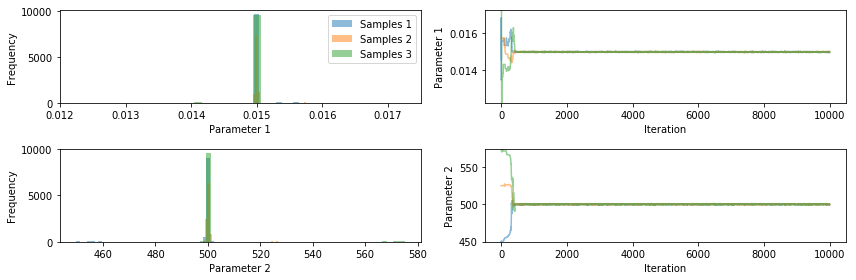

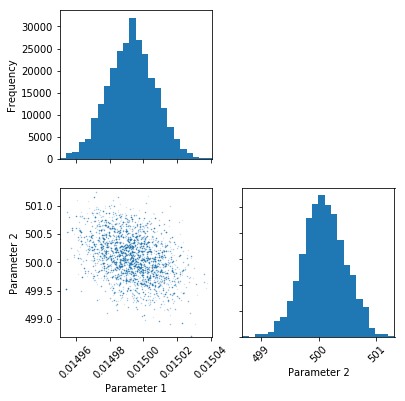

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

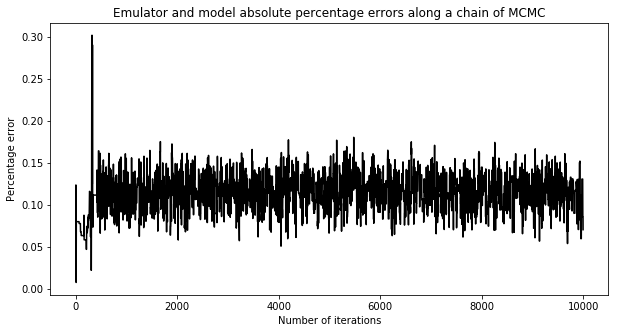

0.11445308666487736

In [27]:
chain = chains[0]
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

Running...
[3.09078500e-02 4.52217541e+02]
-inf


[9.94090443e-03 5.25511535e+02]
-inf


[2.59410314e-02 5.75705106e+02]
-inf


[-1.76864251e-03  4.51286297e+02]
-inf


[2.66492983e-02 5.22993939e+02]
-inf


[3.69337151e-02 5.79142995e+02]
-inf


[2.45715155e-02 4.48607914e+02]
-inf


[1.12635382e-02 5.23428045e+02]
-62939.0234375


[1.26951546e-03 5.71208632e+02]
-inf


[1.00386356e-02 4.51751351e+02]
-139996.28125


[5.73182745e-03 5.30879860e+02]
-inf


[1.45021322e-02 5.73776896e+02]
-21062.83984375
accepted


[4.10764752e-04 4.50303185e+02]
-inf


[3.58591735e-02 5.25514936e+02]
-inf


[1.76714806e-02 5.73777467e+02]
-62662.69140625


[2.59303768e-02 4.52508081e+02]
-inf


[-2.75974727e-03  5.24937773e+02]
-inf


[1.12330003e-02 5.70347220e+02]
-62461.5078125


[1.41635106e-02 4.49294001e+02]
-17676.431640625
accepted


[1.39184898e-02 5.25690035e+02]
-5298.90087890625
accepted


[-1.07994621e-03  5.75708538e+02]
-inf


[-1.21509558e-02  4.46614937e+02]
-inf


[-1.95044159e-02  5.

-inf


[1.26962559e-02 5.19395591e+02]
-20255.447265625


[2.17889903e-02 5.68948201e+02]
-inf


[1.15057351e-02 4.56975966e+02]
-76413.0703125


[9.82142786e-03 5.21223312e+02]
-inf


[-5.63639907e-03  5.69537867e+02]
-inf


[3.55991021e-02 4.51502245e+02]
-inf


[6.94305802e-03 5.21394497e+02]
-inf


[1.25539830e-02 5.74352027e+02]
-29381.2265625


[-1.58425441e-03  4.51784571e+02]
-inf


[1.11401542e-02 5.24440255e+02]
-67777.890625


[3.14287733e-02 5.71225736e+02]
-inf


[3.21175806e-02 4.50727011e+02]
-inf


[1.77183579e-02 5.21047983e+02]
-25311.755859375


[3.56367952e-03 5.71983382e+02]
-inf


[1.09828633e-02 4.56453272e+02]
-98364.34375


[-1.74925013e-03  5.21282689e+02]
-inf


[2.19976550e-02 5.70062873e+02]
-inf


[1.25940765e-02 4.54829509e+02]
-40137.4296875


[1.67011259e-02 5.20990403e+02]
-14040.9443359375


[-9.23855932e-03  5.65268806e+02]
-inf


[3.72195324e-02 4.51120743e+02]
-inf


[8.65310062e-03 5.18948323e+02]
-inf


[1.85569039e-02 5.67268811e+02]
-72790.4375

[2.43897887e-03 5.22657677e+02]
-inf


[-3.04209732e-03  5.62766233e+02]
-inf


[2.10663184e-02 4.52418443e+02]
-inf


[1.18923971e-02 5.24572221e+02]
-38522.33203125


[3.13743155e-02 5.68108190e+02]
-inf


[2.67610354e-02 4.53544004e+02]
-inf


[9.93381543e-03 5.25702464e+02]
-inf


[3.77814383e-02 5.62662687e+02]
-inf


[2.52322336e-02 4.53402490e+02]
-inf


[1.69224473e-02 5.26683133e+02]
-18800.740234375


[2.69720511e-02 5.62867999e+02]
-inf


[4.66759069e-03 4.51740371e+02]
-inf


[5.99001427e-03 5.21618151e+02]
-inf


[2.09496669e-02 5.64250614e+02]
-inf


[5.41529048e-03 4.55915146e+02]
-inf


[2.66610494e-02 5.23462172e+02]
-inf


[9.73042966e-03 5.65647216e+02]
-inf


[2.23801783e-02 4.52968994e+02]
-inf


[3.11151957e-02 5.20785813e+02]
-inf


[-1.20423980e-02  5.70933285e+02]
-inf


[2.57473325e-02 4.50959187e+02]
-inf


[1.46118951e-03 5.19603371e+02]
-inf


[1.29847717e-02 5.61500945e+02]
-21039.62109375


[1.65958355e-02 4.52266724e+02]
-13004.4521484375


[2.25771609e-

[1.55690667e-02 4.66397976e+02]
-5583.68212890625


[1.50243950e-02 5.22564095e+02]
-3225.302978515625
accepted


[1.37704368e-02 5.65152557e+02]
-15279.0556640625
accepted


[1.55135287e-02 4.78095305e+02]
-3385.490478515625
accepted


[1.50168642e-02 5.22563299e+02]
-3227.927978515625
accepted


[1.37661255e-02 5.65148405e+02]
-15272.9619140625
accepted


[1.55196285e-02 4.82712947e+02]
-2829.189697265625
accepted


[1.50193889e-02 5.22563538e+02]
-3227.049072265625
accepted


[1.37784449e-02 5.65150083e+02]
-15287.1064453125


[1.54827818e-02 4.78650097e+02]
-3258.693603515625


[1.50271708e-02 5.22565875e+02]
-3224.556884765625
accepted


[1.37621632e-02 5.65149845e+02]
-15290.8603515625


[1.55352140e-02 4.87050935e+02]
-2560.892822265625
accepted


[1.50310004e-02 5.22565193e+02]
-3224.970947265625


[1.37647884e-02 5.65142311e+02]
-15276.0673828125


[1.55688863e-02 4.90327228e+02]
-2556.877197265625
accepted


[1.50382012e-02 5.22565740e+02]
-3249.724853515625


[1.37649173e-02

[1.55479254e-02 4.88315554e+02]
-2526.127197265625


[1.50302139e-02 5.22515266e+02]
-3215.927978515625


[1.37395287e-02 5.64217865e+02]
-14975.1142578125
accepted


[1.55353539e-02 4.89049403e+02]
-2475.119384765625
accepted


[1.50324014e-02 5.22463860e+02]
-3216.888916015625


[1.37333238e-02 5.64036086e+02]
-14948.4541015625
accepted


[1.55330392e-02 4.89578753e+02]
-2458.842041015625
accepted


[1.50286453e-02 5.22499104e+02]
-3213.756103515625
accepted


[1.37202078e-02 5.63623906e+02]
-14885.2548828125
accepted


[1.55443682e-02 4.91480296e+02]
-2507.162353515625


[1.50300903e-02 5.22510372e+02]
-3214.959228515625


[1.37203275e-02 5.63605867e+02]
-14878.3427734375
accepted


[1.55403014e-02 4.91190743e+02]
-2488.521728515625


[1.50266018e-02 5.22490236e+02]
-3213.146728515625
accepted


[1.36989876e-02 5.62932880e+02]
-14791.9892578125
accepted


[1.55249821e-02 4.88895660e+02]
-2455.021728515625
accepted


[1.50284805e-02 5.22480768e+02]
-3211.002197265625
accepted


[1.36

[1.35559632e-02 5.58364486e+02]
-14306.1376953125


[1.45309802e-02 4.90769620e+02]
-2077.510009765625


[1.50361411e-02 4.91032753e+02]
-1581.7249755859375


[1.36080258e-02 5.60032986e+02]
-14484.7900390625


[1.46787184e-02 4.90574935e+02]
-1599.2327880859375


[1.50349440e-02 4.96921064e+02]
-1474.1351318359375


[1.34784411e-02 5.55874294e+02]
-14257.0478515625


[1.50425481e-02 4.91276806e+02]
-1587.1312255859375


[1.50381102e-02 4.91575722e+02]
-1574.8031005859375


[1.35512931e-02 5.58206852e+02]
-14287.5302734375


[1.46472705e-02 4.91092095e+02]
-1674.4866943359375


[1.50347869e-02 4.93949516e+02]
-1526.1195068359375


[1.35081257e-02 5.56847794e+02]
-14218.6787109375


[1.48713706e-02 4.89771887e+02]
-1362.4398193359375


[1.50334187e-02 5.03977512e+02]
-1415.7991943359375
accepted


[1.35642675e-02 5.58622950e+02]
-14332.1513671875


[1.49933493e-02 4.90169033e+02]
-1531.6077880859375


[1.50330789e-02 5.05723424e+02]
-1502.0804443359375


[1.35394178e-02 5.57830872e+02]


[1.48236877e-02 4.91163184e+02]
-1268.9163818359375


[1.50316414e-02 5.04697349e+02]
-1440.4241943359375


[1.35248920e-02 5.57367163e+02]
-14198.9951171875


[1.47804087e-02 4.91221476e+02]
-1321.9749755859375


[1.50308742e-02 5.03256031e+02]
-1416.7171630859375


[1.35211356e-02 5.57244045e+02]
-14193.3076171875


[1.48628356e-02 4.91041108e+02]
-1323.7952880859375


[1.50316390e-02 5.04728755e+02]
-1442.1195068359375


[1.35232719e-02 5.57315462e+02]
-14193.5263671875
accepted


[1.47643876e-02 4.91061618e+02]
-1364.6156005859375


[1.50308569e-02 5.04901208e+02]
-1450.2171630859375


[1.35250509e-02 5.57370404e+02]
-14198.9619140625


[1.48047424e-02 4.90990080e+02]
-1270.4984130859375


[1.50327169e-02 5.04084328e+02]
-1417.1859130859375


[1.35216157e-02 5.57262874e+02]
-14193.5361328125


[1.47655239e-02 4.91222969e+02]
-1357.3890380859375


[1.50322922e-02 5.03631157e+02]
-1416.4046630859375


[1.35214962e-02 5.57258013e+02]
-14193.4345703125
accepted


[1.47622545e-02 4.9124

accepted


[1.48046606e-02 4.91248223e+02]
-1263.4632568359375


[1.50222902e-02 5.03468314e+02]
-1400.3851318359375
accepted


[1.35240194e-02 5.57302745e+02]
-14184.1533203125


[1.48048404e-02 4.91295066e+02]
-1261.7249755859375


[1.50219238e-02 5.03758974e+02]
-1397.6273193359375
accepted


[1.35244510e-02 5.57320495e+02]
-14186.9287109375


[1.48036462e-02 4.91199633e+02]
-1267.2366943359375


[1.50227573e-02 5.03098784e+02]
-1403.9124755859375


[1.35226233e-02 5.57260553e+02]
-14182.2958984375


[1.48142743e-02 4.91235887e+02]
-1254.8070068359375


[1.50211111e-02 5.04206464e+02]
-1404.1820068359375


[1.35188649e-02 5.57139899e+02]
-14187.8701171875


[1.48050917e-02 4.91221286e+02]
-1263.1859130859375


[1.50226036e-02 5.04409380e+02]
-1413.6898193359375


[1.35268855e-02 5.57391440e+02]
-14192.9775390625


[1.48170404e-02 4.91206856e+02]
-1259.1077880859375


[1.50214694e-02 5.03954456e+02]
-1395.7015380859375
accepted


[1.35220549e-02 5.57229917e+02]
-14179.6455078125
acce

[1.48137240e-02 4.91159753e+02]
-1255.9320068359375


[1.47886395e-02 5.02492318e+02]
-1344.6038818359375


[1.37815134e-02 5.51281674e+02]
-10870.6748046875


[1.48105777e-02 4.91079717e+02]
-1258.1507568359375


[1.48223436e-02 5.03143478e+02]
-1308.8577880859375


[1.37705712e-02 5.51451580e+02]
-10935.3330078125


[1.48089249e-02 4.91186476e+02]
-1255.0374755859375
accepted


[1.48943303e-02 5.03640986e+02]
-1212.2562255859375


[1.38195027e-02 5.50357015e+02]
-10547.1337890625
accepted


[1.48080637e-02 4.91191883e+02]
-1256.9359130859375
accepted


[1.49252747e-02 5.03674166e+02]
-1241.7445068359375


[1.37473029e-02 5.52096230e+02]
-11156.6904296875


[1.48109868e-02 4.91217412e+02]
-1251.6976318359375
accepted


[1.48794514e-02 5.03301539e+02]
-1217.7132568359375


[1.38521978e-02 5.49577295e+02]
-10279.3349609375
accepted


[1.48082825e-02 4.91197032e+02]
-1256.2640380859375


[1.49168179e-02 5.03356520e+02]
-1220.4671630859375


[1.39980432e-02 5.46136171e+02]
-9202.545898437

[1.48270356e-02 4.93355374e+02]
-1228.7757568359375
accepted


[1.48938351e-02 5.03197030e+02]
-1189.7093505859375


[1.53305980e-02 5.15489402e+02]
-3436.177978515625


[1.48286370e-02 4.93577819e+02]
-1227.2484130859375
accepted


[1.48860125e-02 5.03234987e+02]
-1202.4593505859375


[1.49065828e-02 5.25160892e+02]
-3816.267822265625


[1.48317645e-02 4.94101105e+02]
-1222.7054443359375
accepted


[1.48723602e-02 5.03101350e+02]
-1221.0804443359375


[1.48193696e-02 5.27263659e+02]
-4300.17431640625


[1.48298896e-02 4.94099411e+02]
-1221.5296630859375
accepted


[1.49057202e-02 5.03247239e+02]
-1204.9476318359375


[1.54412442e-02 5.13028100e+02]
-3565.611572265625


[1.48292471e-02 4.94238678e+02]
-1222.9398193359375


[1.48993189e-02 5.03161878e+02]
-1196.0726318359375


[1.56407006e-02 5.08371541e+02]
-3781.150634765625


[1.48261662e-02 4.93676411e+02]
-1225.6468505859375


[1.48995136e-02 5.03272773e+02]
-1196.0531005859375


[1.53135826e-02 5.15907806e+02]
-3421.709228515625



[1.48809876e-02 5.01393498e+02]
-1176.9554443359375


[1.48930622e-02 5.03250708e+02]
-1191.8812255859375


[1.48120051e-02 5.27373292e+02]
-4326.45947265625


[1.48671778e-02 4.99226733e+02]
-1185.3070068359375


[1.49048304e-02 5.03349696e+02]
-1203.7327880859375


[1.51190054e-02 5.20345402e+02]
-3244.236572265625


[1.48883919e-02 5.02401106e+02]
-1183.6156005859375


[1.48927905e-02 5.03290053e+02]
-1193.4476318359375


[1.51136202e-02 5.20482033e+02]
-3243.158447265625


[1.48483959e-02 4.96667214e+02]
-1202.5570068359375


[1.48922882e-02 5.03176536e+02]
-1191.7210693359375


[1.52362794e-02 5.17651197e+02]
-3337.017822265625


[1.48964222e-02 5.03522462e+02]
-1201.2874755859375


[1.48949069e-02 5.03310545e+02]
-1190.9710693359375
accepted


[1.49615539e-02 5.23974248e+02]
-3542.201416015625


[1.48792647e-02 5.01012152e+02]
-1174.7406005859375
accepted


[1.48893068e-02 5.03329484e+02]
-1202.0179443359375


[1.52162894e-02 5.18083303e+02]
-3312.861572265625


[1.48724469e-02 5

-1178.5452880859375


[1.48953143e-02 5.03207414e+02]
-1190.2366943359375
accepted


[1.50427396e-02 5.22031387e+02]
-3197.345947265625


[1.48912433e-02 5.02709154e+02]
-1185.7601318359375


[1.48999903e-02 5.03230339e+02]
-1196.8382568359375


[1.50503367e-02 5.21893449e+02]
-3205.834228515625


[1.48758764e-02 5.00574970e+02]
-1174.9671630859375
accepted


[1.48914809e-02 5.03186481e+02]
-1193.1468505859375


[1.50293401e-02 5.22347603e+02]
-3191.650634765625
accepted


[1.48691036e-02 4.99693954e+02]
-1181.8382568359375


[1.48940454e-02 5.03187834e+02]
-1189.2093505859375
accepted


[1.51164019e-02 5.20326160e+02]
-3232.881103515625


[1.48802235e-02 5.01217023e+02]
-1175.5101318359375


[1.48966622e-02 5.03183607e+02]
-1192.2288818359375


[1.49922357e-02 5.23209255e+02]
-3371.388916015625


[1.48712631e-02 4.99943310e+02]
-1179.4593505859375


[1.48966286e-02 5.03200816e+02]
-1192.1273193359375


[1.49870513e-02 5.23306752e+02]
-3393.611572265625


[1.48805364e-02 5.01202423e+02

[1.48799792e-02 5.01090748e+02]
-1175.2640380859375


[1.48929424e-02 5.03227005e+02]
-1191.6273193359375


[1.50229442e-02 5.22421859e+02]
-3203.974853515625


[1.48793437e-02 5.00913843e+02]
-1175.4124755859375
accepted


[1.48920272e-02 5.03203019e+02]
-1192.6038818359375


[1.49954126e-02 5.23072914e+02]
-3341.760009765625


[1.48826194e-02 5.01322233e+02]
-1177.5179443359375


[1.48949979e-02 5.03246717e+02]
-1189.6859130859375
accepted


[1.50286796e-02 5.22288448e+02]
-3181.888916015625
accepted


[1.48784530e-02 5.00901756e+02]
-1174.2718505859375
accepted


[1.48944685e-02 5.03239062e+02]
-1189.4984130859375
accepted


[1.50054016e-02 5.22862871e+02]
-3294.299072265625


[1.48761815e-02 5.00505383e+02]
-1176.4632568359375


[1.48958861e-02 5.03232953e+02]
-1190.9866943359375
accepted


[1.50309027e-02 5.22237569e+02]
-3183.029541015625


[1.48802657e-02 5.01164665e+02]
-1175.2327880859375


[1.48950005e-02 5.03246891e+02]
-1189.6898193359375
accepted


[1.50301060e-02 5.222791

[1.48796746e-02 5.01329951e+02]
-1178.1077880859375


[1.48945441e-02 5.03208587e+02]
-1189.1429443359375
accepted


[1.50367956e-02 5.21718745e+02]
-3137.404541015625


[1.4876808e-02 5.0093828e+02]
-1176.7874755859375
accepted


[1.48953147e-02 5.03186989e+02]
-1190.3031005859375


[1.50480259e-02 5.21418824e+02]
-3137.744384765625


[1.48746267e-02 5.00572960e+02]
-1176.7952880859375
accepted


[1.48933125e-02 5.03214847e+02]
-1190.8382568359375


[1.50348846e-02 5.21745572e+02]
-3134.299072265625


[1.48771006e-02 5.00835715e+02]
-1174.7640380859375
accepted


[1.48930140e-02 5.03175248e+02]
-1190.5765380859375


[1.50275799e-02 5.21877555e+02]
-3126.115478515625
accepted


[1.48776325e-02 5.01098721e+02]
-1177.8929443359375


[1.48940593e-02 5.03186596e+02]
-1189.1702880859375
accepted


[1.50375074e-02 5.21652049e+02]
-3131.412353515625


[1.48797083e-02 5.01311938e+02]
-1177.7874755859375


[1.48930038e-02 5.03139733e+02]
-1189.9476318359375


[1.50282562e-02 5.21748509e+02]
-31



[1.52533199e-02 5.09003046e+02]
-2398.424072265625


[1.48864489e-02 5.01960666e+02]
-1180.9124755859375


[1.48854581e-02 5.01719961e+02]
-1180.1429443359375


[1.52338661e-02 5.09204231e+02]
-2351.830322265625


[1.48873784e-02 5.02254445e+02]
-1182.5062255859375


[1.48527746e-02 4.97507758e+02]
-1198.8343505859375


[1.54446060e-02 4.97872533e+02]
-2374.752197265625


[1.48816336e-02 5.01174971e+02]
-1177.0179443359375


[1.48852455e-02 5.01622951e+02]
-1180.0960693359375


[1.52379736e-02 5.09800694e+02]
-2431.912353515625


[1.48816160e-02 5.01427732e+02]
-1176.4554443359375
accepted


[1.48838845e-02 5.01584702e+02]
-1178.2562255859375


[1.53538167e-02 5.02648891e+02]
-2251.076416015625


[1.48840565e-02 5.01752384e+02]
-1178.4827880859375


[1.48815464e-02 5.01211798e+02]
-1176.6898193359375


[1.52890454e-02 5.06944999e+02]
-2302.424072265625


[1.48836704e-02 5.01721139e+02]
-1178.5101318359375


[1.48717500e-02 4.99769492e+02]
-1182.5452880859375


[1.52971736e-02 5.06121

[1.48762142e-02 5.00553745e+02]
-1175.6859130859375
accepted


[1.48805348e-02 5.01070319e+02]
-1176.1312255859375


[1.51794038e-02 5.04279082e+02]
-1784.8616943359375
accepted


[1.48770850e-02 5.00640874e+02]
-1175.4945068359375
accepted


[1.48785672e-02 5.00836890e+02]
-1174.9398193359375


[1.52140822e-02 5.02777683e+02]
-1839.5921630859375


[1.48783555e-02 5.00709901e+02]
-1176.2015380859375
accepted


[1.48815393e-02 5.01466710e+02]
-1177.1741943359375


[1.52206821e-02 5.00793489e+02]
-1812.3656005859375


[1.48829536e-02 5.01424100e+02]
-1177.3890380859375


[1.48736988e-02 5.00132837e+02]
-1179.1156005859375


[1.52264481e-02 4.99240020e+02]
-1805.8890380859375


[1.48801236e-02 5.01102282e+02]
-1175.3890380859375
accepted


[1.48904338e-02 5.02720587e+02]
-1186.2796630859375


[1.51954855e-02 5.04180837e+02]
-1829.2093505859375


[1.48812587e-02 5.01115612e+02]
-1176.8538818359375


[1.48682865e-02 4.99524864e+02]
-1182.4945068359375


[1.51076882e-02 5.08498632e+02]
-1905

[1.48710622e-02 5.00147687e+02]
-1180.4554443359375


[1.48771503e-02 5.00759808e+02]
-1173.7874755859375
accepted


[1.47470671e-02 4.98330613e+02]
-1384.6077880859375


[1.48765717e-02 5.00696742e+02]
-1174.3968505859375
accepted


[1.48760476e-02 5.00587179e+02]
-1174.8734130859375


[1.48936203e-02 5.01082627e+02]
-1197.1234130859375


[1.48746466e-02 5.00294456e+02]
-1177.7679443359375


[1.48798316e-02 5.01271494e+02]
-1176.9671630859375
accepted


[1.48568602e-02 5.00457895e+02]
-1206.9320068359375


[1.48767655e-02 5.00776784e+02]
-1174.5140380859375
accepted


[1.48824988e-02 5.01689967e+02]
-1179.7523193359375


[1.48944702e-02 4.99407048e+02]
-1222.1156005859375


[1.48749020e-02 5.00510279e+02]
-1176.1585693359375


[1.48769891e-02 5.00812358e+02]
-1174.5804443359375
accepted


[1.47847169e-02 4.98085650e+02]
-1315.8421630859375


[1.48788022e-02 5.00930509e+02]
-1174.5804443359375
accepted


[1.48807255e-02 5.01359930e+02]
-1176.8695068359375


[1.48726592e-02 4.99388875e+

[1.48786309e-02 5.00683087e+02]
-1177.0648193359375


[1.48763550e-02 5.00606307e+02]
-1175.0023193359375
accepted


[1.48899524e-02 5.01037474e+02]
-1191.5648193359375


[1.48803906e-02 5.01278763e+02]
-1176.1781005859375


[1.48749404e-02 5.00547662e+02]
-1176.2445068359375


[1.48335647e-02 5.00786867e+02]
-1250.8734130859375


[1.48770436e-02 5.00579640e+02]
-1176.4710693359375


[1.48776442e-02 5.00783363e+02]
-1173.9788818359375
accepted


[1.49079388e-02 5.01579387e+02]
-1217.7640380859375


[1.48788347e-02 5.00913223e+02]
-1174.7171630859375
accepted


[1.48741379e-02 5.00337536e+02]
-1176.6390380859375


[1.48856197e-02 5.01726314e+02]
-1180.3538818359375


[1.48784078e-02 5.00895869e+02]
-1174.2327880859375
accepted


[1.48819115e-02 5.01243432e+02]
-1177.0101318359375


[1.48812102e-02 5.01228920e+02]
-1176.1351318359375
accepted


[1.4877867e-02 5.0078415e+02]
-1174.3421630859375
accepted


[1.48783832e-02 5.00624388e+02]
-1177.6937255859375


[1.49054734e-02 5.02147867e+02

[1.48824709e-02 5.01208194e+02]
-1177.9593505859375


[1.48805997e-02 5.01218511e+02]
-1175.3851318359375
accepted


[1.49091020e-02 5.01687687e+02]
-1218.9593505859375


[1.48790895e-02 5.00798851e+02]
-1176.1859130859375
accepted


[1.48819103e-02 5.01452246e+02]
-1176.3538818359375


[1.49233855e-02 5.01550973e+02]
-1244.5101318359375


[1.48763578e-02 5.00376525e+02]
-1178.9046630859375


[1.48822501e-02 5.01452034e+02]
-1176.2835693359375
accepted


[1.48847041e-02 5.00594346e+02]
-1187.5609130859375


[1.48851144e-02 5.01538597e+02]
-1180.1156005859375


[1.48829200e-02 5.01719498e+02]
-1179.6429443359375


[1.49214005e-02 5.01128928e+02]
-1244.2366943359375


[1.48780581e-02 5.00815494e+02]
-1174.3265380859375
accepted


[1.48790859e-02 5.01142125e+02]
-1176.2093505859375
accepted


[1.48968826e-02 5.01588857e+02]
-1198.6937255859375


[1.48796038e-02 5.01078325e+02]
-1174.8304443359375
accepted


[1.48780614e-02 5.00881698e+02]
-1173.9085693359375
accepted


[1.48874968e-02 5.0

[1.48778936e-02 5.01085917e+02]
-1177.2835693359375


[1.48869051e-02 5.00369068e+02]
-1194.6077880859375


[1.48781134e-02 5.00391262e+02]
-1181.2484130859375


[1.48750140e-02 5.00633953e+02]
-1176.4554443359375
accepted


[1.48585209e-02 5.00038297e+02]
-1200.5843505859375


[1.48786061e-02 5.00676924e+02]
-1177.1351318359375
accepted


[1.48762234e-02 5.00655289e+02]
-1174.7601318359375
accepted


[1.48621649e-02 4.99832497e+02]
-1192.5804443359375


[1.48818559e-02 5.01215570e+02]
-1177.0882568359375
accepted


[1.48710871e-02 5.00145962e+02]
-1180.4046630859375


[1.48771208e-02 5.00601610e+02]
-1176.2210693359375
accepted


[1.48793901e-02 5.00441012e+02]
-1182.2952880859375


[1.48761434e-02 5.00876028e+02]
-1176.9124755859375


[1.48913859e-02 5.00985181e+02]
-1194.4671630859375


[1.48841930e-02 5.01442244e+02]
-1179.0726318359375


[1.48755595e-02 5.00622521e+02]
-1175.6077880859375


[1.48904348e-02 5.00717341e+02]
-1195.6859130859375


[1.48823727e-02 5.01293764e+02]
-1177



[1.48909933e-02 5.01437448e+02]
-1189.6976318359375


[1.48741077e-02 5.00614087e+02]
-1177.8226318359375


[1.48842165e-02 5.01954887e+02]
-1181.9202880859375


[1.48791863e-02 5.00891164e+02]
-1175.3890380859375


[1.48740834e-02 5.00044314e+02]
-1181.1937255859375


[1.48677372e-02 4.99846952e+02]
-1184.3734130859375


[1.48788454e-02 5.01043519e+02]
-1175.1038818359375
accepted


[1.48794863e-02 5.01118786e+02]
-1175.2093505859375


[1.48733732e-02 5.00215694e+02]
-1177.3109130859375
accepted


[1.48871003e-02 5.01134541e+02]
-1185.8577880859375


[1.48779688e-02 5.00761249e+02]
-1174.7601318359375
accepted


[1.48716187e-02 5.00073813e+02]
-1179.3616943359375


[1.48887482e-02 5.01227425e+02]
-1187.5999755859375


[1.48806904e-02 5.01001179e+02]
-1176.7288818359375
accepted


[1.48758334e-02 5.00477142e+02]
-1176.4241943359375
accepted


[1.48859515e-02 5.01102000e+02]
-1184.3109130859375


[1.48826761e-02 5.01086118e+02]
-1179.0960693359375


[1.48747929e-02 5.00205113e+02]
-11

[1.48761001e-02 5.00466344e+02]
-1177.0023193359375
accepted


[1.48812002e-02 5.01116100e+02]
-1176.7640380859375
accepted


[1.48813838e-02 5.01162413e+02]
-1176.7445068359375
accepted


[1.48790948e-02 5.00867643e+02]
-1175.4866943359375
accepted


[1.48745391e-02 5.00193755e+02]
-1179.3226318359375


[1.48792809e-02 5.01178810e+02]
-1176.4476318359375
accepted


[1.48855617e-02 5.01712130e+02]
-1180.3070068359375


[1.48775321e-02 5.00675641e+02]
-1175.5609130859375
accepted


[1.48770196e-02 5.01173598e+02]
-1180.0218505859375


[1.48777172e-02 5.00462314e+02]
-1179.4593505859375


[1.48785965e-02 5.00471874e+02]
-1180.5960693359375


[1.48787549e-02 5.01071657e+02]
-1175.6702880859375
accepted


[1.48784570e-02 5.00784063e+02]
-1175.2991943359375
accepted


[1.48815318e-02 5.01456483e+02]
-1177.0335693359375
accepted


[1.48771705e-02 5.01031732e+02]
-1177.6234130859375


[1.48817132e-02 5.01385144e+02]
-1175.9398193359375


[1.48834021e-02 5.01762544e+02]
-1179.6820068359375


[

[1.48735299e-02 5.00591182e+02]
-1178.6468505859375


[1.48776771e-02 5.00372021e+02]
-1180.9398193359375


[1.48686358e-02 5.00640362e+02]
-1187.7054443359375


[1.48780366e-02 5.00503234e+02]
-1179.2366943359375


[1.48828582e-02 5.01401672e+02]
-1177.3851318359375
accepted


[1.48770179e-02 5.00751028e+02]
-1173.9476318359375
accepted


[1.48783180e-02 5.00666064e+02]
-1176.8890380859375


[1.48767551e-02 5.00823221e+02]
-1175.1312255859375
accepted


[1.48782330e-02 5.00790969e+02]
-1174.8577880859375


[1.48710292e-02 5.00164701e+02]
-1180.5726318359375


[1.48739972e-02 5.00087318e+02]
-1180.3343505859375


[1.48715463e-02 5.00740261e+02]
-1183.4124755859375


[1.48800248e-02 5.00731901e+02]
-1178.4281005859375


[1.48814200e-02 5.01440062e+02]
-1176.9632568359375


[1.48746818e-02 5.00768218e+02]
-1178.1156005859375


[1.48773318e-02 5.00601548e+02]
-1176.5335693359375


[1.48716066e-02 5.00591316e+02]
-1182.0413818359375


[1.48768951e-02 5.00714881e+02]
-1173.9906005859375
acc

[1.48796463e-02 5.01190358e+02]
-1176.0335693359375


[1.48663715e-02 4.99758332e+02]
-1186.0960693359375


[1.48741009e-02 5.00333578e+02]
-1176.6702880859375
accepted


[1.48779482e-02 5.00879352e+02]
-1174.0491943359375
accepted


[1.48761743e-02 5.00721844e+02]
-1175.0882568359375
accepted


[1.48713291e-02 5.00277431e+02]
-1180.5452880859375
accepted


[1.48739939e-02 5.00623518e+02]
-1178.1038818359375


[1.48832353e-02 5.01144932e+02]
-1179.3929443359375


[1.48697674e-02 5.00194867e+02]
-1182.5374755859375
accepted


[1.48799044e-02 5.01055893e+02]
-1175.3616943359375


[1.48849907e-02 5.02026295e+02]
-1182.0296630859375


[1.48711951e-02 5.00179105e+02]
-1180.3695068359375
accepted


[1.48754813e-02 5.00581458e+02]
-1175.5765380859375
accepted


[1.48721472e-02 5.00200683e+02]
-1179.0531005859375


[1.48698519e-02 5.00094943e+02]
-1182.0531005859375


[1.48769518e-02 5.00817869e+02]
-1174.7288818359375
accepted


[1.48831633e-02 5.01381689e+02]
-1177.9163818359375


[1.4872411

[1.48753617e-02 5.00586525e+02]
-1175.7679443359375


[1.48816140e-02 5.01440666e+02]
-1176.6585693359375


[1.48758686e-02 5.00837774e+02]
-1176.7757568359375


[1.48764420e-02 5.00978237e+02]
-1177.9827880859375


[1.48831904e-02 5.01172714e+02]
-1179.1234130859375


[1.48801838e-02 5.01068971e+02]
-1175.6624755859375
accepted


[1.48797426e-02 5.00801092e+02]
-1177.2406005859375


[1.48855255e-02 5.02121185e+02]
-1182.9320068359375


[1.48795062e-02 5.01024526e+02]
-1174.9906005859375
accepted


[1.48794682e-02 5.00916960e+02]
-1175.5765380859375
accepted


[1.48828019e-02 5.01557761e+02]
-1176.8773193359375
accepted


[1.48799958e-02 5.01071019e+02]
-1175.3968505859375
accepted


[1.48777766e-02 5.00875678e+02]
-1174.2835693359375
accepted


[1.48840670e-02 5.01759241e+02]
-1178.5882568359375


[1.48797781e-02 5.01155673e+02]
-1175.3031005859375
accepted


[1.48781624e-02 5.01131703e+02]
-1177.5413818359375


[1.48835968e-02 5.01502204e+02]
-1178.0726318359375


[1.48810814e-02 5.0

[1.48749306e-02 5.00110248e+02]
-1181.3187255859375


[1.48764158e-02 5.00576576e+02]
-1175.5960693359375
accepted


[1.48800010e-02 5.00852703e+02]
-1177.1351318359375
accepted


[1.48787983e-02 5.00575987e+02]
-1179.1273193359375


[1.48801763e-02 5.01076294e+02]
-1175.6077880859375
accepted


[1.4878672e-02 5.0076231e+02]
-1175.8929443359375
accepted


[1.48796492e-02 5.00293747e+02]
-1185.1702880859375


[1.48757117e-02 5.00667501e+02]
-1175.5609130859375
accepted


[1.48801616e-02 5.00948259e+02]
-1176.3968505859375
accepted


[1.48819698e-02 5.00669633e+02]
-1182.2757568359375


[1.48741710e-02 5.00131087e+02]
-1179.8460693359375


[1.48768775e-02 5.00703970e+02]
-1174.1195068359375
accepted


[1.48684274e-02 4.99783696e+02]
-1183.1273193359375


[1.48708751e-02 5.00137469e+02]
-1180.6937255859375


[1.48769421e-02 5.00609316e+02]
-1175.8187255859375


[1.48878036e-02 5.01786504e+02]
-1183.3070068359375


[1.48869479e-02 5.01968934e+02]
-1181.6038818359375


[1.48753756e-02 5.005

[1.48791156e-02 5.00942201e+02]
-1174.9398193359375
accepted


[1.48707115e-02 4.99827433e+02]
-1180.0257568359375


[1.48791637e-02 5.01211712e+02]
-1177.1390380859375
accepted


[1.48795902e-02 5.01020953e+02]
-1175.1351318359375
accepted


[1.48820933e-02 5.01479398e+02]
-1176.5374755859375
accepted


[1.48819836e-02 5.01814681e+02]
-1182.8148193359375


[1.48814215e-02 5.01081977e+02]
-1177.2523193359375


[1.48726490e-02 5.00334287e+02]
-1178.8148193359375


[1.48887732e-02 5.02657003e+02]
-1187.6820068359375


[1.48771852e-02 5.00792975e+02]
-1173.9788818359375
accepted


[1.48947003e-02 5.03117948e+02]
-1189.5999755859375


[1.48747940e-02 5.00689816e+02]
-1177.2562255859375
accepted


[1.48771874e-02 5.00758076e+02]
-1173.7249755859375
accepted


[1.48879227e-02 5.02036428e+02]
-1182.8148193359375


[1.48803381e-02 5.01439481e+02]
-1178.6937255859375


[1.48778892e-02 5.00715264e+02]
-1175.4163818359375


[1.48808867e-02 5.01174085e+02]
-1176.0140380859375
accepted


[1.4876135


[1.48821824e-02 5.01537886e+02]
-1177.4710693359375


[1.48764142e-02 5.00705659e+02]
-1174.6663818359375
accepted


[1.48739590e-02 5.00317551e+02]
-1176.8265380859375


[1.48724371e-02 4.99988413e+02]
-1179.7406005859375


[1.48772731e-02 5.00848105e+02]
-1174.6741943359375
accepted


[1.48748578e-02 5.00583735e+02]
-1176.4984130859375


[1.48711027e-02 5.00130241e+02]
-1180.3304443359375


[1.48776676e-02 5.00855758e+02]
-1174.1546630859375
accepted


[1.48832105e-02 5.01114963e+02]
-1179.6702880859375


[1.48810810e-02 5.01276175e+02]
-1175.7015380859375
accepted


[1.48762370e-02 5.00904071e+02]
-1177.1898193359375


[1.48837286e-02 5.01488208e+02]
-1178.2913818359375


[1.48839315e-02 5.01661503e+02]
-1178.1156005859375


[1.48768603e-02 5.00892820e+02]
-1176.0140380859375


[1.48806268e-02 5.01297662e+02]
-1176.0804443359375


[1.48798995e-02 5.01141326e+02]
-1174.8773193359375
accepted


[1.48751821e-02 5.00718600e+02]
-1176.8109130859375


[1.48806464e-02 5.01324423e+02]
-117

[1.48706249e-02 5.00181418e+02]
-1181.2249755859375


[1.48706660e-02 5.00126548e+02]
-1180.9593505859375


[1.48767224e-02 5.00767660e+02]
-1174.5140380859375
accepted


[1.48706107e-02 5.00471103e+02]
-1182.7835693359375


[1.48737942e-02 5.00281655e+02]
-1176.9281005859375
accepted


[1.48767477e-02 5.00700114e+02]
-1174.1507568359375
accepted


[1.48800481e-02 5.00858907e+02]
-1177.1429443359375
accepted


[1.48783808e-02 5.01230423e+02]
-1178.6820068359375


[1.48765236e-02 5.00631605e+02]
-1174.8265380859375


[1.48757330e-02 5.00440854e+02]
-1176.8929443359375
accepted


[1.48753370e-02 5.00401257e+02]
-1176.9788818359375
accepted


[1.48787528e-02 5.00761066e+02]
-1176.0374755859375


[1.48669098e-02 4.99632061e+02]
-1184.8890380859375


[1.48737258e-02 5.00090534e+02]
-1179.8812255859375


[1.48765125e-02 5.00753236e+02]
-1174.7640380859375
accepted


[1.48844177e-02 5.01366163e+02]
-1179.6976318359375
accepted


[1.48704869e-02 4.99677599e+02]
-1182.3031005859375


[1.4876158

-1176.2484130859375
accepted


[1.48834299e-02 5.01026776e+02]
-1180.9515380859375


[1.48844969e-02 5.01619883e+02]
-1179.0374755859375


[1.48774047e-02 5.00737463e+02]
-1174.3226318359375
accepted


[1.48791938e-02 5.00773532e+02]
-1176.6234130859375
accepted


[1.48696856e-02 5.00204308e+02]
-1182.6898193359375


[1.48846961e-02 5.01805700e+02]
-1178.8304443359375


[1.48763028e-02 5.00424810e+02]
-1178.0023193359375


[1.48852251e-02 5.01724775e+02]
-1179.7913818359375


[1.48725764e-02 5.00488421e+02]
-1179.5062255859375


[1.48815264e-02 5.01105982e+02]
-1177.2679443359375
accepted


[1.48807984e-02 5.01226791e+02]
-1175.5999755859375
accepted


[1.48797694e-02 5.00935468e+02]
-1175.8812255859375
accepted


[1.48770599e-02 5.00677077e+02]
-1174.8421630859375
accepted


[1.48900915e-02 5.02028247e+02]
-1185.9202880859375


[1.48804614e-02 5.01206230e+02]
-1175.2601318359375
accepted


[1.48763079e-02 5.00661595e+02]
-1174.6546630859375
accepted


[1.48768290e-02 5.00882391e+02]
-

[1.48801857e-02 5.01262459e+02]
-1176.2562255859375
accepted


[1.48739532e-02 5.00337648e+02]
-1176.9124755859375


[1.48743051e-02 5.00324070e+02]
-1176.7640380859375


[1.48825867e-02 5.01704970e+02]
-1179.8890380859375


[1.48792597e-02 5.01199210e+02]
-1176.7874755859375


[1.48734397e-02 5.00343955e+02]
-1177.6898193359375


[1.48790164e-02 5.01159606e+02]
-1176.5804443359375
accepted


[1.48784306e-02 5.00518663e+02]
-1179.5531005859375


[1.48767002e-02 5.00681044e+02]
-1174.2445068359375
accepted


[1.48738185e-02 5.00593065e+02]
-1178.1546630859375


[1.48773143e-02 5.00990201e+02]
-1176.7562255859375
accepted


[1.48776047e-02 5.00825600e+02]
-1173.7913818359375
accepted


[1.48764882e-02 5.01382996e+02]
-1184.0491943359375


[1.48728157e-02 5.00440136e+02]
-1178.9632568359375


[1.48795384e-02 5.01105512e+02]
-1174.9202880859375
accepted


[1.48809417e-02 5.01188981e+02]
-1176.0062255859375
accepted


[1.48694208e-02 5.00121985e+02]
-1182.7796630859375


[1.48785312e-02 5.0

[1.48689478e-02 4.99766684e+02]
-1182.3031005859375


[1.48758256e-02 5.00333117e+02]
-1178.8656005859375


[1.48768700e-02 5.00896168e+02]
-1176.0531005859375


[1.48801864e-02 5.01001054e+02]
-1176.0491943359375


[1.48795715e-02 5.01186389e+02]
-1176.0960693359375
accepted


[1.48820321e-02 5.01398199e+02]
-1176.2874755859375


[1.48736968e-02 5.00223404e+02]
-1177.5765380859375


[1.48791875e-02 5.01452354e+02]
-1180.7445068359375


[1.48804504e-02 5.01160897e+02]
-1175.5023193359375


[1.48794165e-02 5.01061840e+02]
-1174.6663818359375
accepted


[1.48878920e-02 5.02082147e+02]
-1182.6468505859375


[1.48797021e-02 5.01090669e+02]
-1174.8929443359375
accepted


[1.48759106e-02 5.00575829e+02]
-1174.9202880859375


[1.48787174e-02 5.01006235e+02]
-1174.7366943359375
accepted


[1.48797651e-02 5.01060142e+02]
-1175.1429443359375
accepted


[1.48768446e-02 5.00415836e+02]
-1178.9593505859375


[1.48811054e-02 5.01307490e+02]
-1175.5531005859375
accepted


[1.48766782e-02 5.00681498e+

-1174.7991943359375
accepted


[1.48870162e-02 5.01753692e+02]
-1182.2718505859375
accepted


[1.48809170e-02 5.01140612e+02]
-1176.2445068359375


[1.48795808e-02 5.01191800e+02]
-1176.1663818359375


[1.48712459e-02 5.00037529e+02]
-1179.7952880859375
accepted


[1.48861411e-02 5.01916101e+02]
-1180.5921630859375


[1.48791961e-02 5.01228675e+02]
-1177.3382568359375


[1.48642487e-02 4.98527305e+02]
-1193.1976318359375


[1.48704160e-02 5.00037979e+02]
-1181.0218505859375


[1.48783969e-02 5.00882552e+02]
-1174.3109130859375
accepted


[1.48679785e-02 4.99218955e+02]
-1186.6077880859375


[1.48736256e-02 5.00421864e+02]
-1177.7132568359375


[1.48825347e-02 5.01280467e+02]
-1177.6390380859375


[1.48629455e-02 4.98647855e+02]
-1189.1898193359375


[1.48759907e-02 5.00487911e+02]
-1176.4749755859375
accepted


[1.48811001e-02 5.01358026e+02]
-1176.2327880859375


[1.48758888e-02 5.00742268e+02]
-1175.7679443359375
accepted


[1.48840731e-02 5.01501039e+02]
-1178.7484130859375


[1.488


[1.48862157e-02 5.02134665e+02]
-1182.1077880859375


[1.48748250e-02 5.00319774e+02]
-1177.6077880859375


[1.48763157e-02 5.01027605e+02]
-1178.9398193359375


[1.48761037e-02 5.00271324e+02]
-1180.3265380859375


[1.48839304e-02 5.01680606e+02]
-1178.0726318359375


[1.48747897e-02 5.00682331e+02]
-1177.2015380859375
accepted


[1.48819907e-02 5.01368119e+02]
-1176.4124755859375
accepted


[1.48799440e-02 5.00727545e+02]
-1178.3421630859375


[1.48731547e-02 5.00349917e+02]
-1178.1312255859375


[1.48715959e-02 4.99931558e+02]
-1179.5023193359375


[1.48874500e-02 5.01662837e+02]
-1183.1273193359375


[1.48770919e-02 5.00805844e+02]
-1174.3226318359375
accepted


[1.48831851e-02 5.01504009e+02]
-1177.4749755859375
accepted


[1.48754392e-02 5.00333351e+02]
-1178.2835693359375


[1.48784823e-02 5.01140555e+02]
-1177.1585693359375
accepted


[1.48778293e-02 5.01117089e+02]
-1177.8538818359375


[1.48846270e-02 5.01814989e+02]
-1178.7523193359375


[1.48809697e-02 5.01565859e+02]
-117

[1.48816401e-02 5.01484473e+02]
-1177.3304443359375
accepted


[1.48774880e-02 5.01343855e+02]
-1181.8460693359375


[1.48825568e-02 5.01449127e+02]
-1176.7288818359375


[1.4890977e-02 5.0256871e+02]
-1185.7523193359375


[1.48723886e-02 4.99853253e+02]
-1182.0179443359375


[1.48760622e-02 5.00422070e+02]
-1177.6976318359375


[1.48774810e-02 5.01008878e+02]
-1176.7679443359375
accepted


[1.48717425e-02 4.99935817e+02]
-1179.6429443359375


[1.48766105e-02 5.00438496e+02]
-1178.2327880859375


[1.48840659e-02 5.01973116e+02]
-1182.4866943359375


[1.48772371e-02 5.01330245e+02]
-1182.0491943359375


[1.48825109e-02 5.01157965e+02]
-1178.2991943359375


[1.48850143e-02 5.01704992e+02]
-1179.5491943359375


[1.48755207e-02 5.00877208e+02]
-1177.9359130859375


[1.48765080e-02 5.00698532e+02]
-1174.5023193359375


[1.48850983e-02 5.01625597e+02]
-1179.8734130859375


[1.48792090e-02 5.00892707e+02]
-1175.4085693359375
accepted


[1.48730611e-02 5.00265517e+02]
-1177.9515380859375


[1.

[1.48808665e-02 5.01215850e+02]
-1175.7523193359375
accepted


[1.48761039e-02 5.00808018e+02]
-1175.9437255859375


[1.48824871e-02 5.01407993e+02]
-1176.8538818359375
accepted


[1.48783611e-02 5.00988368e+02]
-1175.0452880859375
accepted


[1.48747370e-02 5.00967145e+02]
-1180.5648193359375


[1.48833836e-02 5.01746309e+02]
-1179.4085693359375


[1.48752750e-02 5.00568779e+02]
-1175.8265380859375
accepted


[1.48731725e-02 5.00458653e+02]
-1178.5101318359375


[1.48844766e-02 5.01554367e+02]
-1179.1820068359375
accepted


[1.48747242e-02 5.00658164e+02]
-1177.1116943359375
accepted


[1.48896414e-02 5.02009056e+02]
-1185.3304443359375


[1.48838876e-02 5.01360101e+02]
-1179.0101318359375
accepted


[1.48738092e-02 5.00747245e+02]
-1179.4749755859375


[1.48727213e-02 5.00683217e+02]
-1180.8499755859375


[1.48862548e-02 5.01403826e+02]
-1182.1077880859375


[1.48784137e-02 5.00664916e+02]
-1177.0531005859375
accepted


[1.48763769e-02 5.01140471e+02]
-1180.5413818359375


[1.4883911

[1.48737538e-02 5.00322915e+02]
-1177.1468505859375


[1.48769824e-02 5.00672241e+02]
-1174.8070068359375
accepted


[1.48705837e-02 4.99851225e+02]
-1180.1624755859375


[1.48940856e-02 5.02845083e+02]
-1189.4515380859375


[1.48762586e-02 5.00317069e+02]
-1179.7718505859375


[1.48810649e-02 5.01137099e+02]
-1176.4554443359375


[1.48763597e-02 5.00772146e+02]
-1175.1898193359375
accepted


[1.48782354e-02 5.00518149e+02]
-1179.2757568359375


[1.48772264e-02 5.00867462e+02]
-1175.0374755859375


[1.48747820e-02 5.00551203e+02]
-1176.4945068359375
accepted


[1.48650368e-02 4.99498908e+02]
-1187.2210693359375


[1.48839937e-02 5.01535408e+02]
-1178.5452880859375


[1.48840256e-02 5.01741511e+02]
-1178.3304443359375
accepted


[1.48830069e-02 5.01670026e+02]
-1178.6038818359375


[1.48748230e-02 5.00511612e+02]
-1176.2796630859375


[1.48869270e-02 5.02014126e+02]
-1181.4554443359375


[1.48747780e-02 5.00583958e+02]
-1176.6156005859375
accepted


[1.48777240e-02 5.01059196e+02]
-1177

[1.48780609e-02 5.01132887e+02]
-1177.7171630859375


[1.48775496e-02 5.00663032e+02]
-1175.7991943359375
accepted


[1.48776348e-02 5.01173060e+02]
-1179.0218505859375


[1.48800410e-02 5.01263851e+02]
-1176.5140380859375


[1.48834876e-02 5.01243580e+02]
-1179.1234130859375


[1.48803723e-02 5.00944088e+02]
-1176.7874755859375
accepted


[1.48752314e-02 5.00606156e+02]
-1176.0374755859375


[1.48780378e-02 5.00683418e+02]
-1176.1898193359375
accepted


[1.48804784e-02 5.01538654e+02]
-1180.1077880859375


[1.48680494e-02 5.00105978e+02]
-1184.7601318359375


[1.48806737e-02 5.00946882e+02]
-1177.2484130859375
accepted


[1.48774791e-02 5.00780667e+02]
-1173.7366943359375
accepted


[1.48729919e-02 5.00292807e+02]
-1178.1546630859375


[1.48773002e-02 5.00542716e+02]
-1177.4866943359375


[1.48821881e-02 5.01228886e+02]
-1177.4632568359375


[1.48759366e-02 5.00805339e+02]
-1176.2171630859375
accepted


[1.48824405e-02 5.00902295e+02]
-1180.6234130859375


[1.48741550e-02 5.00377086e+

[1.48806647e-02 5.01018693e+02]
-1176.5882568359375


[1.48757399e-02 5.00827603e+02]
-1176.8343505859375
accepted


[1.48746223e-02 5.00606689e+02]
-1176.9320068359375
accepted


[1.48821891e-02 5.01370391e+02]
-1176.6663818359375


[1.48740217e-02 5.00744434e+02]
-1179.0804443359375


[1.48690230e-02 5.00064522e+02]
-1183.1781005859375


[1.48782467e-02 5.00739369e+02]
-1175.5452880859375
accepted


[1.48791901e-02 5.01146130e+02]
-1176.0999755859375
accepted


[1.48799891e-02 5.01310768e+02]
-1177.3148193359375


[1.48789100e-02 5.00906047e+02]
-1174.8577880859375
accepted


[1.48856730e-02 5.01528886e+02]
-1180.9476318359375


[1.48804531e-02 5.01109685e+02]
-1175.7952880859375
accepted


[1.48934045e-02 5.02352953e+02]
-1189.7757568359375


[1.48804729e-02 5.00821263e+02]
-1178.2366943359375


[1.48764047e-02 5.00547318e+02]
-1176.0804443359375
accepted


[1.48723226e-02 5.00147841e+02]
-1178.5960693359375


[1.48789238e-02 5.01015638e+02]
-1174.5491943359375
accepted


[1.4872789

-1175.4984130859375
accepted


[1.48833306e-02 5.01468490e+02]
-1177.7757568359375


[1.48733737e-02 5.00299371e+02]
-1177.6234130859375


[1.48877431e-02 5.01900838e+02]
-1182.9163818359375


[1.48911430e-02 5.02196484e+02]
-1186.9749755859375


[1.48741580e-02 5.00417905e+02]
-1176.9007568359375


[1.48803375e-02 5.01854196e+02]
-1186.0648193359375


[1.48800461e-02 5.01555307e+02]
-1181.0804443359375


[1.48790557e-02 5.00728332e+02]
-1176.9241943359375


[1.48777674e-02 5.01149839e+02]
-1178.4476318359375


[1.48795007e-02 5.01154042e+02]
-1175.7210693359375
accepted


[1.48834822e-02 5.01434518e+02]
-1178.0765380859375


[1.48741857e-02 5.00276787e+02]
-1177.3929443359375


[1.48766929e-02 5.00471702e+02]
-1177.7874755859375


[1.48719603e-02 5.00308067e+02]
-1179.7288818359375


[1.48740865e-02 5.00268733e+02]
-1177.3812255859375


[1.48869736e-02 5.02197454e+02]
-1182.0882568359375


[1.48716562e-02 5.00159721e+02]
-1179.6195068359375


[1.48812327e-02 5.00898817e+02]
-1178.6741

[1.48738408e-02 5.00517623e+02]
-1177.7484130859375


[1.48775361e-02 5.00846253e+02]
-1174.2132568359375
accepted


[1.48752076e-02 5.00726350e+02]
-1176.8304443359375
accepted


[1.48865123e-02 5.01789751e+02]
-1181.4554443359375


[1.48730565e-02 5.00597537e+02]
-1179.5335693359375


[1.48791195e-02 5.01206359e+02]
-1177.1312255859375


[1.48806604e-02 5.01260162e+02]
-1175.4593505859375


[1.48728229e-02 5.00077831e+02]
-1178.7562255859375


[1.48747766e-02 5.00663703e+02]
-1177.0687255859375
accepted


[1.48771678e-02 5.00808850e+02]
-1174.2484130859375
accepted


[1.48767953e-02 5.00780607e+02]
-1174.4945068359375
accepted


[1.48799175e-02 5.01160041e+02]
-1175.1351318359375
accepted


[1.48783259e-02 5.01182242e+02]
-1178.0374755859375


[1.48805930e-02 5.01355037e+02]
-1177.0101318359375


[1.48824779e-02 5.01375604e+02]
-1177.0296630859375


[1.48709602e-02 4.99926453e+02]
-1179.8538818359375


[1.48790283e-02 5.00924913e+02]
-1174.9202880859375
accepted


[1.48722870e-02 5.0

[1.48759107e-02 5.00649358e+02]
-1175.1976318359375


[1.48750496e-02 5.00984717e+02]
-1180.3265380859375


[1.48821631e-02 5.01378751e+02]
-1176.5882568359375


[1.48763146e-02 5.00802758e+02]
-1175.5296630859375
accepted


[1.48794662e-02 5.01267421e+02]
-1177.4906005859375
accepted


[1.4880151e-02 5.0124638e+02]
-1176.0726318359375


[1.48771361e-02 5.00915886e+02]
-1175.9202880859375
accepted


[1.48797301e-02 5.01279716e+02]
-1177.2601318359375
accepted


[1.48774278e-02 5.00674098e+02]
-1175.4398193359375
accepted


[1.48745007e-02 5.00737784e+02]
-1178.1781005859375


[1.48851609e-02 5.01776518e+02]
-1179.5687255859375
accepted


[1.48763680e-02 5.00427427e+02]
-1178.0570068359375


[1.48818118e-02 5.01683998e+02]
-1180.6976318359375


[1.48814579e-02 5.01498778e+02]
-1177.8734130859375
accepted


[1.48778308e-02 5.00861228e+02]
-1173.9710693359375
accepted


[1.48815907e-02 5.01762611e+02]
-1182.4788818359375


[1.48821557e-02 5.01874398e+02]
-1183.6351318359375


[1.48773707e

[1.48788058e-02 5.00601255e+02]
-1178.7093505859375


[1.48735660e-02 5.00605336e+02]
-1178.6976318359375


[1.48826397e-02 5.01455408e+02]
-1176.8304443359375
accepted


[1.48841665e-02 5.02175684e+02]
-1186.0218505859375


[1.48726947e-02 5.00013391e+02]
-1179.6820068359375


[1.48842355e-02 5.01817748e+02]
-1179.3968505859375


[1.48778870e-02 5.00630331e+02]
-1176.8577880859375


[1.48739712e-02 5.00298018e+02]
-1176.7327880859375


[1.48829458e-02 5.01452169e+02]
-1177.2718505859375


[1.48797749e-02 5.00781000e+02]
-1177.5062255859375


[1.48738443e-02 5.00420817e+02]
-1177.3773193359375


[1.48850416e-02 5.01917304e+02]
-1179.9710693359375


[1.48837327e-02 5.01455418e+02]
-1178.3812255859375


[1.48686145e-02 4.99578145e+02]
-1182.1741943359375


[1.48858201e-02 5.01848778e+02]
-1180.3148193359375


[1.48764117e-02 5.00683181e+02]
-1174.5882568359375
accepted


[1.48757243e-02 5.00858610e+02]
-1177.3304443359375


[1.48831003e-02 5.01073424e+02]
-1179.9163818359375


[1.4883048


[1.48785931e-02 5.00952760e+02]
-1174.1741943359375
accepted


[1.48770454e-02 5.00304834e+02]
-1181.1468505859375


[1.48802477e-02 5.00902561e+02]
-1177.0140380859375


[1.48777565e-02 5.00862185e+02]
-1174.1038818359375
accepted


[1.48750358e-02 5.00510872e+02]
-1175.9671630859375
accepted


[1.48812045e-02 5.01164444e+02]
-1176.4984130859375


[1.48798282e-02 5.00921773e+02]
-1176.1234130859375


[1.48796873e-02 5.01095322e+02]
-1174.8421630859375
accepted


[1.48782909e-02 5.00780102e+02]
-1175.0726318359375


[1.48812878e-02 5.01318020e+02]
-1175.7445068359375


[1.48780099e-02 5.00821640e+02]
-1174.1781005859375
accepted


[1.48789799e-02 5.00984665e+02]
-1174.5179443359375
accepted


[1.48768295e-02 5.00754240e+02]
-1174.2406005859375
accepted


[1.48789233e-02 5.00846823e+02]
-1175.4202880859375
accepted


[1.48739227e-02 5.00624242e+02]
-1178.2366943359375
accepted


[1.48895534e-02 5.02326709e+02]
-1184.3616943359375


[1.48809441e-02 5.01411578e+02]
-1177.2952880859375




[1.48757894e-02 5.00495875e+02]
-1176.0452880859375


[1.48812197e-02 5.01298422e+02]
-1175.7640380859375


[1.48804739e-02 5.01265770e+02]
-1175.8382568359375


[1.48786175e-02 5.00873744e+02]
-1174.6468505859375
accepted


[1.48736388e-02 5.00007473e+02]
-1181.1702880859375


[1.48794691e-02 5.01044966e+02]
-1174.8343505859375
accepted


[1.48736945e-02 5.00143368e+02]
-1178.9359130859375


[1.48734492e-02 5.00232053e+02]
-1177.2484130859375


[1.48782099e-02 5.00625222e+02]
-1177.4202880859375


[1.48828580e-02 5.00737551e+02]
-1183.0296630859375


[1.48719884e-02 5.00329733e+02]
-1179.7718505859375


[1.48875680e-02 5.01963213e+02]
-1182.4984130859375


[1.48845668e-02 5.01662327e+02]
-1179.0296630859375


[1.48781527e-02 5.00878837e+02]
-1173.9984130859375
accepted


[1.48830490e-02 5.01738188e+02]
-1179.7796630859375


[1.48788013e-02 5.01566460e+02]
-1183.2054443359375


[1.48722059e-02 5.00154067e+02]
-1178.7874755859375


[1.48764204e-02 5.01199907e+02]
-1181.3773193359375


[

[1.48713524e-02 5.00119529e+02]
-1179.9241943359375


[1.48801416e-02 5.01318934e+02]
-1177.1859130859375
accepted


[1.48750604e-02 5.00574531e+02]
-1176.1741943359375
accepted


[1.48806987e-02 5.01269456e+02]
-1175.5374755859375
accepted


[1.48807618e-02 5.01168405e+02]
-1175.8851318359375
accepted


[1.48764576e-02 5.00342991e+02]
-1179.6273193359375


[1.48753282e-02 5.00950006e+02]
-1179.3538818359375


[1.48771843e-02 5.00846417e+02]
-1174.7913818359375
accepted


[1.48770856e-02 5.00832944e+02]
-1174.7406005859375
accepted


[1.48884473e-02 5.01879863e+02]
-1183.9788818359375


[1.48817835e-02 5.01220053e+02]
-1176.9710693359375


[1.48812530e-02 5.00950126e+02]
-1178.1702880859375


[1.48801693e-02 5.00830837e+02]
-1177.6351318359375


[1.48797132e-02 5.01354195e+02]
-1178.4124755859375


[1.48801644e-02 5.00976865e+02]
-1176.1546630859375


[1.48748067e-02 5.00454628e+02]
-1176.0960693359375


[1.48780829e-02 5.00752343e+02]
-1175.0726318359375


[1.48694693e-02 4.99499128e+

[1.48818195e-02 5.01276174e+02]
-1176.6976318359375
accepted


[1.48781892e-02 5.00702191e+02]
-1176.0882568359375
accepted


[1.48759851e-02 5.00154483e+02]
-1182.1312255859375


[1.48859832e-02 5.01536814e+02]
-1181.3734130859375


[1.48743542e-02 5.00402970e+02]
-1176.5609130859375


[1.48827276e-02 5.01153253e+02]
-1178.6156005859375


[1.48850164e-02 5.01751966e+02]
-1179.4241943359375


[1.48778675e-02 5.00800906e+02]
-1174.1585693359375
accepted


[1.48792023e-02 5.01096888e+02]
-1175.3343505859375
accepted


[1.48847857e-02 5.01533318e+02]
-1179.6741943359375


[1.48809821e-02 5.01106290e+02]
-1176.5296630859375


[1.48750521e-02 5.00155988e+02]
-1180.7210693359375


[1.48803147e-02 5.01236514e+02]
-1175.6624755859375
accepted


[1.48773486e-02 5.01242588e+02]
-1180.5335693359375


[1.48800129e-02 5.01363595e+02]
-1178.0648193359375


[1.48850965e-02 5.01419548e+02]
-1180.4163818359375


[1.48805555e-02 5.00845023e+02]
-1178.1234130859375


[1.48785456e-02 5.01164934e+02]
-1177


[1.48739055e-02 5.00621003e+02]
-1178.2406005859375


[1.48787348e-02 5.01129426e+02]
-1176.5804443359375


[1.48821629e-02 5.01216811e+02]
-1177.4906005859375


[1.48832476e-02 5.01131194e+02]
-1179.5531005859375


[1.48668007e-02 4.99378130e+02]
-1184.2054443359375


[1.48814114e-02 5.01438181e+02]
-1176.9437255859375
accepted


[1.48822649e-02 5.00975100e+02]
-1179.5804443359375


[1.48676206e-02 4.99737924e+02]
-1184.1820068359375


[1.48876788e-02 5.01679061e+02]
-1183.4007568359375


[1.48750550e-02 5.00441779e+02]
-1175.8812255859375
accepted


[1.48791042e-02 5.01166074e+02]
-1176.5491943359375


[1.48861508e-02 5.01821890e+02]
-1180.8577880859375


[1.48728577e-02 5.00453639e+02]
-1178.9554443359375


[1.48766652e-02 5.00161139e+02]
-1183.0218505859375


[1.48836817e-02 5.01476506e+02]
-1178.2562255859375


[1.48728737e-02 5.00230626e+02]
-1178.0999755859375


[1.48827902e-02 5.01518449e+02]
-1176.8734130859375
accepted


[1.48757170e-02 5.00707626e+02]
-1175.7757568359375
ac

[1.48735568e-02 5.00055005e+02]
-1180.2249755859375


[1.48736310e-02 5.00736029e+02]
-1179.7015380859375


[1.48746336e-02 5.00610128e+02]
-1176.9320068359375


[1.48789173e-02 5.00527448e+02]
-1180.1312255859375


[1.48806551e-02 5.01161117e+02]
-1175.7718505859375


[1.48743288e-02 5.00687481e+02]
-1178.0570068359375


[1.48693563e-02 4.99713966e+02]
-1181.5257568359375


[1.48785844e-02 5.00765067e+02]
-1175.7093505859375


[1.48769586e-02 5.00785317e+02]
-1174.2484130859375
accepted


[1.48777385e-02 5.00931272e+02]
-1175.1820068359375


[1.48747505e-02 5.00258917e+02]
-1178.5257568359375


[1.48775558e-02 5.00718389e+02]
-1174.8656005859375


[1.48719859e-02 5.00155427e+02]
-1179.1234130859375


[1.48768096e-02 5.00854785e+02]
-1175.5218505859375
accepted


[1.48776765e-02 5.01048155e+02]
-1177.0570068359375


[1.48762844e-02 5.00882225e+02]
-1176.7796630859375


[1.48701585e-02 5.00383989e+02]
-1182.8343505859375


[1.48820267e-02 5.01475051e+02]
-1176.5687255859375


[1.4879633

[1.48740451e-02 5.00334249e+02]
-1176.7640380859375
accepted


[1.48891476e-02 5.02040880e+02]
-1184.5452880859375


[1.48735178e-02 5.00568468e+02]
-1178.4749755859375


[1.48784393e-02 5.00841338e+02]
-1174.6820068359375
accepted


[1.48805458e-02 5.01114288e+02]
-1175.8929443359375
accepted


[1.48800061e-02 5.00947889e+02]
-1176.1429443359375
accepted


[1.48811667e-02 5.00909110e+02]
-1178.4554443359375


[1.48748130e-02 5.00271602e+02]
-1178.4124755859375


[1.48802390e-02 5.01015652e+02]
-1176.0374755859375
accepted


[1.48786441e-02 5.00857674e+02]
-1174.8421630859375
accepted


[1.48783153e-02 5.00794047e+02]
-1174.9671630859375
accepted


[1.48805793e-02 5.00711175e+02]
-1179.5570068359375


[1.48727630e-02 5.00090433e+02]
-1178.4554443359375
accepted


[1.48822053e-02 5.01298488e+02]
-1177.0960693359375


[1.4884112e-02 5.0130108e+02]
-1179.6468505859375


[1.48789888e-02 5.01016997e+02]
-1174.4671630859375
accepted


[1.48788692e-02 5.01107548e+02]
-1176.0374755859375
accep

[1.48857795e-02 5.01819375e+02]
-1180.3304443359375


[1.48813625e-02 5.01118886e+02]
-1176.9710693359375
accepted


[1.48851496e-02 5.01806044e+02]
-1179.4749755859375


[1.48816584e-02 5.01398489e+02]
-1175.9437255859375


[1.48769810e-02 5.00403544e+02]
-1179.3695068359375


[1.48677098e-02 4.99631452e+02]
-1183.6976318359375


[1.48735745e-02 5.00730227e+02]
-1179.7484130859375


[1.48901281e-02 5.01883769e+02]
-1186.3577880859375


[1.48855279e-02 5.01651859e+02]
-1180.4202880859375


[1.48826151e-02 5.01291850e+02]
-1177.6820068359375


[1.48797905e-02 5.01144439e+02]
-1175.1038818359375
accepted


[1.48769710e-02 5.01046985e+02]
-1178.1702880859375


[1.48746397e-02 5.00588128e+02]
-1176.8382568359375
accepted


[1.48854638e-02 5.01483458e+02]
-1180.7757568359375


[1.48891647e-02 5.02484324e+02]
-1183.9320068359375


[1.48755201e-02 5.00560168e+02]
-1175.4398193359375
accepted


[1.48815052e-02 5.01371790e+02]
-1175.7913818359375
accepted


[1.48901065e-02 5.02273211e+02]
-1185



[1.48826701e-02 5.01421415e+02]
-1177.0296630859375


[1.48768713e-02 5.00734437e+02]
-1174.0999755859375
accepted


[1.48774775e-02 5.01195518e+02]
-1179.6116943359375
accepted


[1.48717715e-02 5.00339385e+02]
-1180.1312255859375


[1.48799575e-02 5.01321365e+02]
-1177.5218505859375


[1.48767669e-02 5.00762779e+02]
-1174.3929443359375
accepted


[1.48742103e-02 5.00611131e+02]
-1177.6156005859375
accepted


[1.48699148e-02 4.99957122e+02]
-1181.5023193359375


[1.48758230e-02 5.00698571e+02]
-1175.5101318359375
accepted


[1.48771035e-02 5.00852956e+02]
-1175.0179443359375
accepted


[1.48787514e-02 5.01182895e+02]
-1177.3695068359375


[1.48771474e-02 5.00523587e+02]
-1177.5765380859375
accepted


[1.48741487e-02 5.00273876e+02]
-1177.3851318359375


[1.48771549e-02 5.00991823e+02]
-1177.0413818359375


[1.48771027e-02 4.99943890e+02]
-1187.3538818359375


[1.48761022e-02 5.00784369e+02]
-1175.7523193359375


[1.48813926e-02 5.01099458e+02]
-1177.1156005859375


[1.48839499e-02 5

-1182.0570068359375


[1.48765671e-02 5.00435077e+02]
-1178.2288818359375


[1.48705001e-02 5.00129412e+02]
-1181.2054443359375


[1.48777488e-02 5.00948810e+02]
-1175.4281005859375
accepted


[1.48814093e-02 5.01495988e+02]
-1177.8968505859375


[1.48756414e-02 5.00860331e+02]
-1177.4906005859375


[1.48708924e-02 5.00381941e+02]
-1181.5765380859375


[1.48765130e-02 5.00520365e+02]
-1176.6937255859375
accepted


[1.48691348e-02 4.99486907e+02]
-1183.6468505859375


[1.48775679e-02 5.01139154e+02]
-1178.6156005859375


[1.48772857e-02 5.00650958e+02]
-1175.6273193359375
accepted


[1.48966156e-02 5.03016810e+02]
-1192.5999755859375


[1.48740889e-02 5.00417931e+02]
-1177.0140380859375


[1.48777688e-02 5.00856714e+02]
-1174.0101318359375
accepted


[1.48839304e-02 5.01538539e+02]
-1178.4476318359375


[1.48740468e-02 5.00390748e+02]
-1176.9710693359375


[1.48751643e-02 5.00734703e+02]
-1176.9866943359375


[1.48761013e-02 5.00729459e+02]
-1175.2835693359375
accepted


[1.48778551e-02

-1177.7718505859375


[1.48748182e-02 5.00028872e+02]
-1182.5374755859375


[1.48770364e-02 5.00855498e+02]
-1175.1663818359375
accepted


[1.48786375e-02 5.00983646e+02]
-1174.5335693359375
accepted


[1.48709055e-02 4.99502187e+02]
-1185.9671630859375


[1.48821677e-02 5.01738266e+02]
-1181.1351318359375


[1.48762844e-02 5.00441000e+02]
-1177.7054443359375


[1.48778184e-02 5.01320073e+02]
-1180.9593505859375


[1.48802374e-02 5.01016452e+02]
-1176.0335693359375


[1.48750072e-02 5.00702358e+02]
-1176.9827880859375


[1.48740615e-02 4.99810978e+02]
-1185.2093505859375


[1.48727205e-02 5.00396937e+02]
-1178.9476318359375


[1.48732901e-02 5.00336289e+02]
-1177.8812255859375


[1.48765942e-02 5.00377715e+02]
-1179.2366943359375


[1.48858354e-02 5.02098555e+02]
-1182.0452880859375


[1.48766221e-02 5.00699512e+02]
-1174.3460693359375
accepted


[1.48776512e-02 5.00758275e+02]
-1174.3382568359375
accepted


[1.48815130e-02 5.01312132e+02]
-1176.0804443359375
accepted


[1.48743039e-02

[1.48803743e-02 5.00841817e+02]
-1177.8499755859375


[1.48773324e-02 5.00789203e+02]
-1173.6937255859375
accepted


[1.48753742e-02 5.00452455e+02]
-1176.1741943359375
accepted


[1.48773947e-02 5.01108244e+02]
-1178.4241943359375


[1.48753668e-02 5.00474617e+02]
-1175.7757568359375
accepted


[1.48768530e-02 5.00727068e+02]
-1174.0960693359375
accepted


[1.48793226e-02 5.00966078e+02]
-1175.0804443359375
accepted


[1.48782233e-02 5.00759149e+02]
-1175.1741943359375
accepted


[1.48767567e-02 5.00698473e+02]
-1174.1390380859375
accepted


[1.48867235e-02 5.01791861e+02]
-1181.7523193359375


[1.48745363e-02 5.00384861e+02]
-1176.2327880859375


[1.48729683e-02 5.00286014e+02]
-1178.1663818359375


[1.48648204e-02 4.98942623e+02]
-1186.8031005859375


[1.48808328e-02 5.00847775e+02]
-1178.5491943359375


[1.48791571e-02 5.01095059e+02]
-1175.3851318359375


[1.48874860e-02 5.02207183e+02]
-1181.7445068359375


[1.48773191e-02 5.00315376e+02]
-1181.3656005859375


[1.48741159e-02 5.0

[1.48803167e-02 5.01064735e+02]
-1175.8695068359375
accepted


[1.48731258e-02 5.00353390e+02]
-1178.1859130859375
accepted


[1.48787772e-02 5.00693019e+02]
-1177.1038818359375


[1.48765575e-02 5.00755740e+02]
-1174.7015380859375
accepted


[1.48697356e-02 5.00424010e+02]
-1183.9320068359375


[1.48808247e-02 5.01065859e+02]
-1176.5531005859375


[1.48766826e-02 5.01052436e+02]
-1178.7210693359375


[1.48727842e-02 5.00280957e+02]
-1178.4202880859375
accepted


[1.48739990e-02 5.00438304e+02]
-1177.2210693359375


[1.48726053e-02 5.00410854e+02]
-1179.1702880859375


[1.48861553e-02 5.02006762e+02]
-1180.3734130859375


[1.48764987e-02 5.00779499e+02]
-1175.0101318359375


[1.48824202e-02 5.01406482e+02]
-1176.7640380859375


[1.48686310e-02 5.00134201e+02]
-1183.9945068359375


[1.48806604e-02 5.01133008e+02]
-1175.9398193359375


[1.48779661e-02 5.01194672e+02]
-1178.8148193359375


[1.48745752e-02 5.00508786e+02]
-1176.6312255859375
accepted


[1.48790674e-02 5.00893589e+02]
-1175

-1182.4241943359375


[1.48687592e-02 4.99490314e+02]
-1183.0296630859375


[1.48914553e-02 5.02563798e+02]
-1186.4515380859375


[1.48809074e-02 5.00922004e+02]
-1177.8929443359375


[1.48745533e-02 5.00352391e+02]
-1176.6546630859375
accepted


[1.48696478e-02 4.99699231e+02]
-1181.0531005859375


[1.48767604e-02 5.00935030e+02]
-1176.8226318359375


[1.48767173e-02 5.00711433e+02]
-1174.2406005859375
accepted


[1.48801972e-02 5.01206718e+02]
-1175.3929443359375
accepted


[1.48776233e-02 5.00927760e+02]
-1175.3148193359375


[1.48691704e-02 5.00017707e+02]
-1182.8070068359375


[1.48644768e-02 4.99463176e+02]
-1187.9359130859375


[1.48732850e-02 5.00147286e+02]
-1178.2640380859375


[1.48774823e-02 5.00859053e+02]
-1174.4945068359375
accepted


[1.48826402e-02 5.01790947e+02]
-1181.3734130859375


[1.48790286e-02 5.01255823e+02]
-1178.0257568359375


[1.48817653e-02 5.01339283e+02]
-1176.2718505859375


[1.48881808e-02 5.02264565e+02]
-1182.5804443359375


[1.48828694e-02 5.010723

[1.48791956e-02 5.00919517e+02]
-1175.1663818359375
accepted


[1.48794837e-02 5.00944784e+02]
-1175.4202880859375
accepted


[1.48692716e-02 5.00056115e+02]
-1182.7835693359375


[1.48814201e-02 5.01524800e+02]
-1178.4085693359375


[1.48769609e-02 5.00655883e+02]
-1175.0570068359375
accepted


[1.48884371e-02 5.02632334e+02]
-1187.7523193359375


[1.48759284e-02 5.00465444e+02]
-1176.7601318359375


[1.48751549e-02 5.00689123e+02]
-1176.6156005859375


[1.48770012e-02 5.00856851e+02]
-1175.2406005859375
accepted


[1.48705272e-02 5.00073919e+02]
-1180.9749755859375


[1.48699006e-02 5.00005734e+02]
-1181.6820068359375


[1.48667103e-02 4.99506105e+02]
-1184.7640380859375


[1.48798237e-02 5.01301801e+02]
-1177.4398193359375


[1.48740326e-02 5.00292289e+02]
-1176.8968505859375


[1.48794337e-02 5.00752888e+02]
-1177.2406005859375


[1.48787064e-02 5.01238449e+02]
-1178.2796630859375


[1.48782837e-02 5.00521056e+02]
-1179.3031005859375


[1.48813827e-02 5.01254874e+02]
-1176.22497558

[1.48786599e-02 5.01185073e+02]
-1177.5491943359375


[1.48829886e-02 5.01431256e+02]
-1177.3929443359375
accepted


[1.48855500e-02 5.01686284e+02]
-1180.3538818359375


[1.48822516e-02 5.01259036e+02]
-1177.3812255859375


[1.48851020e-02 5.01722684e+02]
-1179.6234130859375


[1.48831588e-02 5.01162973e+02]
-1179.1429443359375


[1.48765884e-02 5.00381938e+02]
-1179.1585693359375


[1.48840829e-02 5.01459356e+02]
-1178.8734130859375


[1.48785552e-02 5.00845279e+02]
-1174.8304443359375
accepted


[1.48669037e-02 4.99601853e+02]
-1184.7991943359375


[1.48836326e-02 5.02181788e+02]
-1186.9593505859375


[1.48819445e-02 5.01382212e+02]
-1176.2601318359375


[1.48771427e-02 5.00430301e+02]
-1179.1546630859375


[1.48868853e-02 5.02221455e+02]
-1182.6663818359375


[1.48805301e-02 5.01116370e+02]
-1175.8695068359375
accepted


[1.48723157e-02 5.00298775e+02]
-1179.1820068359375


[1.48839363e-02 5.01676873e+02]
-1178.0843505859375


[1.48825653e-02 5.01992997e+02]
-1185.1663818359375


[

[1.48862088e-02 5.01831213e+02]
-1180.9124755859375


[1.48791857e-02 5.00925389e+02]
-1175.1273193359375


[1.48773836e-02 5.01099459e+02]
-1178.3031005859375
accepted


[1.48690491e-02 4.99781789e+02]
-1182.2171630859375


[1.48789452e-02 5.01283213e+02]
-1178.5804443359375


[1.48845102e-02 5.02049909e+02]
-1183.2054443359375


[1.48776028e-02 5.00808828e+02]
-1173.6585693359375
accepted


[1.48791053e-02 5.00935142e+02]
-1174.9632568359375
accepted


[1.48786933e-02 5.01019713e+02]
-1174.9827880859375
accepted


[1.48725378e-02 4.99795817e+02]
-1183.2366943359375


[1.48688818e-02 4.99273490e+02]
-1186.9827880859375


[1.48833341e-02 5.01919352e+02]
-1182.6351318359375


[1.48760422e-02 5.00407626e+02]
-1177.9163818359375


[1.48796615e-02 5.00894367e+02]
-1176.1390380859375


[1.48808149e-02 5.01248581e+02]
-1175.4984130859375


[1.48790382e-02 5.00919478e+02]
-1174.9593505859375


[1.48814166e-02 5.01478621e+02]
-1177.5687255859375


[1.48763723e-02 5.00829762e+02]
-1175.83825683

-1180.9437255859375


[1.48769319e-02 5.00583896e+02]
-1176.2366943359375


[1.48747320e-02 5.00741784e+02]
-1177.8070068359375


[1.48746302e-02 5.01166632e+02]
-1183.7718505859375


[1.48797286e-02 5.01220628e+02]
-1176.3656005859375


[1.48734148e-02 5.00051857e+02]
-1180.0765380859375


[1.48893856e-02 5.01891040e+02]
-1185.2874755859375


[1.48750921e-02 5.00394879e+02]
-1176.7249755859375


[1.48808906e-02 5.01109330e+02]
-1176.3851318359375


[1.48815768e-02 5.01145373e+02]
-1177.1077880859375


[1.48730175e-02 5.00602226e+02]
-1179.6468505859375


[1.48795231e-02 5.00519848e+02]
-1181.1585693359375


[1.48844650e-02 5.01616031e+02]
-1178.9984130859375


[1.48772541e-02 5.00977844e+02]
-1176.6663818359375


[1.48814476e-02 5.01571965e+02]
-1179.2210693359375


[1.48786329e-02 5.00892676e+02]
-1174.5648193359375
accepted


[1.4877609e-02 5.0129364e+02]
-1180.8851318359375


[1.48726566e-02 4.99962247e+02]
-1180.5179443359375


[1.48756711e-02 5.00389558e+02]
-1177.6663818359375



[1.48830826e-02 5.01361220e+02]
-1177.9163818359375


[1.48790292e-02 5.01167667e+02]
-1176.6859130859375


[1.48827181e-02 5.01807203e+02]
-1181.5452880859375


[1.48836721e-02 5.01304535e+02]
-1179.0374755859375


[1.48781144e-02 5.00461680e+02]
-1180.0609130859375


[1.48639888e-02 4.99487028e+02]
-1188.7366943359375


[1.48754203e-02 5.00841239e+02]
-1177.5491943359375


[1.48781236e-02 5.00718675e+02]
-1175.7132568359375


[1.48758667e-02 5.00318788e+02]
-1179.1663818359375


[1.48781373e-02 5.00305461e+02]
-1182.7484130859375


[1.48672321e-02 4.99785470e+02]
-1184.9124755859375


[1.48791780e-02 5.00933246e+02]
-1175.0687255859375
accepted


[1.48756992e-02 5.00149413e+02]
-1181.7835693359375


[1.48843434e-02 5.01722604e+02]
-1178.5491943359375


[1.48753528e-02 5.00516363e+02]
-1175.5179443359375
accepted


[1.48826664e-02 5.01129362e+02]
-1178.6702880859375


[1.48839099e-02 5.01392975e+02]
-1178.8616943359375


[1.48744200e-02 5.00103978e+02]
-1180.6781005859375


[1.4874659

-1178.6624755859375


[1.48786913e-02 5.00253892e+02]
-1184.4398193359375


[1.48770291e-02 5.00793492e+02]
-1174.2406005859375
accepted


[1.48724475e-02 5.00078624e+02]
-1178.1937255859375


[1.48769162e-02 5.00281889e+02]
-1181.3382568359375


[1.48765865e-02 5.00527642e+02]
-1176.6859130859375


[1.48696489e-02 4.99792086e+02]
-1181.3577880859375


[1.48748851e-02 5.00293868e+02]
-1178.1312255859375
accepted


[1.48763044e-02 5.00393874e+02]
-1178.5374755859375


[1.48758361e-02 5.00645168e+02]
-1175.2835693359375
accepted


[1.48818242e-02 5.01567526e+02]
-1178.5648193359375
accepted


[1.48804621e-02 5.01449869e+02]
-1178.6546630859375


[1.48684389e-02 4.99735479e+02]
-1182.9632568359375


[1.48852279e-02 5.02169027e+02]
-1184.2679443359375


[1.48745465e-02 5.00358573e+02]
-1176.5335693359375


[1.48791403e-02 5.01236294e+02]
-1177.5491943359375
accepted


[1.48917902e-02 5.02785600e+02]
-1186.3421630859375


[1.48701584e-02 5.00090539e+02]
-1181.5765380859375


[1.48818991e-02

[1.48755781e-02 5.00258915e+02]
-1179.7562255859375


[1.48778423e-02 5.00583403e+02]
-1177.5882568359375
accepted


[1.48761778e-02 5.00460600e+02]
-1177.2132568359375


[1.48713259e-02 4.99974970e+02]
-1179.4710693359375


[1.48779418e-02 5.00585223e+02]
-1177.7132568359375
accepted


[1.48811988e-02 5.01600002e+02]
-1180.1116943359375


[1.48756384e-02 5.00482628e+02]
-1176.0491943359375
accepted


[1.48786292e-02 5.00551476e+02]
-1179.2913818359375


[1.48778094e-02 5.01014057e+02]
-1176.3187255859375


[1.48821666e-02 5.01180553e+02]
-1177.7015380859375


[1.48750580e-02 5.00571168e+02]
-1176.1546630859375
accepted


[1.48732671e-02 5.00571523e+02]
-1178.9476318359375


[1.48774811e-02 5.00841706e+02]
-1174.2406005859375
accepted


[1.48672372e-02 4.99916862e+02]
-1185.3421630859375


[1.48757962e-02 5.00023877e+02]
-1184.0570068359375


[1.48761788e-02 5.00914718e+02]
-1177.4515380859375


[1.48662933e-02 4.99734741e+02]
-1186.1312255859375


[1.48711910e-02 4.99957944e+02]
-1179

[1.48829046e-02 5.01229417e+02]
-1178.4281005859375


[1.48713150e-02 5.00155686e+02]
-1180.1038818359375


[1.48769505e-02 5.00495970e+02]
-1177.7601318359375


[1.48845126e-02 5.01253729e+02]
-1180.4593505859375


[1.48688776e-02 5.00340457e+02]
-1184.7210693359375


[1.48815424e-02 5.01493247e+02]
-1177.6351318359375


[1.48827102e-02 5.00929396e+02]
-1180.7796630859375


[1.48741188e-02 5.00254167e+02]
-1177.6859130859375


[1.48765125e-02 5.00410261e+02]
-1178.5609130859375


[1.48840507e-02 5.01806398e+02]
-1179.4749755859375


[1.48833345e-02 5.00978111e+02]
-1181.3031005859375


[1.48766689e-02 5.00533895e+02]
-1176.6937255859375


[1.48841457e-02 5.01526825e+02]
-1178.7835693359375


[1.48818005e-02 5.01394008e+02]
-1176.0023193359375


[1.48800007e-02 5.01268712e+02]
-1176.6546630859375


[1.48837322e-02 5.01492763e+02]
-1178.2874755859375


[1.48738645e-02 5.00357909e+02]
-1177.1156005859375


[1.48793525e-02 5.01322144e+02]
-1178.5062255859375


[1.48830396e-02 5.01097310e+


[1.48824931e-02 5.01138593e+02]
-1178.3890380859375


[1.48762968e-02 5.00632105e+02]
-1174.5570068359375
accepted


[1.48895722e-02 5.01647781e+02]
-1186.1898193359375


[1.48778300e-02 5.00585631e+02]
-1177.5335693359375


[1.48800678e-02 5.01281951e+02]
-1176.7445068359375


[1.48780571e-02 5.00609089e+02]
-1177.4710693359375


[1.48785010e-02 5.00602074e+02]
-1178.2445068359375


[1.48760504e-02 5.00900209e+02]
-1177.4398193359375


[1.48717557e-02 5.00172247e+02]
-1179.5257568359375


[1.48731316e-02 5.00352240e+02]
-1178.1702880859375


[1.48755163e-02 5.00505578e+02]
-1175.4749755859375


[1.48813904e-02 5.01532261e+02]
-1178.5921630859375


[1.48769025e-02 5.00435081e+02]
-1178.7249755859375


[1.48767136e-02 5.00505985e+02]
-1177.2327880859375


[1.48766657e-02 5.00363114e+02]
-1179.5921630859375


[1.48774903e-02 5.00386854e+02]
-1180.4085693359375


[1.48728236e-02 5.00542231e+02]
-1179.4710693359375


[1.48780604e-02 5.00726570e+02]
-1175.4788818359375
accepted


[1.487673

[1.48755011e-02 5.00491057e+02]
-1175.7015380859375


[1.48909233e-02 5.02466740e+02]
-1185.9515380859375


[1.48725965e-02 5.00374718e+02]
-1179.0531005859375


[1.48753566e-02 5.00440207e+02]
-1176.3499755859375


[1.48808328e-02 5.01131236e+02]
-1176.1859130859375


[1.48725961e-02 5.00488809e+02]
-1179.4671630859375


[1.48751554e-02 5.00460947e+02]
-1175.7015380859375
accepted


[1.48720498e-02 5.00065678e+02]
-1178.6937255859375


[1.48806873e-02 5.01183884e+02]
-1175.6976318359375


[1.48782099e-02 5.00701023e+02]
-1176.1429443359375
accepted


[1.48805314e-02 5.00939090e+02]
-1177.1038818359375


[1.48766507e-02 5.00945291e+02]
-1177.1507568359375


[1.48763548e-02 5.00236494e+02]
-1181.2874755859375


[1.48705225e-02 5.00221474e+02]
-1181.5218505859375


[1.48779693e-02 5.00952366e+02]
-1175.1351318359375
accepted


[1.48857103e-02 5.01756429e+02]
-1180.4046630859375


[1.48770654e-02 5.01176248e+02]
-1179.9906005859375


[1.48781089e-02 5.01055438e+02]
-1176.4632568359375


[

-1179.5296630859375


[1.48632705e-02 4.99324379e+02]
-1189.2640380859375


[1.48732404e-02 5.00701383e+02]
-1180.0921630859375


[1.48871741e-02 5.01861271e+02]
-1182.2132568359375


[1.48735159e-02 5.00233863e+02]
-1177.1624755859375


[1.48758584e-02 5.00284246e+02]
-1179.7406005859375


[1.48789728e-02 5.01433171e+02]
-1180.7991943359375


[1.48659546e-02 4.99732781e+02]
-1186.6312255859375


[1.48765291e-02 5.00930938e+02]
-1177.1312255859375


[1.48799115e-02 5.01014832e+02]
-1175.5999755859375
accepted


[1.48792763e-02 5.01169631e+02]
-1176.3109130859375
accepted


[1.48799486e-02 5.01625752e+02]
-1182.5179443359375


[1.48792802e-02 5.00643007e+02]
-1178.6937255859375


[1.48792182e-02 5.00786331e+02]
-1176.5335693359375
accepted


[1.48791130e-02 5.01477713e+02]
-1181.2523193359375


[1.48785950e-02 5.00613337e+02]
-1178.1937255859375


[1.48784436e-02 5.00594521e+02]
-1178.2874755859375


[1.48811906e-02 5.01276394e+02]
-1175.8421630859375
accepted


[1.48860516e-02 5.018758

[1.48811826e-02 5.01008303e+02]
-1177.4476318359375


[1.48753780e-02 5.00701237e+02]
-1176.3148193359375


[1.48861936e-02 5.01501787e+02]
-1181.7601318359375


[1.48755596e-02 5.00440776e+02]
-1176.6468505859375


[1.48764238e-02 5.00879601e+02]
-1176.5218505859375


[1.48770088e-02 5.01139368e+02]
-1179.5101318359375


[1.48803997e-02 5.01056618e+02]
-1176.0296630859375


[1.48765238e-02 5.00762260e+02]
-1174.8148193359375
accepted


[1.48803212e-02 5.01222062e+02]
-1175.4281005859375
accepted


[1.48787707e-02 5.00948878e+02]
-1174.4359130859375
accepted


[1.48810883e-02 5.01506599e+02]
-1178.5882568359375


[1.48760682e-02 5.00706737e+02]
-1175.1820068359375
accepted


[1.48853327e-02 5.01832977e+02]
-1179.6624755859375


[1.48729730e-02 5.00565212e+02]
-1179.4007568359375


[1.48751167e-02 5.00936661e+02]
-1179.4906005859375


[1.48787283e-02 5.00996725e+02]
-1174.5804443359375
accepted


[1.48851013e-02 5.01672314e+02]
-1179.7562255859375


[1.48707774e-02 5.00202654e+02]
-1181

[1.48758961e-02 5.00619462e+02]
-1175.0999755859375


[1.48838609e-02 5.01818629e+02]
-1179.9906005859375


[1.48787951e-02 5.00889988e+02]
-1174.7991943359375
accepted


[1.48744981e-02 4.99723892e+02]
-1187.3577880859375


[1.48761223e-02 5.00176053e+02]
-1181.9593505859375


[1.48761560e-02 5.00811618e+02]
-1175.9202880859375


[1.48678775e-02 4.99687046e+02]
-1183.6351318359375


[1.48881451e-02 5.02243026e+02]
-1182.5843505859375


[1.48836827e-02 5.01682992e+02]
-1177.7952880859375


[1.48796885e-02 5.00799938e+02]
-1177.1663818359375


[1.48881525e-02 5.02055061e+02]
-1183.0921630859375


[1.48722197e-02 5.00216138e+02]
-1179.0023193359375


[1.48799214e-02 5.00834691e+02]
-1177.1859130859375


[1.48813351e-02 5.01717210e+02]
-1182.0413818359375


[1.48739462e-02 5.00505101e+02]
-1177.5491943359375


[1.48818194e-02 5.01297291e+02]
-1176.5804443359375


[1.48717624e-02 5.00333762e+02]
-1180.1234130859375


[1.48714468e-02 5.00375158e+02]
-1180.7406005859375


[1.48751557e-02 5.0

-1177.3343505859375


[1.48759023e-02 5.00649247e+02]
-1175.2015380859375
accepted


[1.48791275e-02 5.01001930e+02]
-1174.6116943359375
accepted


[1.48759725e-02 5.00708813e+02]
-1175.3382568359375


[1.48720362e-02 5.00051476e+02]
-1178.6663818359375


[1.48769310e-02 5.00595098e+02]
-1176.0452880859375
accepted


[1.48787925e-02 5.00885138e+02]
-1174.8187255859375
accepted


[1.48795210e-02 5.00557002e+02]
-1180.5179443359375


[1.48756722e-02 5.00735674e+02]
-1176.0999755859375
accepted


[1.48717369e-02 5.00131510e+02]
-1179.3929443359375


[1.48773932e-02 5.00573854e+02]
-1177.0960693359375


[1.48753123e-02 5.01185881e+02]
-1182.9593505859375


[1.48799567e-02 5.00730262e+02]
-1178.3304443359375


[1.48743745e-02 5.00367712e+02]
-1176.4007568359375


[1.48721020e-02 5.00342123e+02]
-1179.6546630859375


[1.48724036e-02 5.00224867e+02]
-1178.7640380859375


[1.48797123e-02 5.01263752e+02]
-1177.0413818359375


[1.48667452e-02 4.99742261e+02]
-1185.4866943359375


[1.48879131e-02

-1181.1898193359375


[1.48823165e-02 5.01535975e+02]
-1177.2249755859375


[1.48766019e-02 5.00749313e+02]
-1174.5687255859375
accepted


[1.48751517e-02 5.00801070e+02]
-1177.5687255859375


[1.48852407e-02 5.01724912e+02]
-1179.8226318359375


[1.48773174e-02 5.00867748e+02]
-1174.8968505859375
accepted


[1.48648383e-02 4.99401469e+02]
-1187.2015380859375


[1.48751140e-02 5.00226814e+02]
-1179.6116943359375


[1.48760013e-02 5.00577877e+02]
-1174.9593505859375
accepted


[1.48727218e-02 5.00367360e+02]
-1178.8304443359375


[1.48721534e-02 5.00088774e+02]
-1178.6273193359375


[1.48747202e-02 5.00304617e+02]
-1177.7015380859375


[1.48734790e-02 5.00095465e+02]
-1179.4241943359375


[1.48705062e-02 4.99807170e+02]
-1180.1351318359375


[1.48803448e-02 5.01133900e+02]
-1175.5101318359375
accepted


[1.48802265e-02 5.01712528e+02]
-1183.6624755859375


[1.48878350e-02 5.01794892e+02]
-1183.3265380859375


[1.48798299e-02 5.01057779e+02]
-1175.2484130859375
accepted


[1.48860882e-02


[1.48723279e-02 5.00040882e+02]
-1178.6663818359375


[1.48780472e-02 5.00564843e+02]
-1178.2093505859375


[1.48772478e-02 5.00532694e+02]
-1177.5687255859375


[1.48734013e-02 5.00658728e+02]
-1179.4515380859375


[1.48754640e-02 5.00458799e+02]
-1176.1898193359375


[1.48790657e-02 5.01231911e+02]
-1177.6038818359375


[1.48837471e-02 5.01446077e+02]
-1178.4281005859375


[1.48795929e-02 5.01139451e+02]
-1175.3499755859375
accepted


[1.48829480e-02 5.01482462e+02]
-1177.1937255859375


[1.48744019e-02 5.00868248e+02]
-1179.6038818359375


[1.48783768e-02 5.00844944e+02]
-1174.5413818359375
accepted


[1.48782555e-02 5.00713756e+02]
-1175.9827880859375
accepted


[1.48859402e-02 5.01739681e+02]
-1180.7757568359375


[1.48820315e-02 5.01355865e+02]
-1176.5296630859375


[1.48842646e-02 5.01456893e+02]
-1179.1312255859375


[1.48793543e-02 5.01189330e+02]
-1176.4906005859375


[1.48710588e-02 5.00061362e+02]
-1180.1507568359375


[1.48803284e-02 5.00916118e+02]
-1177.0062255859375
ac

[1.48698437e-02 4.99989082e+02]
-1181.7210693359375


[1.48773783e-02 5.00758869e+02]
-1173.9281005859375
accepted


[1.48778299e-02 5.00403741e+02]
-1180.6156005859375


[1.48717155e-02 5.00429500e+02]
-1180.5452880859375


[1.48791598e-02 5.01081533e+02]
-1175.1702880859375


[1.48790724e-02 5.01165917e+02]
-1176.5882568359375
accepted


[1.48769221e-02 5.00755611e+02]
-1174.1038818359375
accepted


[1.48681841e-02 4.99664002e+02]
-1183.0999755859375


[1.48790828e-02 5.01144756e+02]
-1176.2523193359375
accepted


[1.48791304e-02 5.01227697e+02]
-1177.4320068359375


[1.48831744e-02 5.01999180e+02]
-1184.3382568359375


[1.48807418e-02 5.01170689e+02]
-1175.8382568359375
accepted


[1.48703037e-02 5.00101187e+02]
-1181.4007568359375


[1.48753710e-02 5.00601177e+02]
-1175.8070068359375
accepted


[1.48832814e-02 5.01358578e+02]
-1178.2015380859375


[1.48885317e-02 5.02469692e+02]
-1184.6468505859375


[1.48645527e-02 4.98944517e+02]
-1186.3734130859375


[1.48781317e-02 5.00590676e+

[1.48845428e-02 5.01567414e+02]
-1179.2366943359375


[1.48745202e-02 5.01003844e+02]
-1181.4710693359375


[1.4876588e-02 5.0086517e+02]
-1176.0413818359375
accepted


[1.48790221e-02 5.01082381e+02]
-1175.4085693359375
accepted


[1.48771801e-02 5.01504534e+02]
-1184.7796630859375


[1.48820711e-02 5.01281758e+02]
-1177.0101318359375
accepted


[1.48799121e-02 5.01215919e+02]
-1175.9984130859375
accepted


[1.48790292e-02 5.01374753e+02]
-1179.8265380859375


[1.48842307e-02 5.01189335e+02]
-1180.5726318359375


[1.48820352e-02 5.01213142e+02]
-1177.3499755859375


[1.48852711e-02 5.01860442e+02]
-1179.5062255859375
accepted


[1.48806411e-02 5.00662653e+02]
-1180.3773193359375


[1.48770022e-02 5.00829450e+02]
-1174.8304443359375
accepted


[1.48904923e-02 5.02123412e+02]
-1186.2406005859375


[1.48775165e-02 5.01023742e+02]
-1176.9437255859375
accepted


[1.48699434e-02 4.99970913e+02]
-1181.5023193359375


[1.48852369e-02 5.01728033e+02]
-1179.7991943359375
accepted


[1.48865017e

[1.48814593e-02 5.01281468e+02]
-1176.1820068359375
accepted


[1.48752412e-02 5.00745722e+02]
-1176.9398193359375
accepted


[1.48836085e-02 5.01690097e+02]
-1178.0374755859375


[1.48822516e-02 5.01193978e+02]
-1177.7445068359375


[1.48746382e-02 5.00873508e+02]
-1179.3070068359375


[1.48825083e-02 5.01486330e+02]
-1176.5609130859375


[1.48878143e-02 5.02019115e+02]
-1182.7054443359375


[1.48718491e-02 5.00627793e+02]
-1181.9241943359375


[1.48876752e-02 5.01750263e+02]
-1183.2210693359375


[1.48844179e-02 5.01836834e+02]
-1179.4593505859375


[1.48802828e-02 5.01225262e+02]
-1175.5374755859375
accepted


[1.48760505e-02 5.00607604e+02]
-1174.8304443359375
accepted


[1.48781340e-02 5.00883347e+02]
-1173.9398193359375
accepted


[1.48828041e-02 5.01531846e+02]
-1176.8616943359375
accepted


[1.48771508e-02 5.00698840e+02]
-1174.6156005859375
accepted


[1.48819040e-02 5.01094478e+02]
-1177.8343505859375
accepted


[1.48889971e-02 5.01955030e+02]
-1184.5531005859375


[1.4876927

[1.48744735e-02 5.00179998e+02]
-1179.4593505859375


[1.48822757e-02 5.01740060e+02]
-1181.0023193359375


[1.48802306e-02 5.00962014e+02]
-1176.3656005859375
accepted


[1.48796188e-02 5.01220649e+02]
-1176.5374755859375


[1.48736962e-02 5.00828297e+02]
-1180.3734130859375


[1.48832015e-02 5.00772202e+02]
-1183.2327880859375


[1.48716206e-02 5.00238047e+02]
-1179.9710693359375


[1.48720215e-02 4.99963228e+02]
-1179.5726318359375


[1.48757120e-02 5.00386315e+02]
-1177.7874755859375


[1.48737173e-02 5.00548908e+02]
-1178.0413818359375


[1.48791082e-02 5.01219172e+02]
-1177.3421630859375


[1.48814841e-02 5.00940622e+02]
-1178.6468505859375


[1.48810565e-02 5.01513148e+02]
-1178.7601318359375


[1.48833447e-02 5.02243779e+02]
-1188.5296630859375


[1.48773805e-02 5.00827013e+02]
-1174.1741943359375
accepted


[1.48794522e-02 5.01305538e+02]
-1178.0960693359375


[1.48741532e-02 5.00402232e+02]
-1176.8616943359375


[1.48813588e-02 5.01573808e+02]
-1179.3890380859375


[1.4877827

[1.48780869e-02 5.01470561e+02]
-1182.7952880859375


[1.48810052e-02 5.01129417e+02]
-1176.4202880859375
accepted


[1.48906507e-02 5.01971845e+02]
-1186.8695068359375


[1.48673806e-02 5.00221975e+02]
-1186.3577880859375


[1.48818597e-02 5.01470394e+02]
-1176.7366943359375
accepted


[1.48749922e-02 5.00291520e+02]
-1178.3343505859375


[1.48762047e-02 5.00700137e+02]
-1174.9554443359375
accepted


[1.48793609e-02 5.01065796e+02]
-1174.6038818359375
accepted


[1.48780402e-02 5.01055480e+02]
-1176.5804443359375
accepted


[1.48744536e-02 5.00656554e+02]
-1177.5726318359375


[1.48763305e-02 5.00897615e+02]
-1176.9437255859375


[1.48819641e-02 5.01435025e+02]
-1176.0062255859375
accepted


[1.48665858e-02 5.00259865e+02]
-1188.0882568359375


[1.48851072e-02 5.01919981e+02]
-1179.9124755859375


[1.48819680e-02 5.01420407e+02]
-1176.0804443359375
accepted


[1.48699300e-02 5.00409796e+02]
-1183.4593505859375


[1.48743480e-02 5.00150188e+02]
-1179.7796630859375


[1.48834155e-02 5.0



[1.48787513e-02 5.01087561e+02]
-1175.9202880859375
accepted


[1.48740824e-02 5.00498058e+02]
-1177.3226318359375


[1.48733100e-02 5.00366466e+02]
-1177.9632568359375


[1.48842459e-02 5.01934627e+02]
-1181.5023193359375


[1.48805344e-02 5.01277187e+02]
-1175.9281005859375
accepted


[1.48847591e-02 5.01420600e+02]
-1179.9320068359375


[1.48842158e-02 5.01863241e+02]
-1180.2484130859375


[1.48797177e-02 5.01263745e+02]
-1177.0374755859375


[1.48823491e-02 5.01457678e+02]
-1176.4085693359375


[1.48757168e-02 5.00746351e+02]
-1176.1077880859375
accepted


[1.48787447e-02 5.00945466e+02]
-1174.4163818359375
accepted


[1.48794509e-02 5.01148525e+02]
-1175.7210693359375


[1.48817519e-02 5.01250747e+02]
-1176.7523193359375
accepted


[1.48778772e-02 5.00758723e+02]
-1174.6624755859375
accepted


[1.48715432e-02 5.00251829e+02]
-1180.1351318359375


[1.48803550e-02 5.00984636e+02]
-1176.3734130859375
accepted


[1.48819570e-02 5.01256848e+02]
-1176.9945068359375


[1.48764098e-02 5

[1.48769907e-02 5.00613049e+02]
-1175.8304443359375


[1.48737405e-02 5.00637142e+02]
-1178.6702880859375


[1.48742723e-02 5.00245723e+02]
-1178.0413818359375


[1.48820231e-02 5.01244084e+02]
-1177.1546630859375
accepted


[1.48802620e-02 5.01433368e+02]
-1178.7327880859375


[1.48800964e-02 5.01186283e+02]
-1175.2484130859375
accepted


[1.48771878e-02 5.01240080e+02]
-1180.7562255859375


[1.48819203e-02 5.00928738e+02]
-1179.4866943359375


[1.48766999e-02 5.00547733e+02]
-1176.5062255859375


[1.48773403e-02 5.00713792e+02]
-1174.6351318359375
accepted


[1.48831637e-02 5.01852680e+02]
-1181.6859130859375


[1.48765059e-02 5.00564556e+02]
-1175.9320068359375


[1.48804179e-02 5.01020309e+02]
-1176.2484130859375


[1.48765615e-02 5.01132067e+02]
-1180.1234130859375


[1.48851479e-02 5.01692549e+02]
-1179.7679443359375


[1.48850575e-02 5.01638266e+02]
-1179.7835693359375


[1.48791526e-02 5.00702501e+02]
-1177.5062255859375


[1.48796497e-02 5.01122160e+02]
-1174.9945068359375
acc

[1.48811863e-02 5.01415904e+02]
-1176.9749755859375
accepted


[1.48842138e-02 5.01319664e+02]
-1179.6859130859375


[1.48820281e-02 5.01498505e+02]
-1176.9945068359375


[1.48833608e-02 5.01746991e+02]
-1179.4554443359375


[1.48806091e-02 5.01274839e+02]
-1175.7640380859375
accepted


[1.48766256e-02 5.00611409e+02]
-1175.3148193359375
accepted


[1.48745912e-02 5.00714251e+02]
-1177.8226318359375
accepted


[1.48849723e-02 5.01831617e+02]
-1179.1507568359375


[1.48793228e-02 5.01370540e+02]
-1179.2874755859375


[1.48738859e-02 5.00765413e+02]
-1179.5062255859375


[1.48795550e-02 5.00770994e+02]
-1177.2406005859375


[1.48795940e-02 5.01016071e+02]
-1175.1624755859375
accepted


[1.48802148e-02 5.01344121e+02]
-1177.4554443359375
accepted


[1.48867524e-02 5.02067390e+02]
-1181.0687255859375


[1.48787124e-02 5.00795483e+02]
-1175.6077880859375


[1.48819025e-02 5.01903750e+02]
-1184.5648193359375


[1.48803183e-02 5.01539734e+02]
-1180.3734130859375


[1.48802814e-02 5.01364700e+

[1.48867001e-02 5.02255076e+02]
-1183.5570068359375


[1.48765069e-02 5.00957780e+02]
-1177.5687255859375


[1.48769467e-02 5.00496537e+02]
-1177.7366943359375


[1.48876739e-02 5.01387666e+02]
-1184.3656005859375


[1.48836727e-02 5.01612812e+02]
-1177.8734130859375


[1.48823600e-02 5.01149664e+02]
-1178.1390380859375


[1.48766044e-02 5.01060889e+02]
-1178.9827880859375


[1.48771405e-02 5.01720097e+02]
-1188.5648193359375


[1.48786854e-02 5.00659716e+02]
-1177.5374755859375
accepted


[1.48771711e-02 5.00439900e+02]
-1179.0335693359375


[1.48780231e-02 5.01262309e+02]
-1179.7484130859375


[1.48804362e-02 5.00925752e+02]
-1177.0765380859375
accepted


[1.48851072e-02 5.01864015e+02]
-1179.2523193359375


[1.48753315e-02 5.00788674e+02]
-1177.1468505859375


[1.48766706e-02 5.01262592e+02]
-1181.9281005859375


[1.48731612e-02 5.00233038e+02]
-1177.6820068359375
accepted


[1.48755687e-02 5.00497214e+02]
-1175.6976318359375
accepted


[1.48783426e-02 5.00380888e+02]
-1181.76794433

[1.48712959e-02 5.00046625e+02]
-1179.7484130859375


[1.4878526e-02 5.0065119e+02]
-1177.4515380859375
accepted


[1.48703296e-02 4.99939275e+02]
-1180.8304443359375


[1.48754157e-02 5.00764487e+02]
-1176.7874755859375


[1.48769966e-02 5.00787946e+02]
-1174.2093505859375
accepted


[1.48768877e-02 5.00709438e+02]
-1174.0413818359375
accepted


[1.48791608e-02 5.00552859e+02]
-1180.0570068359375


[1.48790667e-02 5.00738038e+02]
-1176.7874755859375


[1.48748845e-02 5.00639562e+02]
-1176.6702880859375


[1.48785112e-02 5.00780069e+02]
-1175.4398193359375


[1.48821960e-02 5.01189396e+02]
-1177.6898193359375


[1.48801837e-02 5.01102624e+02]
-1175.4749755859375
accepted


[1.48779553e-02 5.00610353e+02]
-1177.3070068359375


[1.48821504e-02 5.01120812e+02]
-1178.0218505859375


[1.48824842e-02 5.01228208e+02]
-1177.8656005859375


[1.48784777e-02 5.00845360e+02]
-1174.7015380859375
accepted


[1.48794836e-02 5.01274596e+02]
-1177.5765380859375


[1.48739132e-02 5.00242747e+02]
-1177.5

[1.48778299e-02 5.00617678e+02]
-1176.9984130859375


[1.48955026e-02 5.02235389e+02]
-1193.0804443359375


[1.48756344e-02 5.00557522e+02]
-1175.2562255859375
accepted


[1.48806331e-02 5.00916137e+02]
-1177.5062255859375


[1.48844888e-02 5.01464493e+02]
-1179.4359130859375
accepted


[1.48766639e-02 5.00364298e+02]
-1179.5765380859375


[1.48737108e-02 5.00484310e+02]
-1177.8148193359375


[1.48861453e-02 5.00967369e+02]
-1186.0335693359375


[1.48720884e-02 5.00227686e+02]
-1179.2406005859375


[1.48811974e-02 5.01244294e+02]
-1176.0413818359375
accepted


[1.48891504e-02 5.02072783e+02]
-1184.4710693359375


[1.48741597e-02 5.00358217e+02]
-1176.6820068359375


[1.48775314e-02 5.00875350e+02]
-1174.6702880859375
accepted


[1.48830157e-02 5.01411454e+02]
-1177.5374755859375
accepted


[1.48789581e-02 5.01160713e+02]
-1176.6976318359375


[1.48857444e-02 5.01981355e+02]
-1180.0491943359375


[1.48761318e-02 5.00809155e+02]
-1175.9202880859375
accepted


[1.48818894e-02 5.01476024e+



[1.48763451e-02 5.00270902e+02]
-1180.6859130859375


[1.48653532e-02 4.99725050e+02]
-1187.5023193359375


[1.48776057e-02 5.00959198e+02]
-1175.8148193359375


[1.48794261e-02 5.01649721e+02]
-1183.7562255859375


[1.48725308e-02 5.00471464e+02]
-1179.5023193359375


[1.48788801e-02 5.01473828e+02]
-1181.5726318359375


[1.48745078e-02 5.01218213e+02]
-1184.7445068359375


[1.48691448e-02 5.00269475e+02]
-1183.7249755859375


[1.48765785e-02 5.00761791e+02]
-1174.7171630859375
accepted


[1.48817657e-02 5.00965149e+02]
-1178.8616943359375


[1.48689047e-02 4.99604916e+02]
-1181.8421630859375


[1.48768648e-02 5.00946096e+02]
-1176.8187255859375


[1.48798861e-02 5.00877286e+02]
-1176.6820068359375


[1.48796387e-02 5.01215936e+02]
-1176.4359130859375
accepted


[1.48805245e-02 5.01295949e+02]
-1176.2210693359375


[1.48773477e-02 5.01032506e+02]
-1177.3499755859375


[1.48834885e-02 5.01904947e+02]
-1182.1351318359375


[1.48753066e-02 5.00626162e+02]
-1175.9984130859375


[1.48778

[1.48817553e-02 5.01265943e+02]
-1176.6663818359375


[1.48799652e-02 5.01677368e+02]
-1183.4320068359375


[1.48818997e-02 5.01150330e+02]
-1177.5179443359375


[1.48823590e-02 5.01633175e+02]
-1178.9320068359375


[1.48858426e-02 5.02051052e+02]
-1181.1702880859375


[1.48742465e-02 5.00325436e+02]
-1176.6585693359375


[1.48738359e-02 4.99806573e+02]
-1184.9476318359375


[1.48880485e-02 5.01845988e+02]
-1183.4984130859375


[1.48826400e-02 5.01483861e+02]
-1176.7523193359375


[1.48747009e-02 5.00601516e+02]
-1176.7913818359375


[1.48860240e-02 5.02093389e+02]
-1181.6546630859375


[1.48832222e-02 5.01280203e+02]
-1178.5687255859375


[1.48711843e-02 5.00004758e+02]
-1179.7796630859375


[1.48857839e-02 5.01593588e+02]
-1180.9359130859375


[1.48780622e-02 5.01295238e+02]
-1180.1781005859375


[1.4878337e-02 5.0086126e+02]
-1174.3460693359375


[1.48781884e-02 5.01155479e+02]
-1177.8577880859375
accepted


[1.48815490e-02 5.01100974e+02]
-1177.3226318359375


[1.48758235e-02 5.004

[1.48874563e-02 5.01696786e+02]
-1183.0413818359375


[1.48819858e-02 5.01492149e+02]
-1176.9359130859375


[1.48751833e-02 5.00458772e+02]
-1175.7757568359375


[1.48840962e-02 5.01226184e+02]
-1180.0531005859375


[1.48749799e-02 5.00253103e+02]
-1178.9671630859375


[1.48793553e-02 5.01092017e+02]
-1175.0140380859375
accepted


[1.48741812e-02 5.00604763e+02]
-1177.6156005859375


[1.48794541e-02 5.01100485e+02]
-1174.9749755859375
accepted


[1.48811451e-02 5.01104731e+02]
-1176.7562255859375


[1.48786687e-02 5.00170467e+02]
-1185.8148193359375


[1.48849769e-02 5.01877202e+02]
-1179.3382568359375


[1.48684727e-02 4.99867986e+02]
-1183.3460693359375


[1.48790984e-02 5.00946523e+02]
-1174.8851318359375
accepted


[1.48779244e-02 5.00426720e+02]
-1180.3695068359375


[1.48737571e-02 5.00698818e+02]
-1179.1585693359375


[1.48801404e-02 5.00588434e+02]
-1180.8929443359375


[1.48847711e-02 5.01941839e+02]
-1180.8304443359375


[1.48742750e-02 5.00367765e+02]
-1176.5452880859375


[

[1.48786857e-02 5.00866079e+02]
-1174.8304443359375
accepted


[1.48730374e-02 5.00060256e+02]
-1179.3695068359375


[1.48742694e-02 5.00843611e+02]
-1179.4827880859375


[1.48783842e-02 5.00998792e+02]
-1175.1663818359375
accepted


[1.48819629e-02 5.01526816e+02]
-1177.6116943359375


[1.48743369e-02 5.00686508e+02]
-1178.0374755859375


[1.48761177e-02 5.00714586e+02]
-1175.1390380859375
accepted


[1.48836596e-02 5.01535269e+02]
-1178.0726318359375


[1.48703434e-02 4.99898020e+02]
-1180.6781005859375


[1.48686514e-02 5.00291655e+02]
-1184.7015380859375


[1.48864935e-02 5.01693573e+02]
-1181.6781005859375


[1.48777482e-02 5.01145406e+02]
-1178.4124755859375


[1.48751428e-02 5.00719820e+02]
-1176.8929443359375


[1.48840243e-02 5.01502944e+02]
-1178.6741943359375


[1.48763507e-02 5.00726912e+02]
-1174.8421630859375
accepted


[1.48690819e-02 4.99178025e+02]
-1188.9320068359375


[1.48716957e-02 4.99958562e+02]
-1179.1741943359375


[1.48758179e-02 5.00956556e+02]
-1178.66247558

[1.48818756e-02 5.01231959e+02]
-1177.0257568359375
accepted


[1.48745282e-02 5.00561709e+02]
-1176.9007568359375


[1.48744291e-02 5.00261790e+02]
-1178.0062255859375


[1.48736758e-02 5.00403384e+02]
-1177.5570068359375
accepted


[1.48748561e-02 5.01123363e+02]
-1182.7445068359375


[1.48885495e-02 5.02088453e+02]
-1183.5687255859375


[1.48684813e-02 4.99772760e+02]
-1183.0257568359375


[1.48811030e-02 5.01639196e+02]
-1180.9749755859375


[1.48811991e-02 5.00980248e+02]
-1177.7679443359375


[1.48799478e-02 5.00884188e+02]
-1176.7132568359375
accepted


[1.48764950e-02 5.00900489e+02]
-1176.7171630859375


[1.48767294e-02 5.00769757e+02]
-1174.5140380859375
accepted


[1.48885429e-02 5.01387011e+02]
-1185.8656005859375


[1.48714837e-02 5.00277174e+02]
-1180.3187255859375


[1.48703726e-02 4.99449526e+02]
-1186.0960693359375


[1.48825721e-02 5.01084951e+02]
-1178.9320068359375


[1.48697489e-02 5.00104095e+02]
-1182.2366943359375


[1.48763679e-02 5.00686453e+02]
-1174.66247558



[1.48836373e-02 5.01641541e+02]
-1177.7484130859375


[1.48807121e-02 5.01614963e+02]
-1181.1390380859375


[1.48869166e-02 5.01417143e+02]
-1183.0218505859375


[1.48836072e-02 5.01272118e+02]
-1179.1351318359375


[1.48734613e-02 5.00747310e+02]
-1180.0921630859375


[1.48789933e-02 5.00872948e+02]
-1175.2601318359375
accepted


[1.48872849e-02 5.02073310e+02]
-1181.8109130859375


[1.48724461e-02 5.00750461e+02]
-1181.9124755859375


[1.48762785e-02 5.00901080e+02]
-1177.0765380859375


[1.48825945e-02 5.01007626e+02]
-1179.7757568359375


[1.48776239e-02 5.01145869e+02]
-1178.6195068359375


[1.48772004e-02 5.00875251e+02]
-1175.2015380859375
accepted


[1.48862294e-02 5.02037815e+02]
-1180.3968505859375


[1.48779371e-02 5.00781461e+02]
-1174.4827880859375
accepted


[1.48774296e-02 5.01372370e+02]
-1182.3734130859375


[1.48798194e-02 5.01214947e+02]
-1176.1273193359375


[1.48786332e-02 5.01322976e+02]
-1179.6898193359375


[1.48734287e-02 5.00676346e+02]
-1179.5531005859375



[1.48691553e-02 5.00064104e+02]
-1182.9827880859375


[1.48777159e-02 5.00784934e+02]
-1174.0765380859375
accepted


[1.4879056e-02 5.0118446e+02]
-1176.9007568359375


[1.48816571e-02 5.01525600e+02]
-1178.0570068359375


[1.48797768e-02 5.01189641e+02]
-1175.8070068359375


[1.48806834e-02 5.00945151e+02]
-1177.2913818359375


[1.48685403e-02 4.99390665e+02]
-1184.4437255859375


[1.48773536e-02 5.00407107e+02]
-1179.8616943359375


[1.48796832e-02 5.00849563e+02]
-1176.6351318359375


[1.48644909e-02 4.99596964e+02]
-1188.3538818359375


[1.48711496e-02 5.00084145e+02]
-1180.0960693359375


[1.48800788e-02 5.01060157e+02]
-1175.5648193359375
accepted


[1.48734319e-02 5.00416111e+02]
-1177.9671630859375


[1.48746889e-02 5.00348458e+02]
-1176.9241943359375


[1.48875270e-02 5.01860744e+02]
-1182.7171630859375


[1.48803774e-02 5.00754775e+02]
-1178.7679443359375


[1.48769037e-02 5.00652153e+02]
-1175.0257568359375


[1.48829958e-02 5.01335090e+02]
-1177.9554443359375


[1.48709453e

[1.48810771e-02 5.00996437e+02]
-1177.4046630859375


[1.48781273e-02 5.00731365e+02]
-1175.4906005859375


[1.48690080e-02 5.00001165e+02]
-1182.9945068359375


[1.48792883e-02 5.00716574e+02]
-1177.4710693359375
accepted


[1.48785135e-02 5.00787871e+02]
-1175.3577880859375
accepted


[1.48817510e-02 5.01124128e+02]
-1177.4671630859375


[1.48889551e-02 5.01879352e+02]
-1184.6976318359375


[1.48894171e-02 5.01911004e+02]
-1185.2718505859375


[1.48672946e-02 4.99752514e+02]
-1184.7093505859375


[1.48748390e-02 5.00112017e+02]
-1181.1585693359375


[1.48839284e-02 5.01170096e+02]
-1180.2679443359375


[1.48842434e-02 5.01914289e+02]
-1181.1429443359375


[1.48806504e-02 5.01245637e+02]
-1175.2874755859375
accepted


[1.48801909e-02 5.00726791e+02]
-1178.7523193359375


[1.48744699e-02 5.00408693e+02]
-1176.4085693359375
accepted


[1.48782229e-02 5.01165008e+02]
-1177.9476318359375


[1.48801865e-02 5.01175926e+02]
-1175.0570068359375
accepted


[1.48738525e-02 5.00049180e+02]
-1180

[1.48651935e-02 4.99758687e+02]
-1187.8499755859375


[1.48887883e-02 5.02237552e+02]
-1183.5140380859375


[1.48795223e-02 5.00629960e+02]
-1179.2835693359375


[1.48791041e-02 5.01075683e+02]
-1175.1702880859375


[1.48887683e-02 5.02282876e+02]
-1183.3616943359375


[1.48812457e-02 5.01052554e+02]
-1177.1859130859375


[1.48811256e-02 5.01193616e+02]
-1176.2249755859375
accepted


[1.48787668e-02 5.01180830e+02]
-1177.3109130859375
accepted


[1.48654994e-02 4.99235790e+02]
-1185.6741943359375


[1.48778938e-02 5.00738684e+02]
-1175.0218505859375
accepted


[1.48713279e-02 5.00428397e+02]
-1181.1546630859375


[1.48760245e-02 5.00336532e+02]
-1179.0960693359375


[1.48771003e-02 5.00602837e+02]
-1176.1585693359375
accepted


[1.48752733e-02 5.00308728e+02]
-1178.4593505859375
accepted


[1.48636253e-02 4.99128048e+02]
-1188.0960693359375


[1.48820449e-02 5.01299080e+02]
-1176.8695068359375


[1.48740449e-02 5.00416468e+02]
-1177.0726318359375
accepted


[1.48800831e-02 5.01070224e+


[1.48699085e-02 5.00254715e+02]
-1182.5531005859375


[1.48788388e-02 5.01007578e+02]
-1174.5570068359375
accepted


[1.48657613e-02 4.99414787e+02]
-1185.8734130859375


[1.48787573e-02 5.01002895e+02]
-1174.6234130859375
accepted


[1.48828133e-02 5.01444456e+02]
-1177.1038818359375


[1.48660292e-02 4.99681801e+02]
-1186.3616943359375


[1.48800981e-02 5.01592824e+02]
-1181.6859130859375


[1.48850566e-02 5.01527787e+02]
-1180.0726318359375


[1.48726146e-02 5.00249206e+02]
-1178.5491943359375


[1.48790330e-02 5.00850318e+02]
-1175.5609130859375


[1.48785283e-02 5.01188766e+02]
-1177.8109130859375


[1.48800900e-02 5.01646754e+02]
-1182.6820068359375


[1.48854248e-02 5.01796578e+02]
-1179.8968505859375


[1.48712747e-02 5.00543133e+02]
-1182.2210693359375


[1.48787138e-02 5.01310091e+02]
-1179.3499755859375


[1.48839196e-02 5.01592150e+02]
-1178.2874755859375


[1.48807812e-02 5.01181558e+02]
-1175.8304443359375


[1.48807302e-02 5.01210762e+02]
-1175.5960693359375


[1.487223

-1178.3968505859375


[1.48793348e-02 5.01490616e+02]
-1181.1038818359375


[1.48831985e-02 5.01636971e+02]
-1177.7015380859375


[1.48774961e-02 5.00973750e+02]
-1176.2210693359375
accepted


[1.48881584e-02 5.01773422e+02]
-1183.8421630859375


[1.48731512e-02 5.00050832e+02]
-1179.7093505859375


[1.48759055e-02 5.00846791e+02]
-1176.8538818359375


[1.48865556e-02 5.01887937e+02]
-1181.2601318359375


[1.48670424e-02 4.99560846e+02]
-1184.4632568359375


[1.48747664e-02 5.00323125e+02]
-1177.4632568359375


[1.48833867e-02 5.01513972e+02]
-1177.7288818359375
accepted


[1.48705589e-02 5.00131251e+02]
-1181.1312255859375


[1.48825063e-02 5.01419449e+02]
-1176.8187255859375


[1.48855660e-02 5.02342768e+02]
-1186.9007568359375


[1.48713680e-02 5.00348686e+02]
-1180.7562255859375


[1.48730472e-02 5.00088205e+02]
-1178.9124755859375


[1.48821645e-02 5.01392161e+02]
-1176.5062255859375
accepted


[1.48751546e-02 5.00741015e+02]
-1177.0648193359375


[1.48720733e-02 5.00364142e+02]
-

[1.48730914e-02 4.99833418e+02]
-1183.3968505859375


[1.48681609e-02 4.99598746e+02]
-1182.9163818359375


[1.48782750e-02 5.01272393e+02]
-1179.4866943359375


[1.48933634e-02 5.02346808e+02]
-1189.7366943359375


[1.48800670e-02 5.00985541e+02]
-1175.9710693359375


[1.48735340e-02 5.00804071e+02]
-1180.4554443359375


[1.48740710e-02 5.00421672e+02]
-1177.0491943359375
accepted


[1.48801863e-02 5.00876513e+02]
-1177.1937255859375


[1.48798550e-02 5.00960196e+02]
-1175.8304443359375


[1.48756584e-02 5.00868520e+02]
-1177.5843505859375
accepted


[1.48839878e-02 5.01495376e+02]
-1178.6468505859375


[1.48762967e-02 5.00754386e+02]
-1175.1468505859375


[1.48762209e-02 5.00901138e+02]
-1177.1741943359375
accepted


[1.48826319e-02 5.01656338e+02]
-1178.9359130859375


[1.48776049e-02 5.00795733e+02]
-1173.7874755859375
accepted


[1.48777110e-02 5.01838157e+02]
-1189.8304443359375


[1.48792119e-02 5.01002052e+02]
-1174.7249755859375
accepted


[1.48827732e-02 5.01753584e+02]
-1180

[1.48774659e-02 5.00846728e+02]
-1174.3421630859375


[1.48760951e-02 5.01130228e+02]
-1180.8499755859375


[1.48789173e-02 5.00779118e+02]
-1176.1116943359375


[1.48653485e-02 4.99345025e+02]
-1186.2601318359375


[1.48783730e-02 5.01099688e+02]
-1176.7171630859375


[1.48796187e-02 5.01276759e+02]
-1177.3929443359375


[1.48776926e-02 5.00995471e+02]
-1176.2249755859375


[1.48795779e-02 5.01365688e+02]
-1178.8070068359375


[1.48721149e-02 4.99675262e+02]
-1184.7210693359375


[1.48741772e-02 5.00299901e+02]
-1176.9906005859375


[1.48684332e-02 4.99756282e+02]
-1183.0335693359375


[1.48677318e-02 4.99614911e+02]
-1183.6156005859375


[1.48736593e-02 5.00336809e+02]
-1177.3421630859375


[1.48756448e-02 5.00599622e+02]
-1175.4007568359375


[1.48738695e-02 5.00143923e+02]
-1179.1820068359375


[1.48763302e-02 5.00741878e+02]
-1174.9827880859375
accepted


[1.48705476e-02 5.00382563e+02]
-1182.1351318359375


[1.48756517e-02 5.00545360e+02]
-1175.1859130859375


[1.48785143e-02 5.0

-1179.8968505859375


[1.48769189e-02 5.01129725e+02]
-1179.5101318359375


[1.48816680e-02 5.00757848e+02]
-1180.8577880859375


[1.48761861e-02 5.00862507e+02]
-1176.6351318359375


[1.48819969e-02 5.01487100e+02]
-1176.8343505859375


[1.48809541e-02 5.01134433e+02]
-1176.3304443359375


[1.48823272e-02 5.01342025e+02]
-1177.0101318359375


[1.48798981e-02 5.01010297e+02]
-1175.6038818359375
accepted


[1.48770111e-02 5.00375151e+02]
-1179.8968505859375


[1.48788695e-02 5.01009207e+02]
-1174.5452880859375
accepted


[1.48795231e-02 5.00948433e+02]
-1175.4554443359375
accepted


[1.48765718e-02 5.00606079e+02]
-1175.3265380859375


[1.48706959e-02 5.00182550e+02]
-1181.1195068359375


[1.48811121e-02 5.01409294e+02]
-1176.9906005859375


[1.48758967e-02 5.00532989e+02]
-1175.5687255859375


[1.48808782e-02 5.01394410e+02]
-1177.1429443359375


[1.48786020e-02 5.00819454e+02]
-1175.1741943359375
accepted


[1.48799265e-02 5.00938256e+02]
-1176.1116943359375


[1.48727194e-02 5.002455

[1.48756799e-02 5.00554090e+02]
-1175.1781005859375


[1.48768166e-02 5.00626178e+02]
-1175.3460693359375


[1.48722830e-02 5.00584398e+02]
-1180.7913818359375


[1.48745439e-02 5.00920046e+02]
-1180.1663818359375


[1.48749287e-02 5.00638161e+02]
-1176.5999755859375


[1.48765603e-02 5.00995349e+02]
-1178.0531005859375
accepted


[1.48723198e-02 5.00155375e+02]
-1178.6273193359375


[1.48830562e-02 5.01472537e+02]
-1177.3812255859375
accepted


[1.48792926e-02 5.01472881e+02]
-1180.8851318359375


[1.48791058e-02 5.00796451e+02]
-1176.2445068359375


[1.48838697e-02 5.01182125e+02]
-1180.0452880859375


[1.48722978e-02 5.00844678e+02]
-1182.9788818359375


[1.48740661e-02 5.00585534e+02]
-1177.6781005859375


[1.48815351e-02 5.01114172e+02]
-1177.2327880859375
accepted


[1.48852491e-02 5.01795740e+02]
-1179.6429443359375


[1.48740949e-02 5.00494506e+02]
-1177.2874755859375


[1.48815939e-02 5.01312120e+02]
-1176.1859130859375
accepted


[1.48711645e-02 5.00433229e+02]
-1181.48278808

[1.48874978e-02 5.02412777e+02]
-1185.2054443359375


[1.48827634e-02 5.01567853e+02]
-1177.1116943359375


[1.48758118e-02 5.00229377e+02]
-1180.6038818359375


[1.48871939e-02 5.01722172e+02]
-1182.6038818359375


[1.48767624e-02 5.00658589e+02]
-1174.7132568359375
accepted


[1.48728984e-02 5.00461650e+02]
-1178.9320068359375


[1.48723709e-02 5.00177172e+02]
-1178.6351318359375


[1.48813714e-02 5.01219722e+02]
-1176.4124755859375


[1.48751241e-02 5.00236884e+02]
-1179.4554443359375


[1.48839946e-02 5.01235985e+02]
-1179.8616943359375


[1.48740602e-02 5.00309738e+02]
-1176.6507568359375
accepted


[1.48832488e-02 5.01210055e+02]
-1179.0023193359375


[1.48793509e-02 5.01521190e+02]
-1181.5257568359375


[1.48756074e-02 5.00306148e+02]
-1178.9945068359375


[1.48822325e-02 5.01375515e+02]
-1176.6937255859375


[1.48821844e-02 5.01315566e+02]
-1176.9749755859375


[1.48749388e-02 5.00426421e+02]
-1175.9710693359375
accepted


[1.48808273e-02 5.01319550e+02]
-1176.0882568359375


[

[1.48774707e-02 5.00690081e+02]
-1175.2327880859375


[1.48778618e-02 5.00567439e+02]
-1177.8890380859375


[1.48808980e-02 5.01130904e+02]
-1176.2718505859375
accepted


[1.48711211e-02 4.99741344e+02]
-1182.1116943359375


[1.48779436e-02 5.00837632e+02]
-1173.9437255859375
accepted


[1.48866777e-02 5.01510571e+02]
-1182.4281005859375


[1.48769845e-02 5.01026377e+02]
-1177.8343505859375


[1.48703081e-02 5.00034556e+02]
-1181.1741943359375


[1.48816496e-02 5.01436785e+02]
-1176.5452880859375
accepted


[1.48824986e-02 5.01425376e+02]
-1176.7718505859375
accepted


[1.48745898e-02 5.00592590e+02]
-1176.9281005859375


[1.48774209e-02 5.00815476e+02]
-1173.9359130859375
accepted


[1.48866526e-02 5.01776723e+02]
-1181.6898193359375


[1.48807825e-02 5.00977110e+02]
-1177.1116943359375


[1.48726192e-02 5.00697263e+02]
-1181.1585693359375


[1.48865037e-02 5.01707936e+02]
-1181.6585693359375


[1.48826165e-02 5.01241280e+02]
-1177.9671630859375


[1.48728194e-02 5.00665624e+02]
-1180

[1.48781956e-02 5.00817333e+02]
-1174.5218505859375
accepted


[1.48728179e-02 5.00374723e+02]
-1178.7210693359375


[1.48764247e-02 5.00637484e+02]
-1174.5726318359375
accepted


[1.48769305e-02 5.00675034e+02]
-1174.6898193359375
accepted


[1.48754557e-02 5.00033164e+02]
-1183.4046630859375


[1.48786017e-02 5.00964450e+02]
-1174.2874755859375
accepted


[1.48761036e-02 5.00296012e+02]
-1179.9007568359375


[1.48794139e-02 5.01133681e+02]
-1175.5491943359375
accepted


[1.48818481e-02 5.01417793e+02]
-1175.9398193359375


[1.48783943e-02 5.01027883e+02]
-1175.5960693359375


[1.48837181e-02 5.01575978e+02]
-1178.0413818359375


[1.48729101e-02 5.00159267e+02]
-1177.7718505859375


[1.48777032e-02 5.00268278e+02]
-1182.7288818359375


[1.48775079e-02 5.01002979e+02]
-1176.6351318359375
accepted


[1.48766035e-02 5.00692575e+02]
-1174.3382568359375
accepted


[1.4871038e-02 4.9996774e+02]
-1179.8695068359375


[1.48754797e-02 5.00453921e+02]
-1176.2952880859375
accepted


[1.48839838e

-1182.2601318359375


[1.48788127e-02 5.01630102e+02]
-1184.3460693359375


[1.48784368e-02 5.00868127e+02]
-1174.4398193359375
accepted


[1.48825678e-02 5.01911145e+02]
-1183.6781005859375


[1.48885880e-02 5.01981877e+02]
-1183.9007568359375


[1.48791662e-02 5.01221769e+02]
-1177.2874755859375


[1.48793369e-02 5.01264896e+02]
-1177.6624755859375
accepted


[1.48829315e-02 5.01780123e+02]
-1180.7210693359375


[1.48748631e-02 5.00452055e+02]
-1175.9984130859375


[1.48814214e-02 5.01649644e+02]
-1180.6702880859375


[1.48883271e-02 5.02369352e+02]
-1183.1273193359375


[1.48747463e-02 5.00466386e+02]
-1176.2210693359375


[1.48740076e-02 5.00749303e+02]
-1179.1546630859375


[1.48803882e-02 5.01196196e+02]
-1175.2210693359375
accepted


[1.48815438e-02 5.01417120e+02]
-1176.4124755859375
accepted


[1.48785799e-02 5.01161974e+02]
-1177.3226318359375
accepted


[1.48786369e-02 5.00799153e+02]
-1175.4515380859375
accepted


[1.48838525e-02 5.01457860e+02]
-1178.5491943359375


[1.486

[1.48796609e-02 5.00349827e+02]
-1184.2445068359375


[1.48786069e-02 5.00924887e+02]
-1174.3460693359375
accepted


[1.48680056e-02 4.99505183e+02]
-1182.8421630859375


[1.48791178e-02 5.00761327e+02]
-1176.6273193359375


[1.48757695e-02 5.00349422e+02]
-1178.5023193359375


[1.48699369e-02 4.99685627e+02]
-1181.3577880859375


[1.48710657e-02 5.00309285e+02]
-1181.0570068359375


[1.48749773e-02 5.00347271e+02]
-1177.3734130859375


[1.48783006e-02 5.00690531e+02]
-1176.4437255859375


[1.48842556e-02 5.01349224e+02]
-1179.5726318359375


[1.48705009e-02 5.00485243e+02]
-1183.0882568359375


[1.48701646e-02 5.00169239e+02]
-1181.8499755859375


[1.48712467e-02 4.99689832e+02]
-1183.1976318359375


[1.48839626e-02 5.01167335e+02]
-1180.3616943359375


[1.48763037e-02 5.00905749e+02]
-1177.1038818359375
accepted


[1.48777503e-02 5.00737251e+02]
-1174.8382568359375
accepted


[1.48936740e-02 5.02539243e+02]
-1189.6702880859375


[1.48751921e-02 5.01294902e+02]
-1184.8070068359375


[

[1.48731691e-02 5.00437708e+02]
-1178.4398193359375


[1.48770120e-02 5.00361349e+02]
-1180.1390380859375


[1.48767684e-02 5.00874172e+02]
-1175.8773193359375
accepted


[1.48756627e-02 5.00383895e+02]
-1177.7562255859375


[1.48814105e-02 5.00723731e+02]
-1180.7874755859375


[1.48795353e-02 5.01201324e+02]
-1176.3773193359375


[1.48771750e-02 5.01443162e+02]
-1183.8577880859375


[1.48864210e-02 5.01860933e+02]
-1181.1390380859375


[1.48704123e-02 4.99792953e+02]
-1180.2288818359375


[1.48765501e-02 5.00879468e+02]
-1176.3109130859375
accepted


[1.48847771e-02 5.01885163e+02]
-1179.7874755859375


[1.48825671e-02 5.01450071e+02]
-1176.7366943359375
accepted


[1.48799212e-02 5.01504554e+02]
-1180.3538818359375


[1.48771922e-02 5.00101834e+02]
-1184.8031005859375


[1.48908665e-02 5.02211560e+02]
-1186.5413818359375


[1.48755489e-02 5.00768437e+02]
-1176.5882568359375
accepted


[1.48848714e-02 5.02131250e+02]
-1184.1312255859375


[1.48841051e-02 5.01132747e+02]
-1180.95935058

[1.48835997e-02 5.01267508e+02]
-1179.1468505859375


[1.48814310e-02 5.01272088e+02]
-1176.1937255859375
accepted


[1.48772537e-02 5.00981455e+02]
-1176.7210693359375


[1.48859789e-02 5.01898938e+02]
-1180.4085693359375


[1.48852100e-02 5.01596699e+02]
-1180.1077880859375


[1.48847657e-02 5.01881741e+02]
-1179.7523193359375


[1.48804128e-02 5.00920015e+02]
-1177.0999755859375


[1.48779935e-02 5.00889516e+02]
-1174.1429443359375
accepted


[1.48784428e-02 5.01117392e+02]
-1176.8734130859375


[1.48738607e-02 5.00621684e+02]
-1178.3304443359375


[1.48744938e-02 5.00680348e+02]
-1177.7054443359375


[1.48853668e-02 5.01457038e+02]
-1180.6976318359375


[1.48759838e-02 5.00419598e+02]
-1177.6312255859375


[1.48826118e-02 5.01413521e+02]
-1176.9906005859375


[1.48831463e-02 5.01961810e+02]
-1183.7054443359375


[1.48775590e-02 5.01506857e+02]
-1184.2015380859375


[1.48831096e-02 5.01667190e+02]
-1178.3929443359375


[1.48805359e-02 5.01272197e+02]
-1175.8382568359375
accepted


[

-1177.1351318359375


[1.48733370e-02 5.00512461e+02]
-1178.4749755859375


[1.48774444e-02 5.00829602e+02]
-1174.1077880859375
accepted


[1.48829570e-02 5.01481939e+02]
-1177.2093505859375
accepted


[1.48792230e-02 5.00907083e+02]
-1175.2757568359375


[1.48752814e-02 5.00897676e+02]
-1178.6273193359375


[1.48774064e-02 5.00684380e+02]
-1175.2327880859375
accepted


[1.48737795e-02 5.00687428e+02]
-1179.0296630859375


[1.48704574e-02 5.00124444e+02]
-1181.2640380859375


[1.48724853e-02 5.00042815e+02]
-1178.8616943359375


[1.48712237e-02 4.99971211e+02]
-1179.6077880859375


[1.48701458e-02 5.00027401e+02]
-1181.3968505859375


[1.48782523e-02 5.00755246e+02]
-1175.2757568359375
accepted


[1.48696196e-02 4.99602852e+02]
-1182.3343505859375


[1.48794981e-02 5.00839693e+02]
-1176.4437255859375
accepted


[1.48689464e-02 4.99524015e+02]
-1182.7171630859375


[1.48722043e-02 5.00114984e+02]
-1178.6468505859375


[1.48794335e-02 5.00669235e+02]
-1178.4827880859375


[1.48787873e-02

[1.48680785e-02 5.00227417e+02]
-1185.1741943359375


[1.48765697e-02 5.00650342e+02]
-1174.5687255859375
accepted


[1.48741962e-02 5.00431945e+02]
-1176.9007568359375
accepted


[1.48762209e-02 5.00460468e+02]
-1177.2835693359375


[1.48677141e-02 4.99897004e+02]
-1184.5687255859375


[1.48700052e-02 4.99822041e+02]
-1180.9241943359375


[1.48826476e-02 5.01261706e+02]
-1177.8929443359375
accepted


[1.48801311e-02 5.00899224e+02]
-1176.8577880859375


[1.48806917e-02 5.01079913e+02]
-1176.2874755859375
accepted


[1.48866541e-02 5.01453551e+02]
-1182.5452880859375


[1.48721537e-02 5.00502725e+02]
-1180.3148193359375


[1.48849469e-02 5.01940382e+02]
-1180.5296630859375


[1.48784053e-02 5.00719977e+02]
-1176.1038818359375
accepted


[1.48700871e-02 4.99666950e+02]
-1181.8968505859375


[1.48770987e-02 5.00804735e+02]
-1174.2952880859375
accepted


[1.48858391e-02 5.01294551e+02]
-1182.1195068359375


[1.48756366e-02 5.00364737e+02]
-1178.0413818359375


[1.48771796e-02 5.00970721e+

[1.48742019e-02 5.00214947e+02]
-1178.4710693359375


[1.48733420e-02 5.00383389e+02]
-1177.9788818359375


[1.48769398e-02 5.01284794e+02]
-1181.8304443359375


[1.48770846e-02 5.00792599e+02]
-1174.1390380859375
accepted


[1.48722316e-02 5.00354037e+02]
-1179.5062255859375


[1.48698253e-02 4.99573901e+02]
-1183.1273193359375


[1.48775806e-02 5.00830062e+02]
-1173.8968505859375
accepted


[1.48858365e-02 5.01694093e+02]
-1180.7406005859375


[1.48823184e-02 5.01751235e+02]
-1181.1429443359375


[1.48852764e-02 5.01820328e+02]
-1179.6156005859375


[1.48811234e-02 5.01327991e+02]
-1175.7445068359375


[1.48709813e-02 4.99772840e+02]
-1181.3616943359375


[1.48794922e-02 5.00942356e+02]
-1175.4437255859375


[1.48768734e-02 5.00783976e+02]
-1174.3890380859375
accepted


[1.48772388e-02 5.00447871e+02]
-1178.9945068359375


[1.48797352e-02 5.01303995e+02]
-1177.6156005859375


[1.48760580e-02 5.00454354e+02]
-1177.1507568359375


[1.48787495e-02 5.00592542e+02]
-1178.7796630859375


[

[1.48855500e-02 5.01934842e+02]
-1179.7015380859375


[1.48622168e-02 4.99198811e+02]
-1190.4124755859375


[1.48666942e-02 4.99177231e+02]
-1185.4593505859375


[1.48716757e-02 5.00029274e+02]
-1179.1351318359375


[1.48760818e-02 5.00772609e+02]
-1175.6859130859375
accepted


[1.48738325e-02 5.00431247e+02]
-1177.4437255859375


[1.48805574e-02 5.00933057e+02]
-1177.2015380859375


[1.48868272e-02 5.01925653e+02]
-1181.5452880859375


[1.48807034e-02 5.01000360e+02]
-1176.7445068359375


[1.48707685e-02 5.00544115e+02]
-1183.1195068359375


[1.48771654e-02 5.00957383e+02]
-1176.5062255859375
accepted


[1.48786112e-02 5.01094046e+02]
-1176.2445068359375


[1.48822221e-02 5.00797898e+02]
-1181.3460693359375


[1.48725715e-02 5.00004035e+02]
-1179.6624755859375


[1.48804370e-02 5.00957045e+02]
-1176.7523193359375


[1.48827898e-02 5.01000130e+02]
-1180.1781005859375


[1.48854259e-02 5.01778988e+02]
-1179.9359130859375


[1.48800987e-02 5.00818167e+02]
-1177.6468505859375


[1.4881516

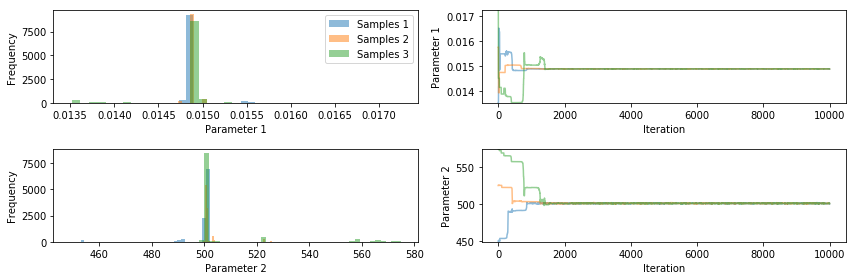

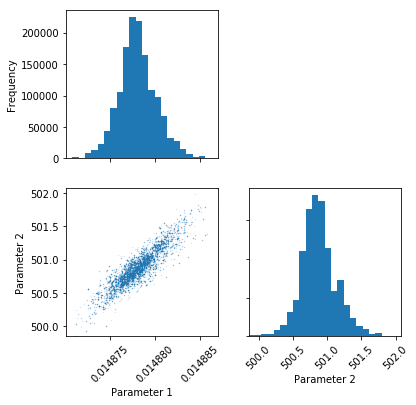

In [28]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

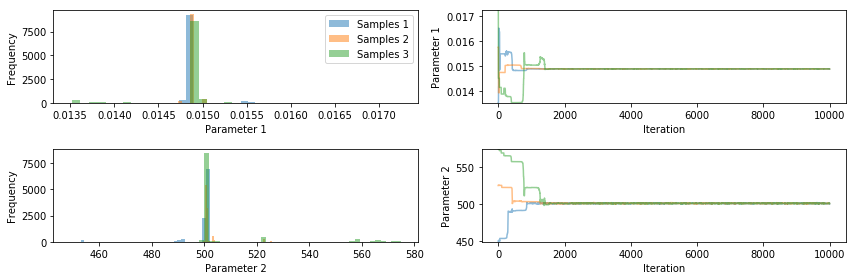

In [29]:
pints.plot.trace(chains_emu)
plt.show()

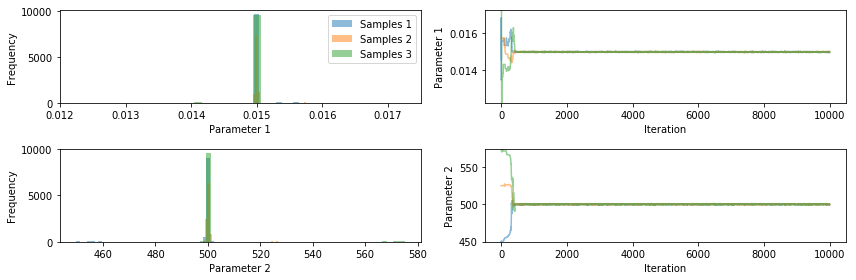

In [30]:
pints.plot.trace(chains)
plt.show()

In [31]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

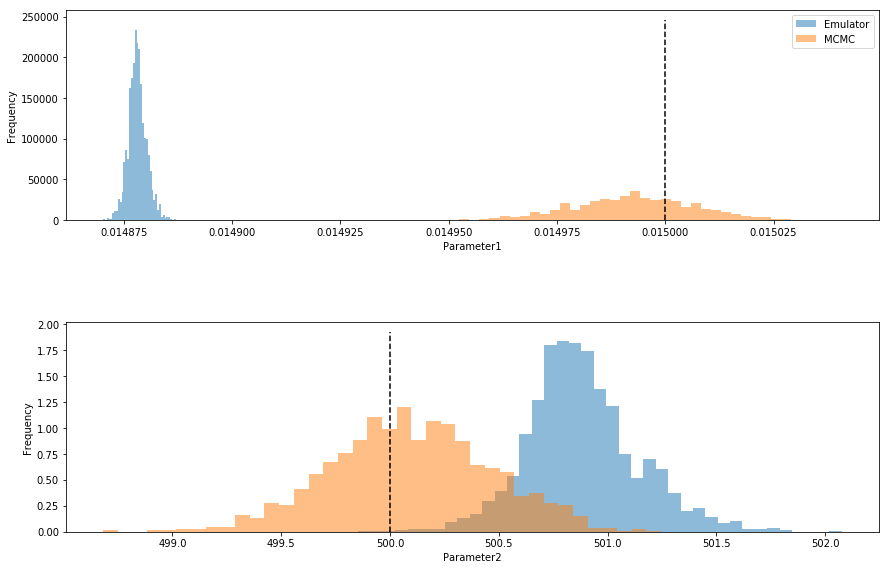

In [32]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

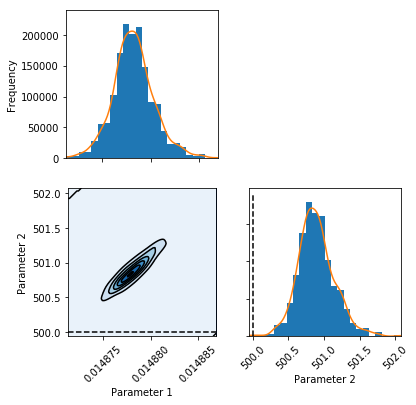

In [33]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

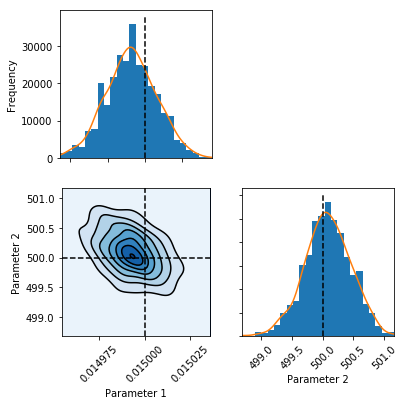

In [34]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

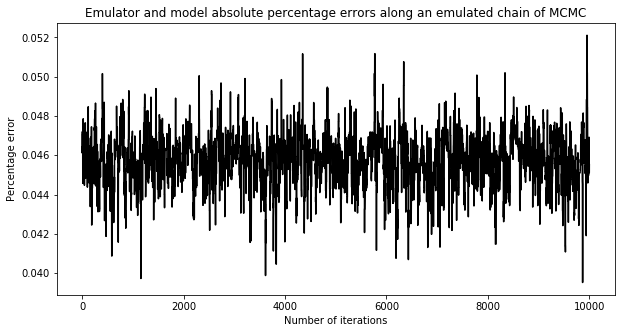

0.045778470483099375

In [35]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

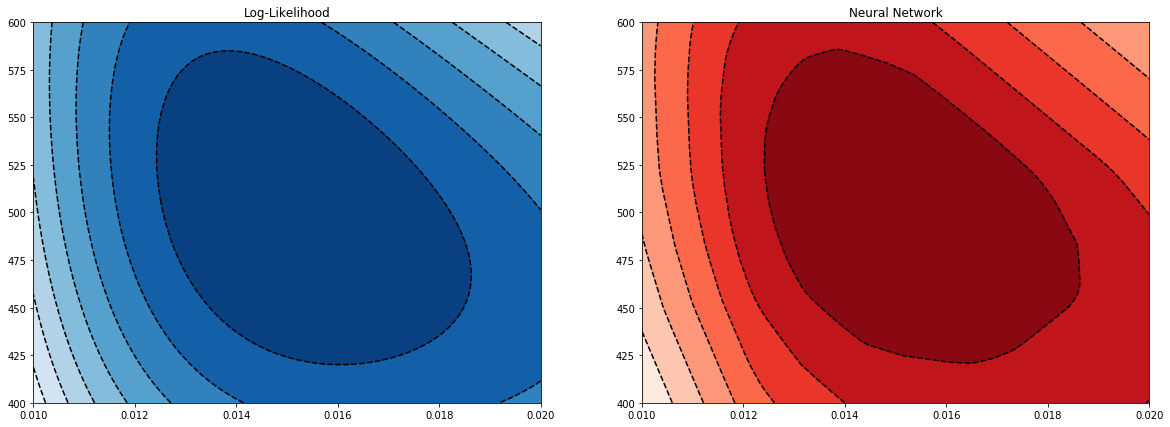

In [36]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

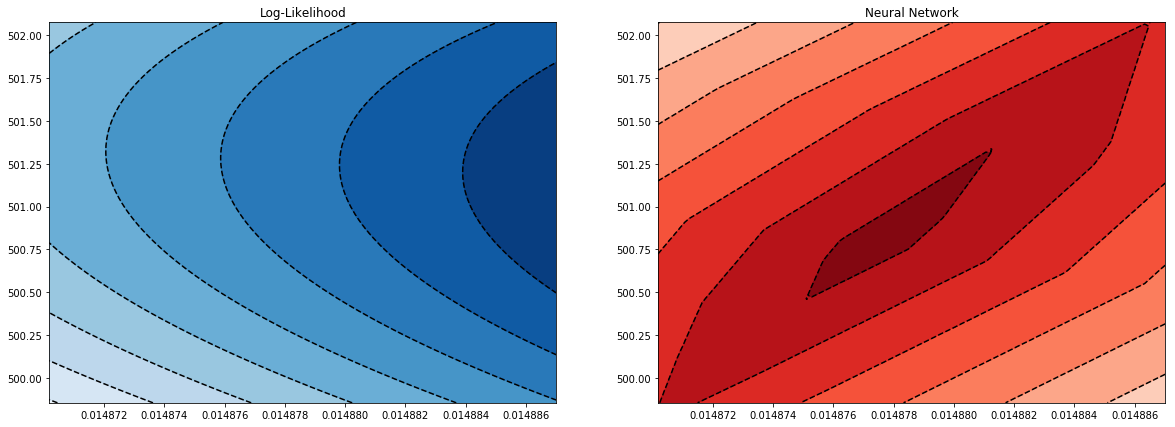

In [37]:
# Create grid
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

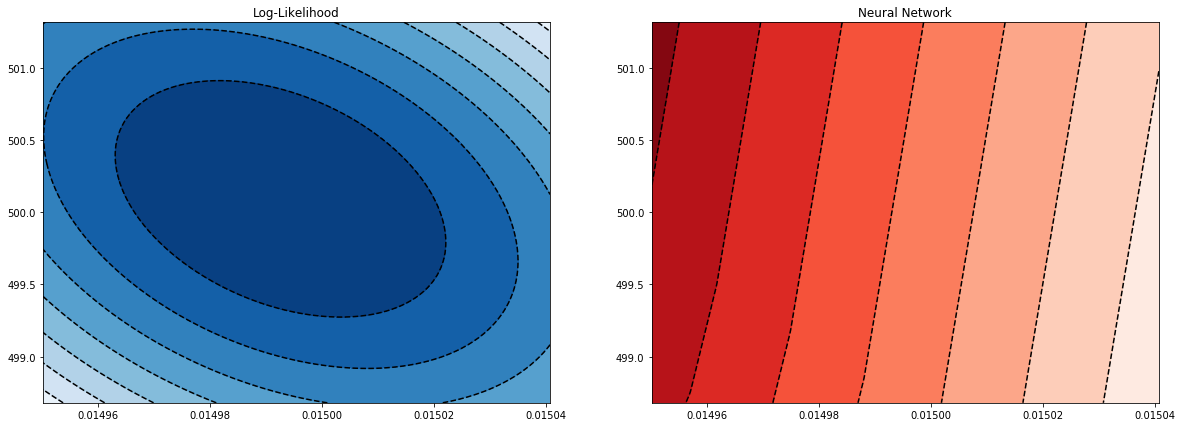

In [38]:
# Create grid
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

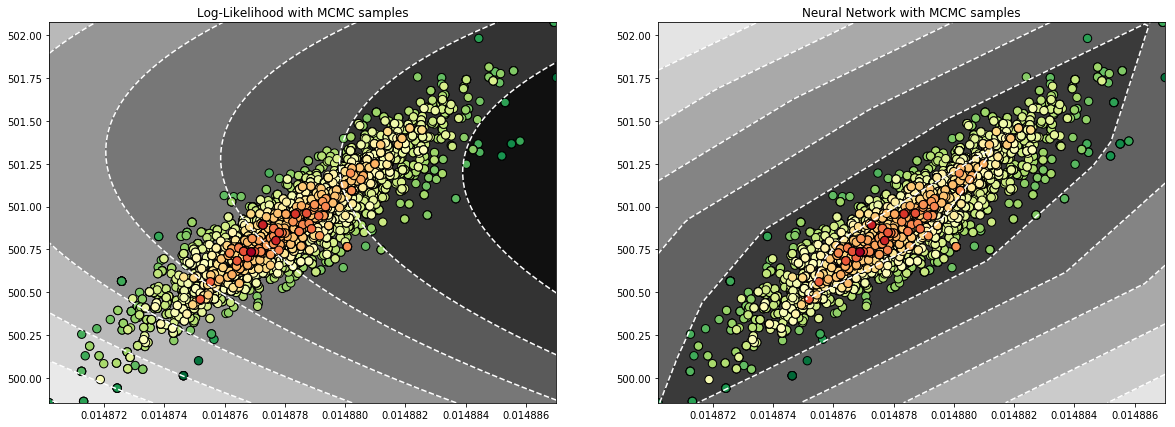

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to likelihood error
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

plt.show()

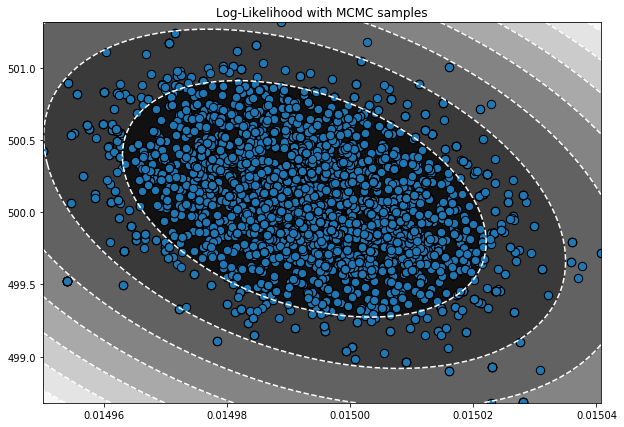

In [56]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()